# House Prices - Advanced Regression Techniques

## Kaggle Competition: Predicting House Prices

This notebook documents our approach to the House Prices prediction competition on Kaggle. We'll explore different methods for data cleaning, feature engineering, feature selection, and model training while tracking all experiments with MLflow.

## Dependencies

First, we'll import all the necessary libraries for our analysis.

In [26]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import dagshub
import mlflow
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import warnings
import pickle

## MLflow & DagsHub Setup

We'll use MLflow for tracking our experiments and DagsHub for version control integration. This combination allows us to log metrics, parameters, and artifacts while keeping our codebase organized.

In [27]:
dagshub.init(repo_owner='lagorg22', repo_name='house_prices', mlflow=True)
print('success')

Accessing as lagorg22

Initialized MLflow to track repo "lagorg22/house_prices"

Repository lagorg22/house_prices initialized!

success


### MLflow Tracking Functions

To effectively monitor our machine learning pipeline, we'll define a set of specialized tracking functions. These functions will systematically log parameters, metrics, artifacts, and models at each stage of our workflow.

In [28]:
# Create experiment to organize all runs
mlflow.set_experiment("house_prices_prediction")

# Tracking function for data cleaning operations
def log_cleaning_step(step_name, description, original_shape, cleaned_shape, dropped_columns=None, imputed_columns=None):
    """Log details about a data cleaning operation
    
    Parameters:
    -----------
    step_name : str
        Name of the cleaning step
    description : str
        Description of what the cleaning step does
    original_shape : tuple
        Shape of the dataframe before cleaning (rows, columns)
    cleaned_shape : tuple
        Shape of the dataframe after cleaning (rows, columns)
    dropped_columns : list, optional
        List of column names that were dropped
    imputed_columns : list, optional
        List of column names that had values imputed
    """
    with mlflow.start_run(nested=True, run_name=f"cleaning_{step_name}"):
        # Log basic info
        mlflow.log_param("step_type", "cleaning")
        mlflow.log_param("step_name", step_name)
        mlflow.log_param("description", description)
        
        # Log shape changes
        mlflow.log_param("original_rows", original_shape[0])
        mlflow.log_param("original_columns", original_shape[1])
        mlflow.log_param("cleaned_rows", cleaned_shape[0])
        mlflow.log_param("cleaned_columns", cleaned_shape[1])
        mlflow.log_metric("removed_columns", original_shape[1] - cleaned_shape[1])
        
        # Log specific column information if provided
        if dropped_columns:
            mlflow.log_param("dropped_columns", dropped_columns)
            mlflow.log_metric("num_dropped_columns", len(dropped_columns))
            
        if imputed_columns:
            mlflow.log_param("imputed_columns", imputed_columns)
            mlflow.log_metric("num_imputed_columns", len(imputed_columns))
            
        print(f"Logged cleaning step: {step_name}")

# Tracking function for feature engineering operations
def log_feature_engineering(step_name, description, features_before, features_after, 
                           new_features=None, transformed_features=None, artifacts=None):
    """Log details about a feature engineering operation
    
    Parameters:
    -----------
    step_name : str
        Name of the feature engineering step
    description : str
        Description of what the feature engineering step does
    features_before : int
        Number of features before engineering
    features_after : int
        Number of features after engineering
    new_features : list, optional
        List of newly created features
    transformed_features : list, optional
        List of features that were transformed
    artifacts : dict, optional
        Dictionary mapping artifact names to file paths
    """
    with mlflow.start_run(nested=True, run_name=f"feature_{step_name}"):
        # Log basic info
        mlflow.log_param("step_type", "feature_engineering")
        mlflow.log_param("step_name", step_name)
        mlflow.log_param("description", description)
        
        # Log feature count changes
        mlflow.log_param("features_before", features_before)
        mlflow.log_param("features_after", features_after)
        mlflow.log_metric("net_feature_change", features_after - features_before)
        
        # Log specific feature information if provided
        if new_features:
            mlflow.log_param("new_features", new_features)
            mlflow.log_metric("num_new_features", len(new_features))
            
        if transformed_features:
            mlflow.log_param("transformed_features", transformed_features)
            mlflow.log_metric("num_transformed_features", len(transformed_features))
        
        # Log artifacts if provided
        if artifacts:
            for name, path in artifacts.items():
                mlflow.log_artifact(path)
                
        print(f"Logged feature engineering step: {step_name}")

# Tracking function for feature selection operations
def log_feature_selection(method, description, features_before, features_after, 
                          selected_features, selection_score=None, artifacts=None):
    """Log details about a feature selection operation
    
    Parameters:
    -----------
    method : str
        Name of the feature selection method
    description : str
        Description of the selection method
    features_before : int
        Number of features before selection
    features_after : int
        Number of features after selection
    selected_features : list
        List of selected feature names
    selection_score : float, optional
        Score used for feature selection if applicable
    artifacts : dict, optional
        Dictionary mapping artifact names to file paths
    """
    with mlflow.start_run(nested=True, run_name=f"selection_{method}"):
        # Log basic info
        mlflow.log_param("step_type", "feature_selection")
        mlflow.log_param("selection_method", method)
        mlflow.log_param("description", description)
        
        # Log feature count changes
        mlflow.log_param("features_before", features_before)
        mlflow.log_param("features_after", features_after)
        mlflow.log_metric("feature_reduction", features_before - features_after)
        mlflow.log_metric("feature_reduction_percent", 
                        ((features_before - features_after) / features_before) * 100)
        
        # Log selected features
        mlflow.log_param("num_selected_features", len(selected_features))
        
        # Create a text file with selected features for logging
        with open("selected_features.txt", "w") as f:
            for feature in selected_features:
                f.write(f"{feature}\n")
        mlflow.log_artifact("selected_features.txt")
        
        # Log selection score if provided
        if selection_score is not None:
            mlflow.log_metric("selection_score", selection_score)
        
        # Log artifacts if provided
        if artifacts:
            for name, path in artifacts.items():
                mlflow.log_artifact(path)
                
        print(f"Logged feature selection method: {method}")

# Tracking function for model training and evaluation
def log_model_training(model_name, model, X_train, y_train, X_val, y_val, params=None, log_model_file=True):
    """Log model training process, hyperparameters, and performance metrics
    
    Parameters:
    -----------
    model_name : str
        Name of the model
    model : object
        Trained model object
    X_train : DataFrame
        Training features
    y_train : Series
        Training target
    X_val : DataFrame
        Validation features
    y_val : Series
        Validation target
    params : dict, optional
        Model hyperparameters
    log_model_file : bool
        Whether to log the model file itself
    
    Returns:
    --------
    dict : Dictionary of evaluation metrics
    """
    with mlflow.start_run(nested=True, run_name=f"model_{model_name}"):
        # Log model information
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("training_samples", len(X_train))
        mlflow.log_param("validation_samples", len(X_val))
        mlflow.log_param("features", list(X_train.columns))
        mlflow.log_param("num_features", len(X_train.columns))
        
        # Log hyperparameters if provided
        if params:
            for param, value in params.items():
                mlflow.log_param(param, value)
        
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        
        # Log metrics
        mlflow.log_metric("train_rmse", train_rmse)
        mlflow.log_metric("val_rmse", val_rmse)
        mlflow.log_metric("train_mae", train_mae)
        mlflow.log_metric("val_mae", val_mae)
        mlflow.log_metric("train_r2", train_r2)
        mlflow.log_metric("val_r2", val_r2)
        
        # Calculate and log overfitting metrics
        rmse_diff = train_rmse - val_rmse
        rmse_ratio = val_rmse / train_rmse if train_rmse > 0 else float('inf')
        r2_diff = train_r2 - val_r2
        
        mlflow.log_metric("rmse_diff", rmse_diff)
        mlflow.log_metric("rmse_ratio", rmse_ratio)
        mlflow.log_metric("r2_diff", r2_diff)
        
        # Log feature importance if available
        if hasattr(model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'Feature': X_train.columns,
                'Importance': model.feature_importances_
            }).sort_values('Importance', ascending=False)
            
            # Create feature importance plot
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
            plt.title(f'Feature Importance - {model_name}')
            plt.tight_layout()
            plt.savefig(f'{model_name}_importance.png')
            plt.close()
            
            # Log the plot as an artifact
            mlflow.log_artifact(f'{model_name}_importance.png')
            
            # Save and log the importance data
            importance_df.to_csv(f'{model_name}_importance.csv', index=False)
            mlflow.log_artifact(f'{model_name}_importance.csv')
        
        # Create and log prediction scatter plot
        plt.figure(figsize=(8, 8))
        plt.scatter(y_val, y_val_pred, alpha=0.5)
        plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'Actual vs Predicted - {model_name}')
        plt.tight_layout()
        plt.savefig(f'{model_name}_predictions.png')
        plt.close()
        mlflow.log_artifact(f'{model_name}_predictions.png')
        
        # Create and log residual plot
        plt.figure(figsize=(8, 6))
        residuals = y_val - y_val_pred
        plt.scatter(y_val_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted')
        plt.ylabel('Residuals')
        plt.title(f'Residual Plot - {model_name}')
        plt.tight_layout()
        plt.savefig(f'{model_name}_residuals.png')
        plt.close()
        mlflow.log_artifact(f'{model_name}_residuals.png')
        
        # Log the model itself
        if log_model_file:
            mlflow.sklearn.log_model(model, model_name)
        
        print(f"Logged model: {model_name}, Validation RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
        
        # Return metrics for further comparison
        return {
            'model_name': model_name,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'train_mae': train_mae,
            'val_mae': val_mae,
            'train_r2': train_r2,
            'val_r2': val_r2,
            'model': model
        }

# Tracking function for hyperparameter tuning
def log_hyperparameter_tuning(model_type, param_grid, best_params, best_score, cv_results=None, model=None):
    """Log hyperparameter tuning process and results
    
    Parameters:
    -----------
    model_type : str
        Type of model being tuned
    param_grid : dict
        Grid of hyperparameters that were tested
    best_params : dict
        Best hyperparameters found
    best_score : float
        Best score achieved
    cv_results : dict, optional
        Cross-validation results dictionary
    model : object, optional
        Best model to log
    """
    with mlflow.start_run(nested=True, run_name=f"tuning_{model_type}"):
        # Log basic info
        mlflow.log_param("step_type", "hyperparameter_tuning")
        mlflow.log_param("model_type", model_type)
        mlflow.log_param("param_grid", param_grid)
        
        # Log best parameters and score
        for param, value in best_params.items():
            mlflow.log_param(f"best_{param}", value)
            
        mlflow.log_metric("best_score", best_score)
        
        # If we have CV results, log details about the search
        if cv_results:
            # Create dataframe of results
            results_df = pd.DataFrame(cv_results)
            results_df.to_csv(f'{model_type}_cv_results.csv', index=False)
            mlflow.log_artifact(f'{model_type}_cv_results.csv')
            
            # Log some aggregate metrics about the search process
            mlflow.log_metric("num_configurations", len(results_df))
            mlflow.log_metric("mean_score", results_df['mean_test_score'].mean())
            mlflow.log_metric("median_score", results_df['mean_test_score'].median())
            mlflow.log_metric("min_score", results_df['mean_test_score'].min())
            mlflow.log_metric("max_score", results_df['mean_test_score'].max())
            mlflow.log_metric("score_std", results_df['mean_test_score'].std())
            
            # Create plot of parameter impact if there's enough data
            if len(param_grid) > 0 and len(results_df) > 1:
                for param in param_grid.keys():
                    param_col = f'param_{param}'
                    if param_col in results_df.columns:
                        try:
                            plt.figure(figsize=(10, 6))
                            sns.boxplot(x=param_col, y='mean_test_score', data=results_df)
                            plt.title(f'Effect of {param} on Score')
                            plt.tight_layout()
                            plt.savefig(f'{model_type}_{param}_effect.png')
                            plt.close()
                            mlflow.log_artifact(f'{model_type}_{param}_effect.png')
                        except:
                            print(f"Could not create parameter impact plot for {param}")
        
        # Log the best model if provided
        if model:
            mlflow.sklearn.log_model(model, f"best_{model_type}")
            
        print(f"Logged hyperparameter tuning for {model_type}, Best score: {best_score:.4f}")

# Function to register the best model in the MLflow model registry
def register_best_model(model, model_name, description=None):
    """Register the best model in MLflow model registry
    
    Parameters:
    -----------
    model : object
        Model to register
    model_name : str
        Name to register the model under
    description : str, optional
        Description of the model
        
    Returns:
    --------
    model_uri : str
        URI of the registered model
    """
    with mlflow.start_run(run_name=f"register_{model_name}"):
        # Log the model
        mlflow.sklearn.log_model(model, "model")
        model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
        
        # Register the model
        registered_model = mlflow.register_model(model_uri, model_name)
        
        # Add description if provided
        if description:
            client = mlflow.tracking.MlflowClient()
            client.update_registered_model(
                name=model_name,
                description=description
            )
        
        print(f"Registered model: {model_name}, Version: {registered_model.version}")
        return model_uri

# Create a directory for storing artifacts
os.makedirs("mlflow_artifacts", exist_ok=True)

2025/04/10 23:40:08 INFO mlflow.tracking.fluent: Experiment with name 'house_prices_prediction' does not exist. Creating a new experiment.


## Exploratory Data Analysis (EDA)

In this section, we'll explore the dataset to gain a better understanding of its structure, distributions, and relationships between variables. This will help us make informed decisions about cleaning and feature engineering.

In [29]:
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub

Id      SalePrice
0     1461  169277.052498
1     1462  187758.393989
2     1463  183583.683570
3     1464  179317.477511
4     1465  150730.079977
...    ...            ...
1454  2915  167081.220949
1455  2916  164788.778231
1456  2917  219222.423400
1457  2918  184924.279659
1458  2919  187741.866657

[1459 rows x 2 columns]

### Understanding the Data Description

First, let's read the data description file to understand what each variable represents.

In [30]:
with open('data_description.txt', 'r') as f:
    description = f.read()
print(description)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### Loading the Dataset

Now, let's load the training and test datasets for our analysis.

In [31]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

### Statistical Summary

Let's examine the statistical summary of our dataset to understand the distributions and ranges of numerical variables.

In [32]:
train_df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

### Dataset Structure

Let's check the structure of our dataset, including data types and missing values.

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Missing Values Analysis

Identifying and understanding missing values is crucial for effective data cleaning and preprocessing.

In [34]:
#columns with null values
nullable_columns = train_df[train_df.columns[train_df.isnull().any()]]
nullable_columns

LotFrontage Alley MasVnrType  MasVnrArea BsmtQual BsmtCond BsmtExposure  \
0            65.0   NaN    BrkFace       196.0       Gd       TA           No   
1            80.0   NaN        NaN         0.0       Gd       TA           Gd   
2            68.0   NaN    BrkFace       162.0       Gd       TA           Mn   
3            60.0   NaN        NaN         0.0       TA       Gd           No   
4            84.0   NaN    BrkFace       350.0       Gd       TA           Av   
...           ...   ...        ...         ...      ...      ...          ...   
1455         62.0   NaN        NaN         0.0       Gd       TA           No   
1456         85.0   NaN      Stone       119.0       Gd       TA           No   
1457         66.0   NaN        NaN         0.0       TA       Gd           No   
1458         68.0   NaN        NaN         0.0       TA       TA           Mn   
1459         75.0   NaN        NaN         0.0       TA       TA           No   

     BsmtFinType1 BsmtFinType2 Electrical FireplaceQu GarageType  GarageYrBlt  \
0             GLQ          Unf      SBrkr         NaN     Attchd       2003.0   
1             ALQ          Unf      SBrkr          TA     Attchd       1976.0   
2             GLQ          Unf      SBrkr          TA     Attchd       2001.0   
3             ALQ          Unf      SBrkr          Gd     Detchd       1998.0   
4             GLQ          Unf      SBrkr          TA     Attchd       2000.0   
...           ...          ...        ...         ...        ...          ...   
1455          Unf          Unf      SBrkr          TA     Attchd       1999.0   
1456          ALQ          Rec      SBrkr          TA     Attchd       1978.0   
1457          GLQ          Unf      SBrkr          Gd     Attchd       1941.0   
1458          GLQ          Rec      FuseA         NaN     Attchd       1950.0   
1459          BLQ          LwQ      SBrkr         NaN     Attchd       1965.0   

     GarageFinish GarageQual GarageCond PoolQC  Fence MiscFeature  
0             RFn         TA         TA    NaN    NaN         NaN  
1             RFn         TA         TA    NaN    NaN         NaN  
2             RFn         TA         TA    NaN    NaN         NaN  
3             Unf         TA         TA    NaN    NaN         NaN  
4             RFn         TA         TA    NaN    NaN         NaN  
...           ...        ...        ...    ...    ...         ...  
1455          RFn         TA         TA    NaN    NaN         NaN  
1456          Unf         TA         TA    NaN  MnPrv         NaN  
1457          RFn         TA         TA    NaN  GdPrv        Shed  
1458          Unf         TA         TA    NaN    NaN         NaN  
1459          Fin         TA         TA    NaN    NaN         NaN  

[1460 rows x 19 columns]

### Visualizing Missing Values

A heatmap can help us visualize the pattern of missing values across different features.

<Axes: >

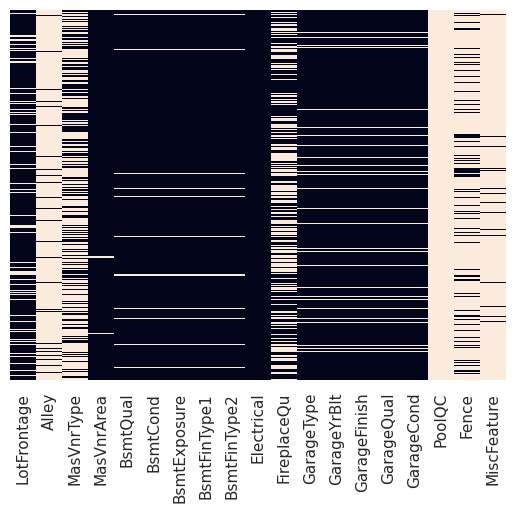

In [35]:
'''
According to this plot and earlier examinations, columns [Alley, MasVnrType, MiscFeature
Fence, poolQC, FireplaceQu] needs to be dropped, because of large amount of null values.
'''
sns.heatmap(nullable_columns.isnull(),yticklabels=False,cbar=False)

## Data Cleaning

Based on our exploratory analysis, we'll now clean the dataset by handling missing values and removing irrelevant or problematic features. Our goal is to create a clean dataset that's ready for feature engineering and modeling. Each cleaning step will be tracked in MLflow to document our process.

### Starting a Main MLflow Run

Let's start a main MLflow run that will encompass our entire machine learning process.

In [36]:
# Start a main MLflow run
main_run = mlflow.start_run(run_name="house_prices_prediction_pipeline")
print(f"Started main MLflow run: {main_run.info.run_id}")

# Log initial dataset information
mlflow.log_param("training_samples", train_df.shape[0])
mlflow.log_param("test_samples", test_df.shape[0])
mlflow.log_param("initial_features", train_df.shape[1])
mlflow.log_param("target_variable", "SalePrice")

# Log information about missing values
missing_counts = train_df.isnull().sum()
features_with_missing = missing_counts[missing_counts > 0].index.tolist()
mlflow.log_param("features_with_missing_values", features_with_missing)
mlflow.log_param("num_features_with_missing", len(features_with_missing))
mlflow.log_metric("total_missing_values", train_df.isnull().sum().sum())

Started main MLflow run: 45905c626f964354aaf7f1949f11b5e5


# Cleaning Data

## Removing Features with High Missing Values

First, we'll remove the columns with a large proportion of missing values as they would require extensive imputation and might not provide reliable information.

In [37]:
# Store original shapes for logging
original_train_shape = train_df.shape
original_test_shape = test_df.shape

# Columns to drop due to high missing values
high_missing_columns = ['Alley', 'MasVnrType', 'MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu']

# Remove previously discussed columns
train_df.drop(columns=high_missing_columns, inplace=True)
test_df.drop(columns=high_missing_columns, inplace=True)

# Log the cleaning step in MLflow
log_cleaning_step(
    step_name="remove_high_missing",
    description="Removed columns with high percentage of missing values",
    original_shape=original_train_shape,
    cleaned_shape=train_df.shape,
    dropped_columns=high_missing_columns
)

Logged cleaning step: remove_high_missing
🏃 View run cleaning_remove_high_missing at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1/runs/817df190df3644f8a9c684541e6d2e9f
🧪 View experiment at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1


### Reassessing Missing Values

Let's check if there are still features with missing values after our initial column removal.

In [38]:
nullable_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   Alley         91 non-null     object 
 2   MasVnrType    588 non-null    object 
 3   MasVnrArea    1452 non-null   float64
 4   BsmtQual      1423 non-null   object 
 5   BsmtCond      1423 non-null   object 
 6   BsmtExposure  1422 non-null   object 
 7   BsmtFinType1  1423 non-null   object 
 8   BsmtFinType2  1422 non-null   object 
 9   Electrical    1459 non-null   object 
 10  FireplaceQu   770 non-null    object 
 11  GarageType    1379 non-null   object 
 12  GarageYrBlt   1379 non-null   float64
 13  GarageFinish  1379 non-null   object 
 14  GarageQual    1379 non-null   object 
 15  GarageCond    1379 non-null   object 
 16  PoolQC        7 non-null      object 
 17  Fence         281 non-null    object 
 18  MiscFeature   54 non-null   

<Axes: >

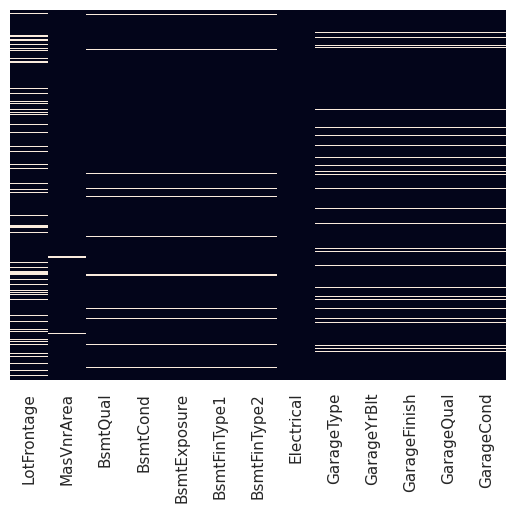

In [39]:
nullable_columns = train_df[train_df.columns[train_df.isnull().any()]]
sns.heatmap(nullable_columns.isnull(),yticklabels=False,cbar=False)

### Imputing Missing Values

For the remaining missing values, we'll apply an imputation strategy based on the data type:
- For categorical features: impute with the mode (most frequent value)
- For numerical features: impute with the mean

This approach preserves the overall distribution of the data while filling in the gaps.

In [40]:
# Get features with missing values before imputation
missing_before = train_df.columns[train_df.isnull().any()].tolist()
missing_counts_before = train_df[missing_before].isnull().sum().to_dict()

# Replacing objects with mode and integers/floats with avg
def replace_nulls(df):
    imputed_columns = []
    for col in df.columns:
        if df[col].isnull().sum() > 0:  # Only process columns with missing values
            imputed_columns.append(col)
            if df[col].dtype == 'object':
                mode = df[col].mode(dropna=True)
                if not mode.empty:
                    df[col].fillna(mode[0], inplace=True)
            elif pd.api.types.is_numeric_dtype(df[col]):
                mean = df[col].mean()
                df[col].fillna(mean, inplace=True)
    return df, imputed_columns

# Apply imputation
train_df, imputed_cols_train = replace_nulls(train_df)
test_df, imputed_cols_test = replace_nulls(test_df)

# Combine imputed columns from train and test
all_imputed_cols = list(set(imputed_cols_train + imputed_cols_test))

# Log the imputation step
log_cleaning_step(
    step_name="impute_missing_values",
    description="Imputed missing values using mode for categorical features and mean for numerical features",
    original_shape=train_df.shape,  # Shape doesn't change with imputation
    cleaned_shape=train_df.shape,
    imputed_columns=all_imputed_cols
)

# Log details about the imputation
with open("imputation_details.txt", "w") as f:
    f.write("Missing value counts before imputation:\n")
    for col, count in missing_counts_before.items():
        f.write(f"{col}: {count} missing values\n")
        
    f.write("\nImputation method by column:\n")
    for col in all_imputed_cols:
        if col in train_df.columns:
            method = "mode" if train_df[col].dtype == "object" else "mean"
            f.write(f"{col}: {method}\n")

# Log the imputation details as an artifact
with mlflow.start_run(nested=True, run_name="imputation_details"):
    mlflow.log_artifact("imputation_details.txt")

Logged cleaning step: impute_missing_values
🏃 View run cleaning_impute_missing_values at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1/runs/1f84af70fd674f5dbd93a02be4aaef10
🧪 View experiment at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1
🏃 View run imputation_details at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1/runs/3c90dad454744da69630de14303ae932
🧪 View experiment at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1


### Verifying Cleaning Results

Let's check the structure of our cleaned dataset to ensure there are no more missing values.

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Feature Engineering

Now that we have a clean dataset, we'll focus on feature engineering. This involves creating visualization functions for tracking our progress and analyzing the impact of our transformations.

### Visualizing Categorical Features

Let's visualize the relationship between categorical features and the target variable (SalePrice) using violin plots. This will help us understand which categorical features might be most predictive.

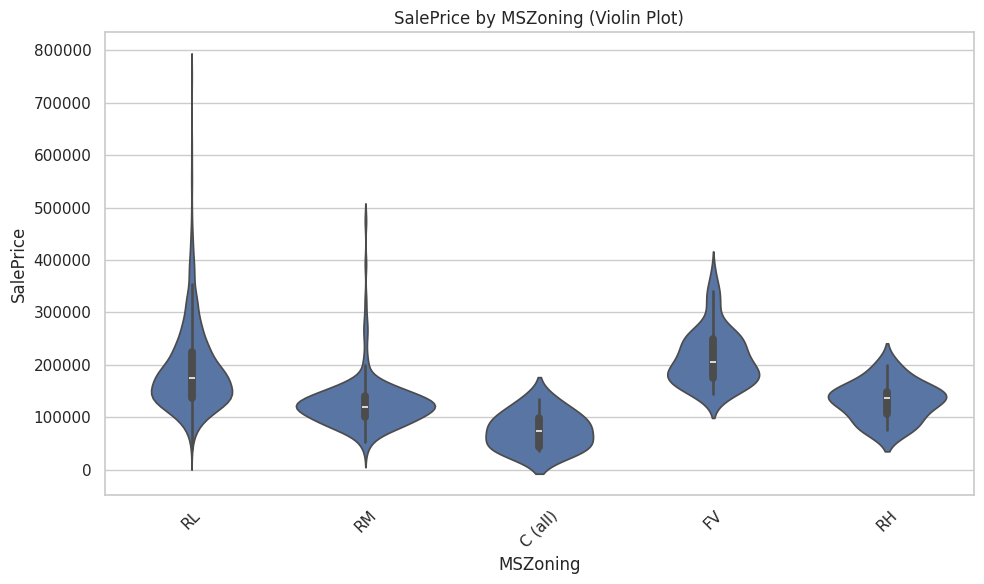

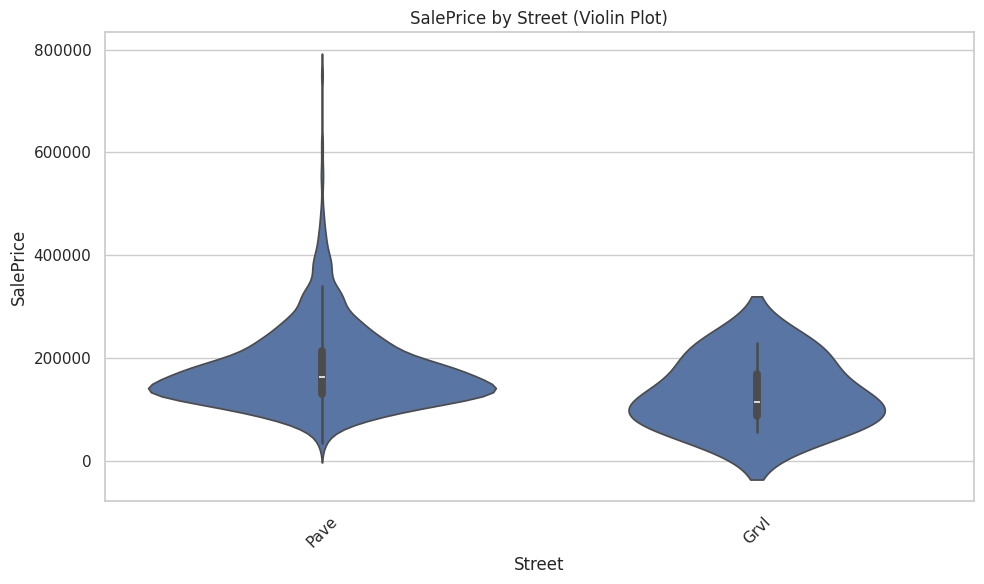

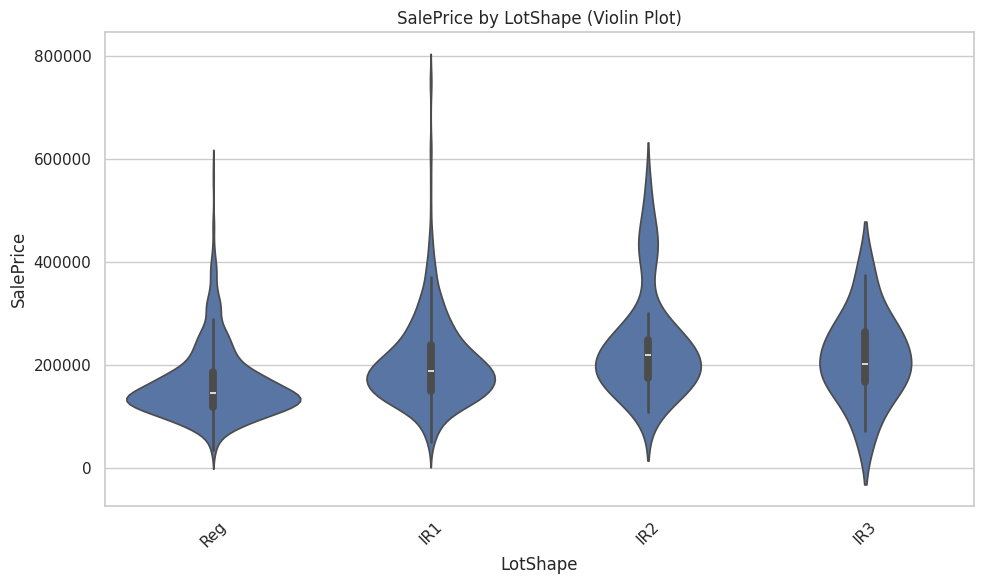

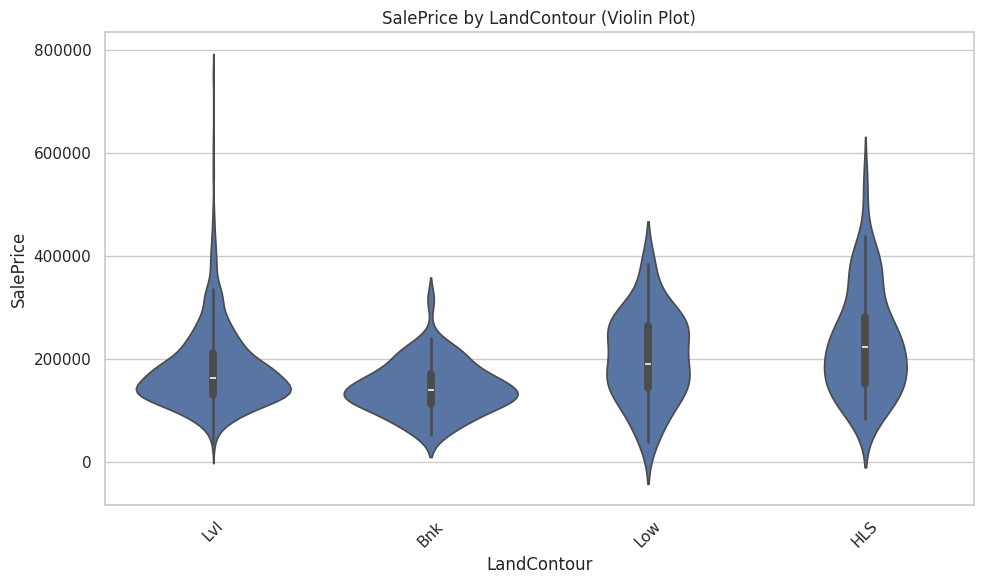

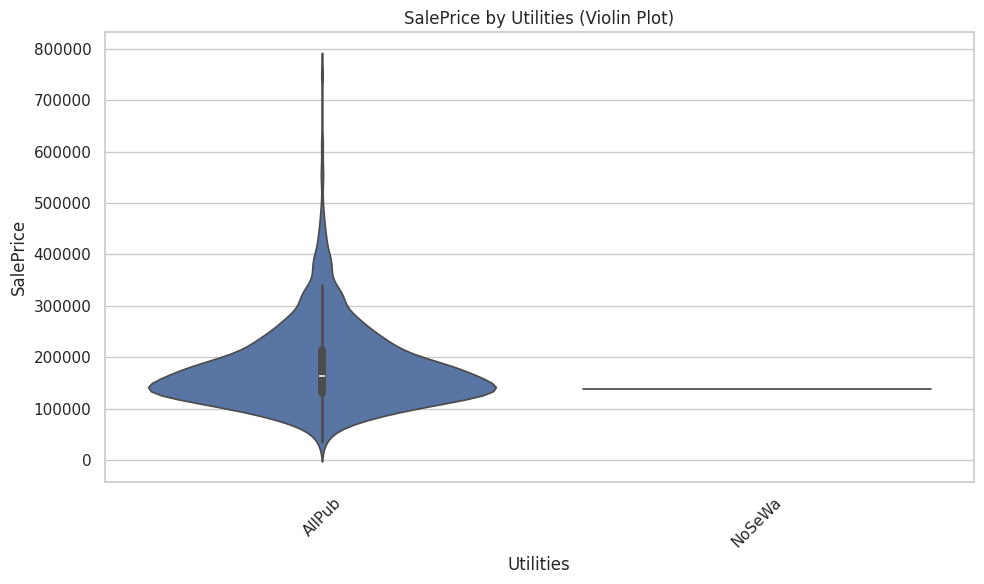

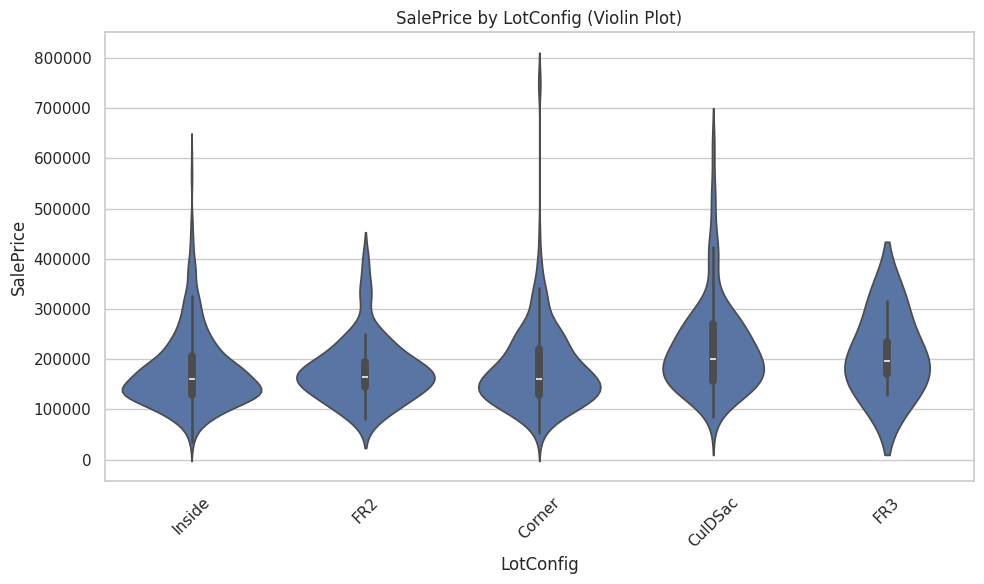

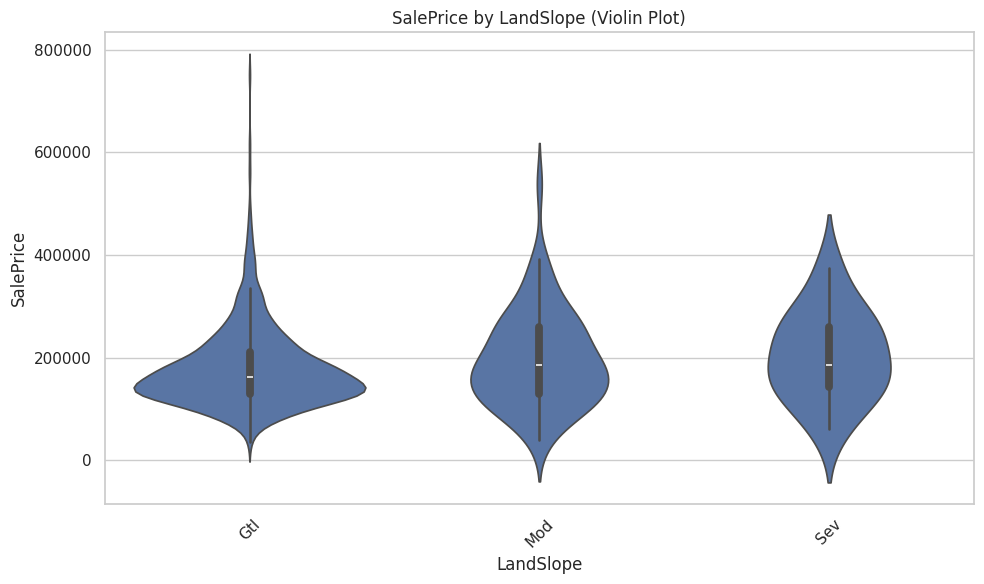

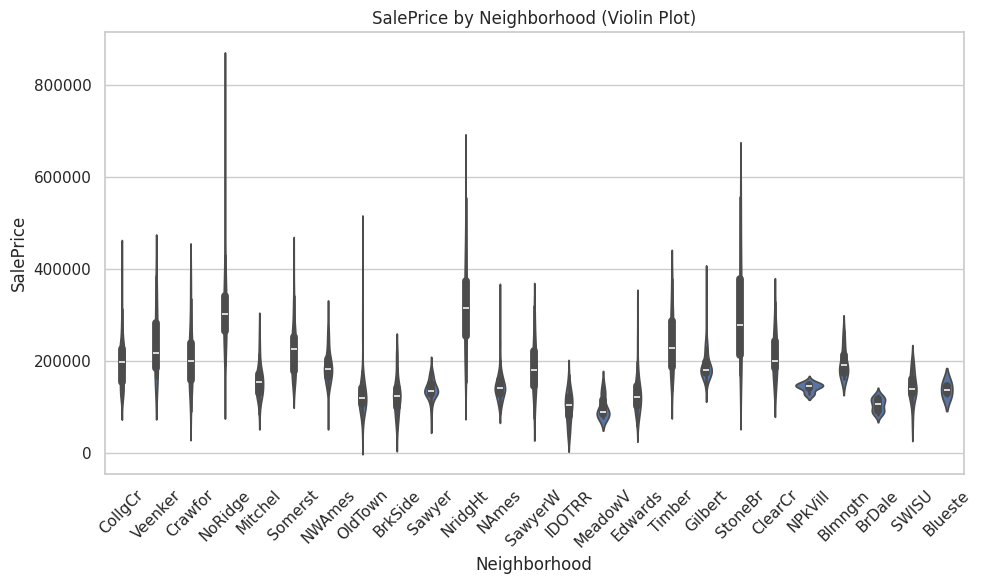

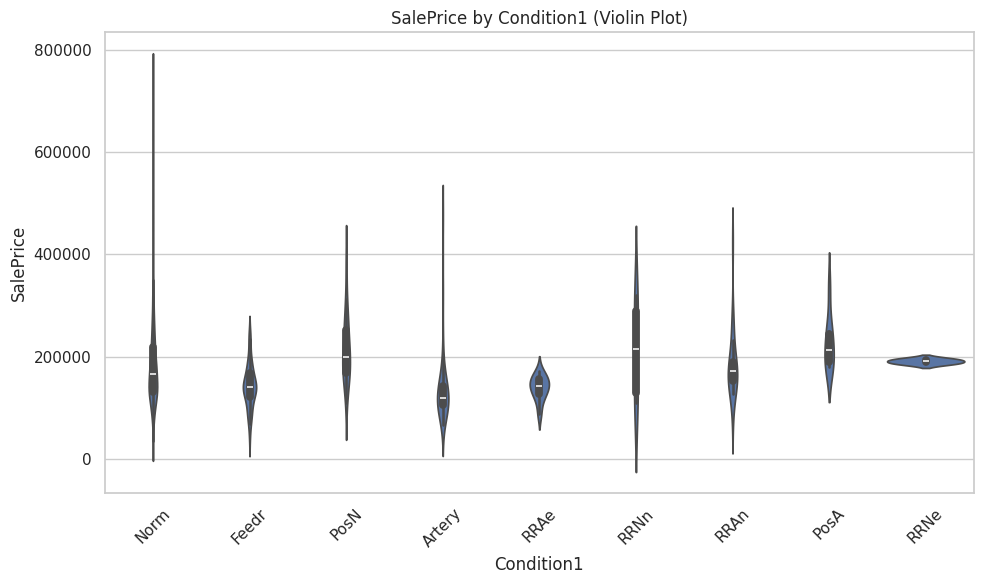

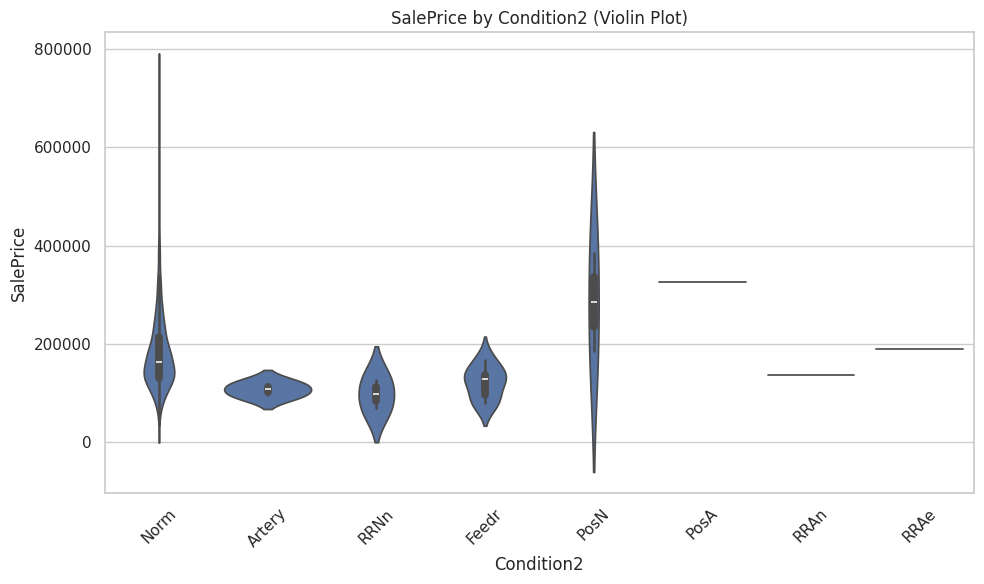

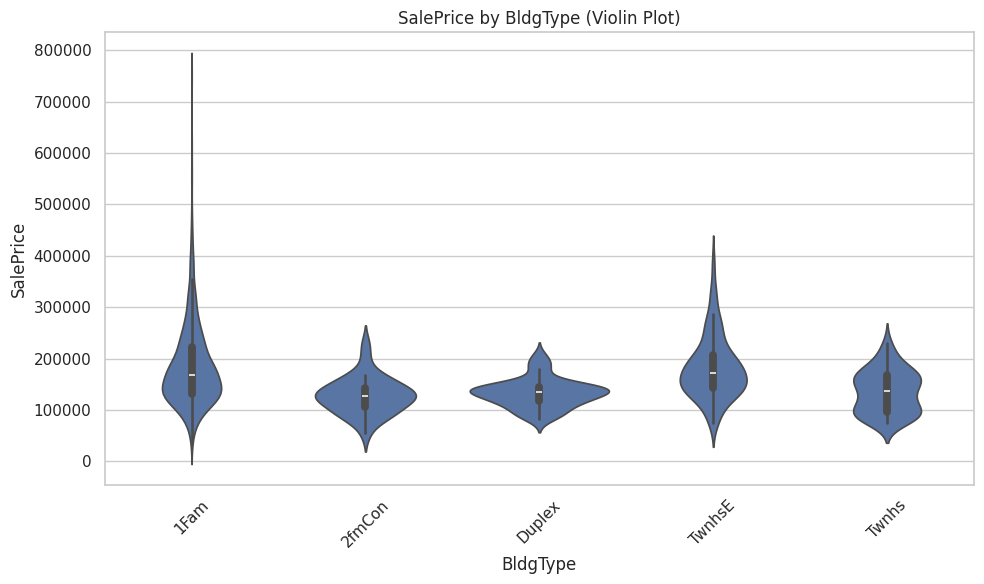

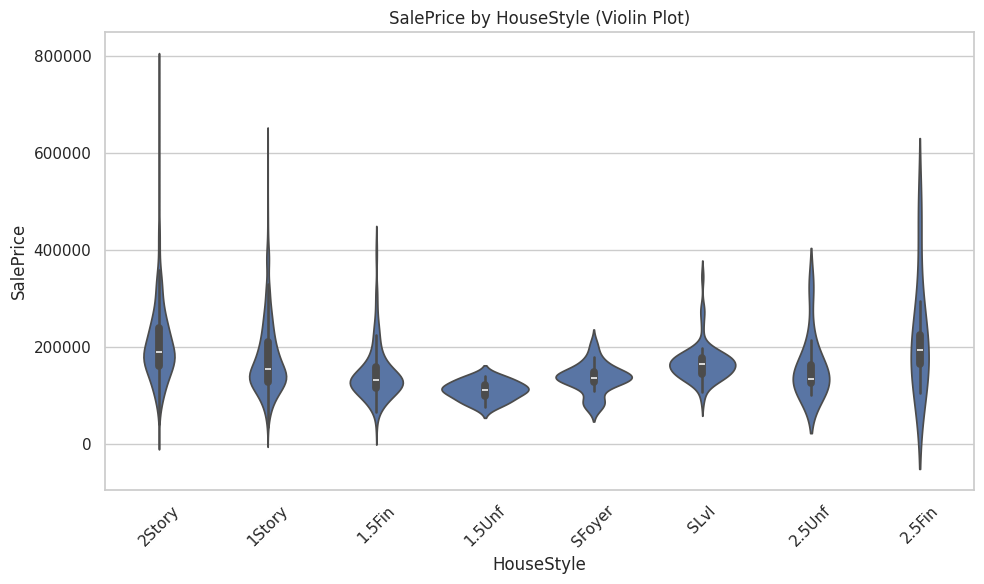

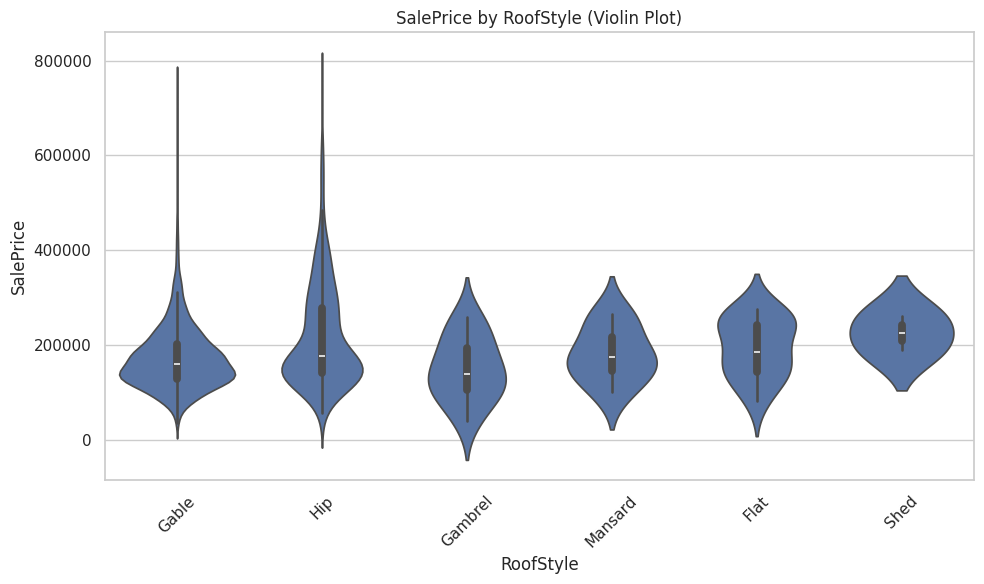

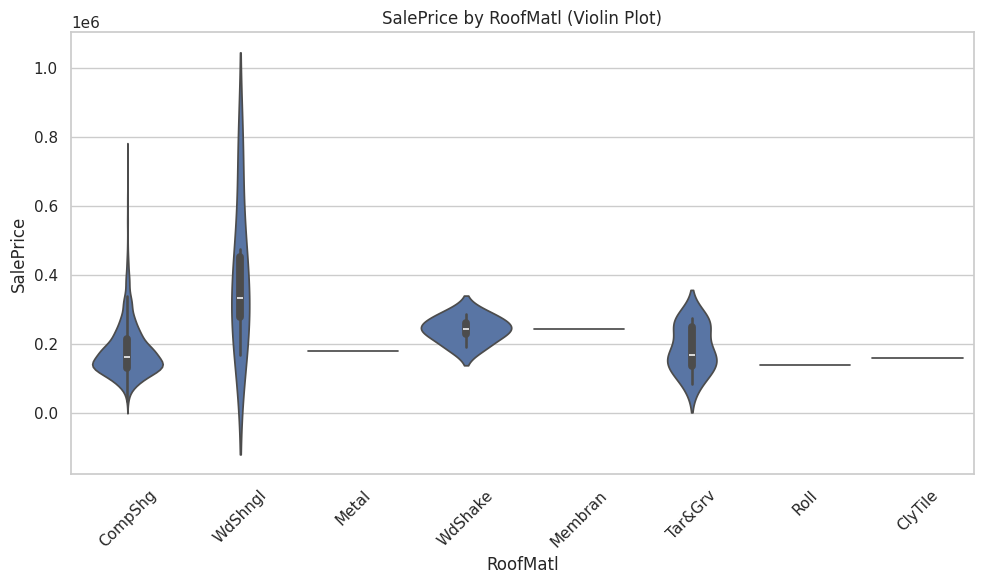

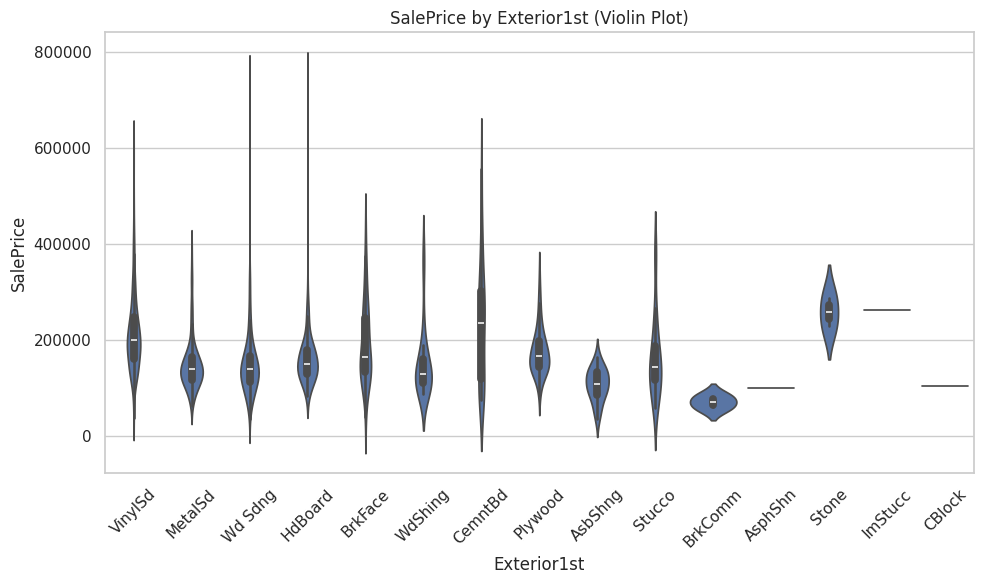

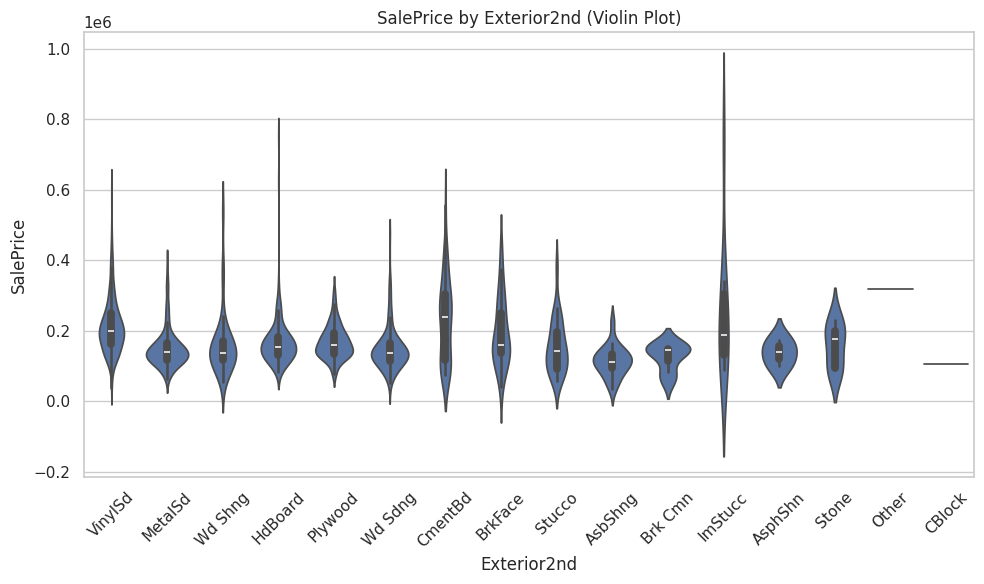

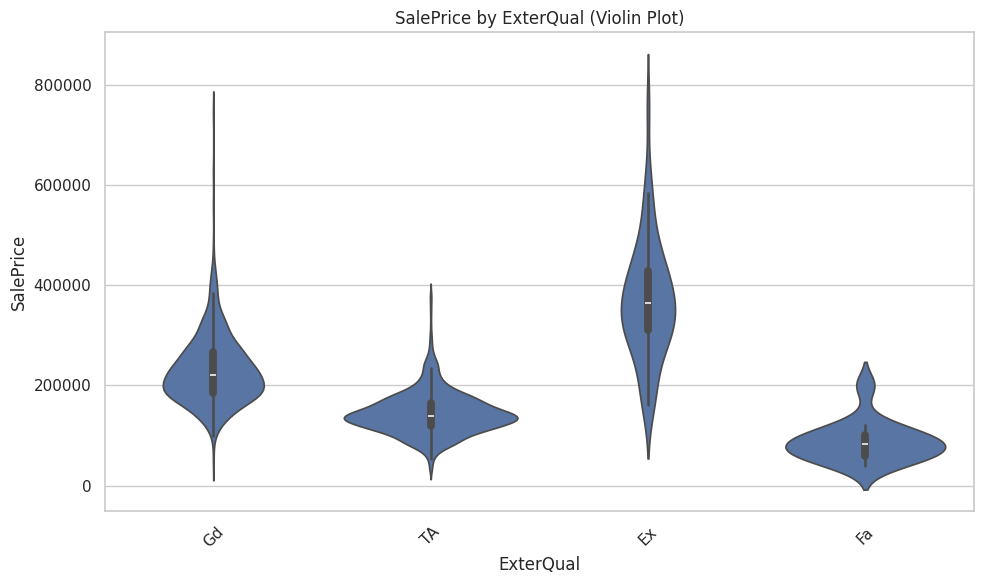

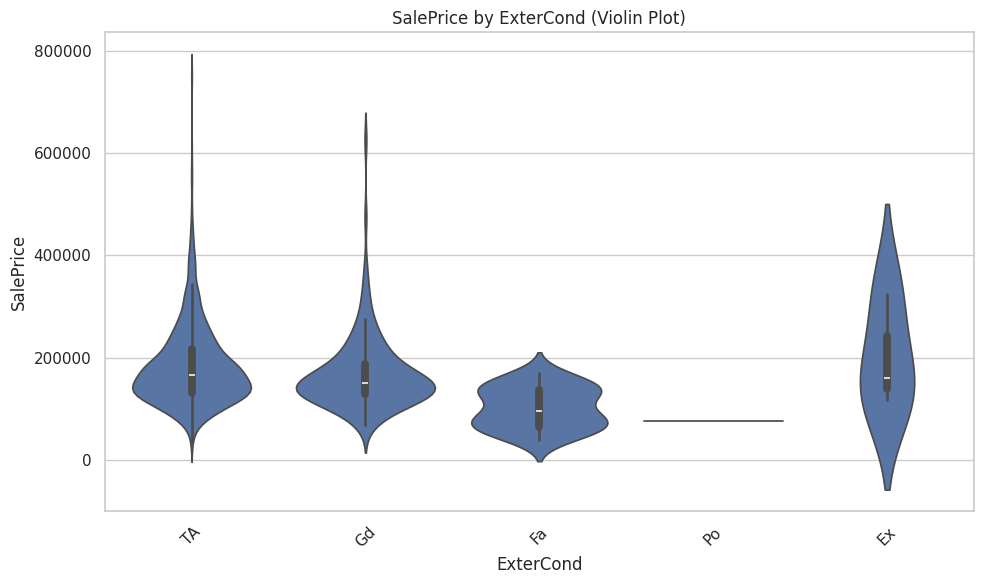

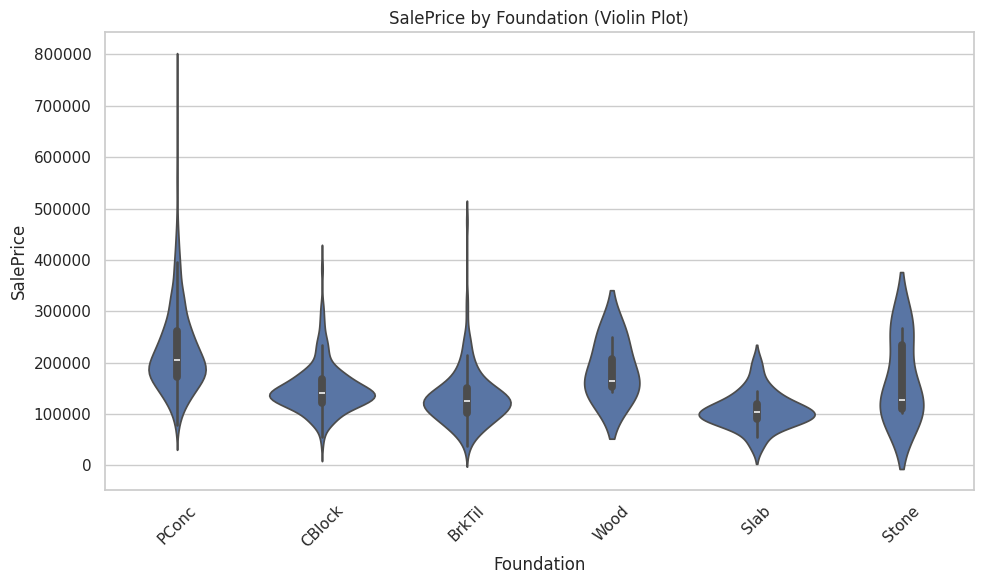

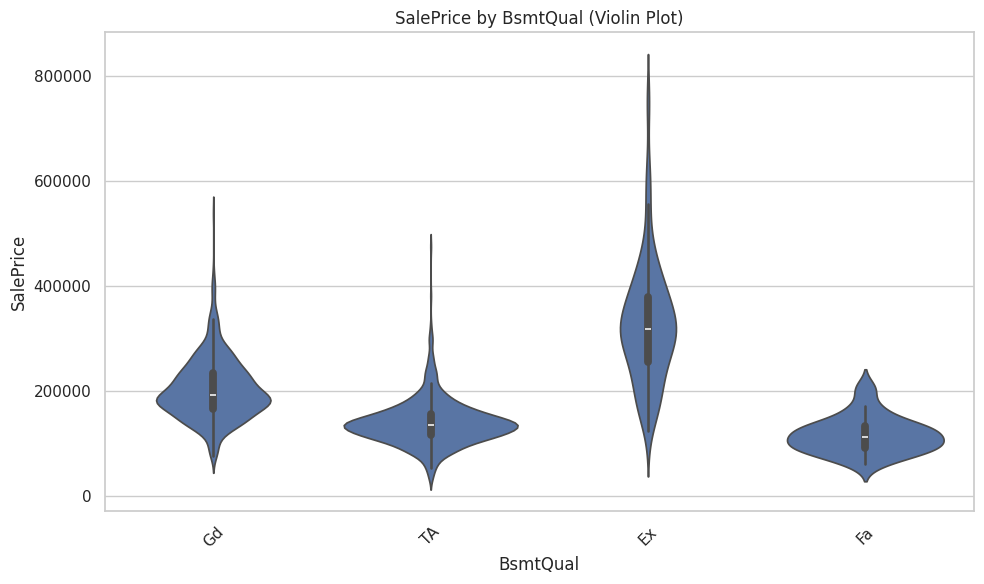

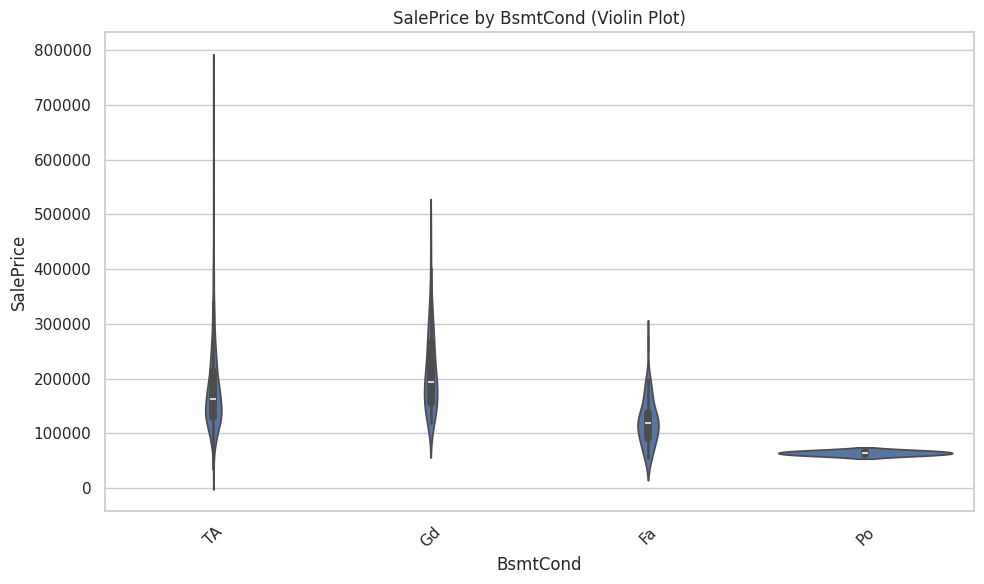

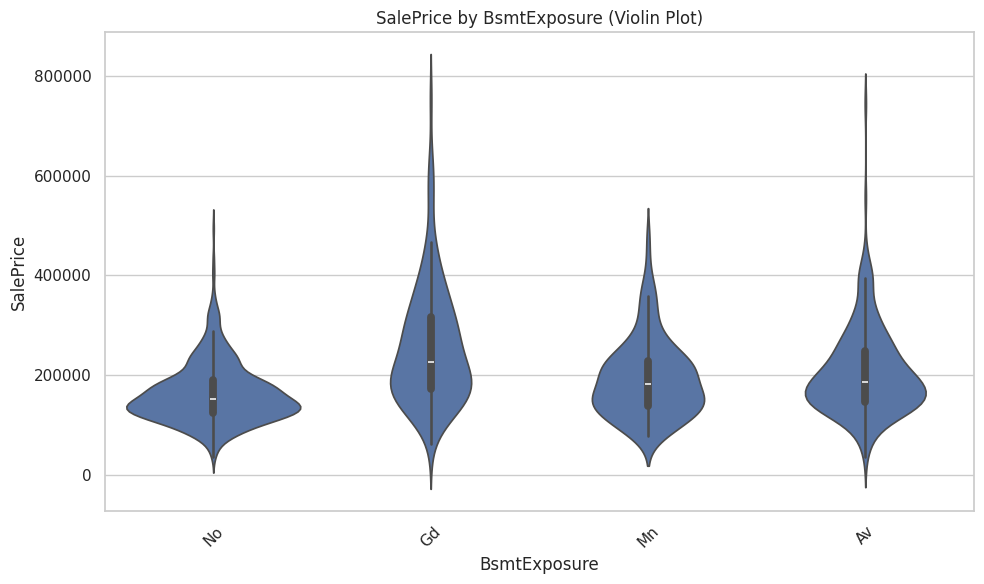

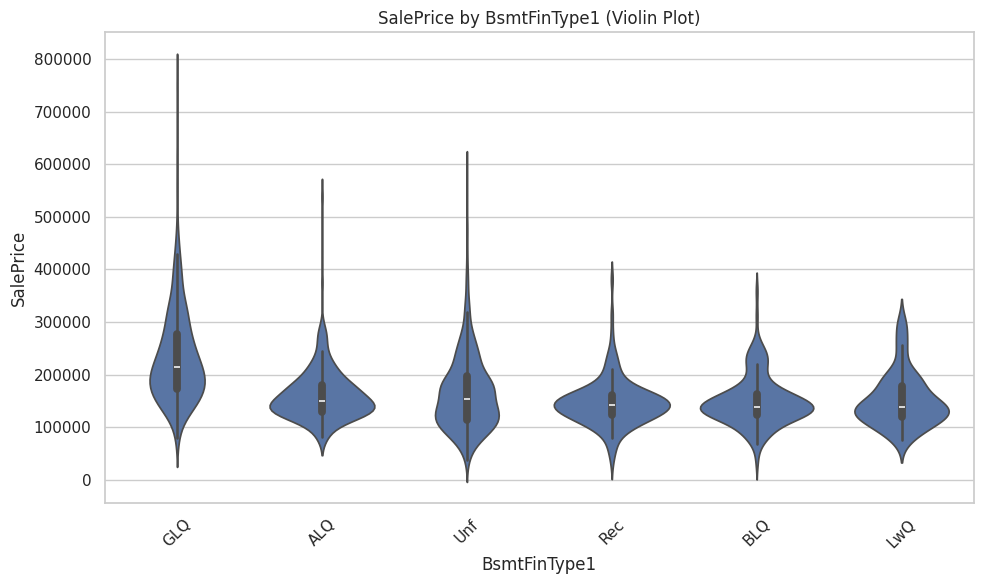

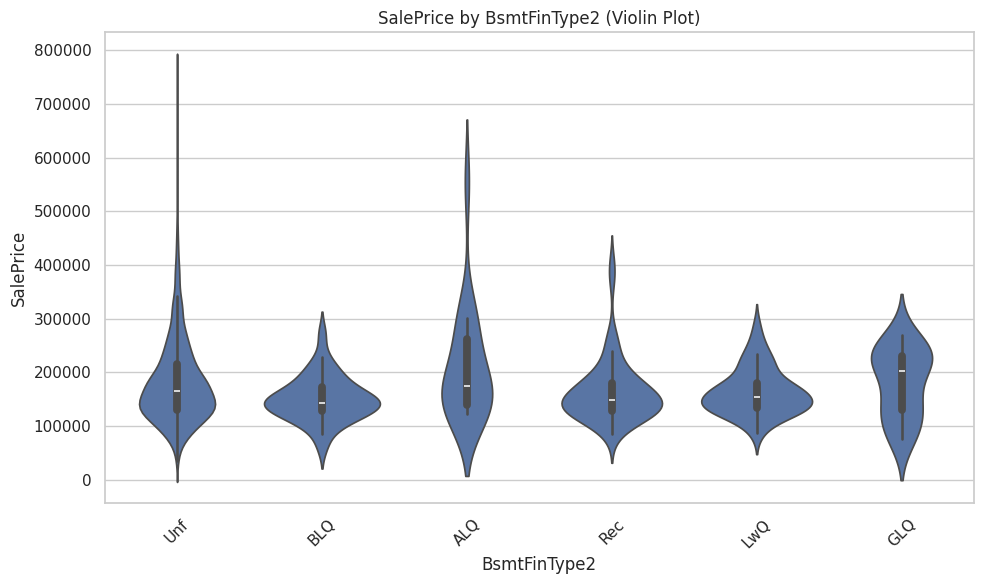

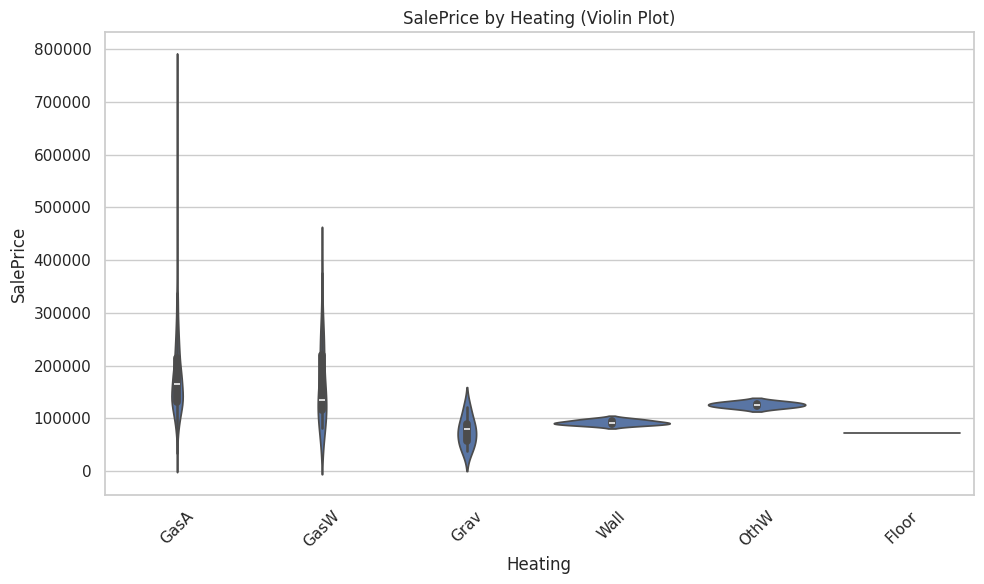

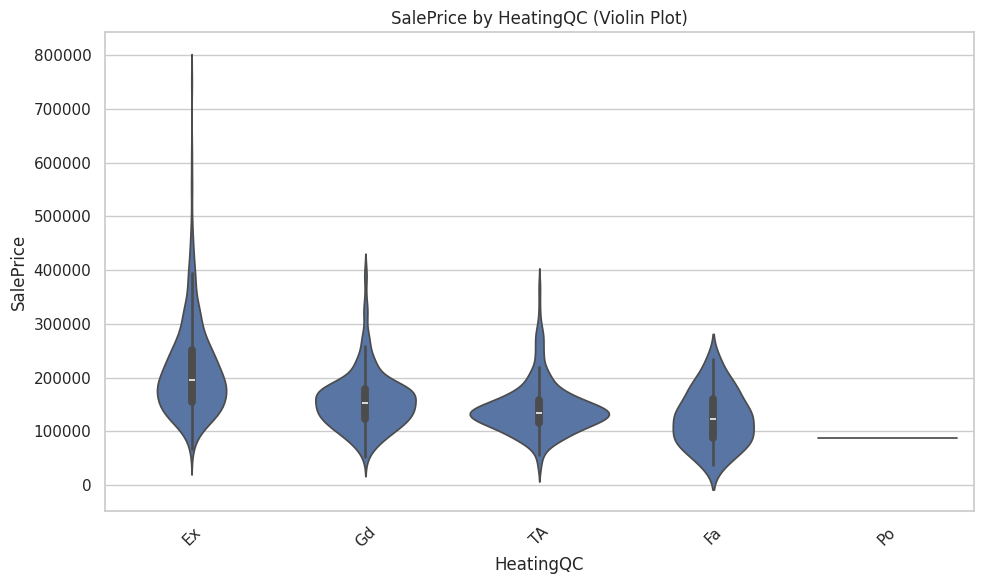

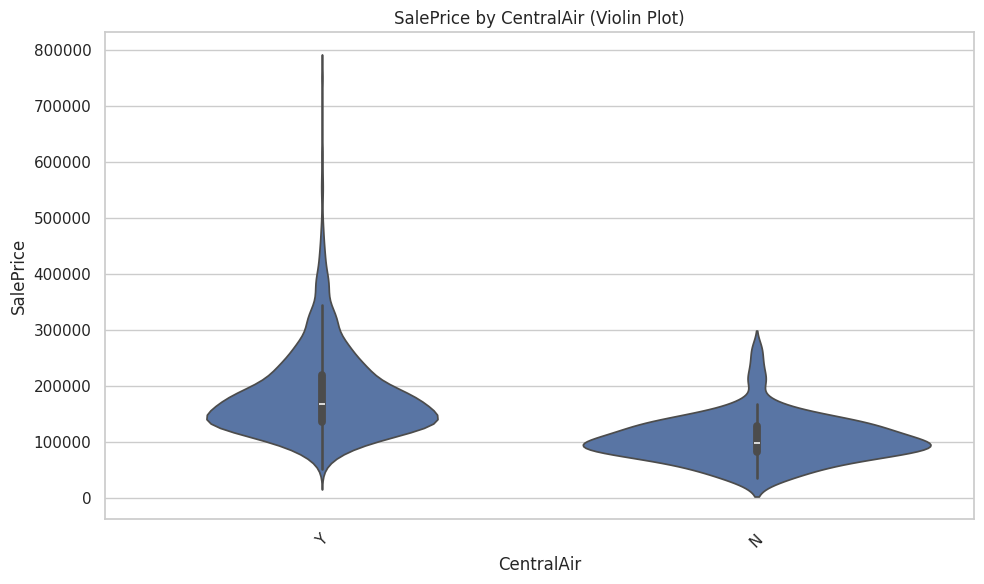

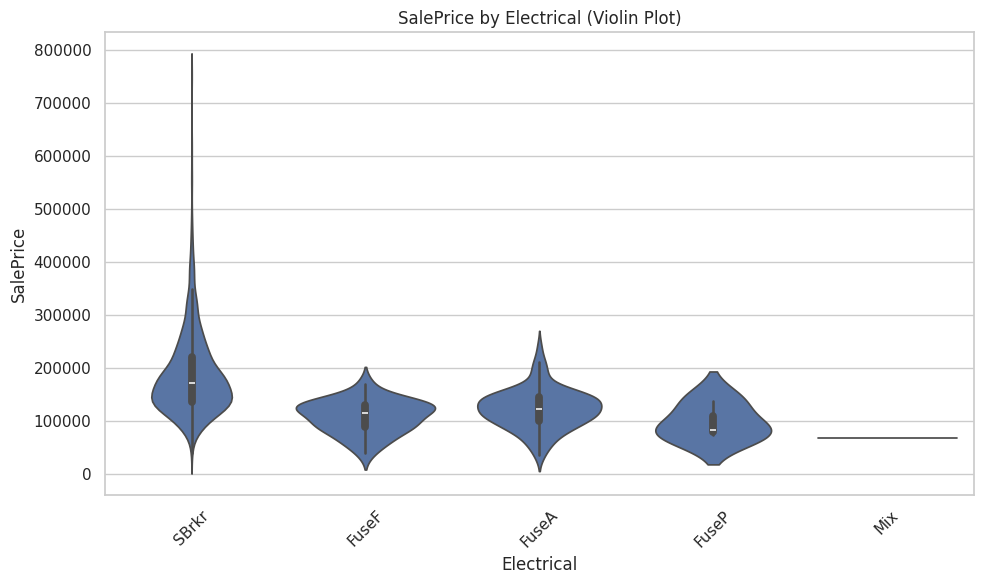

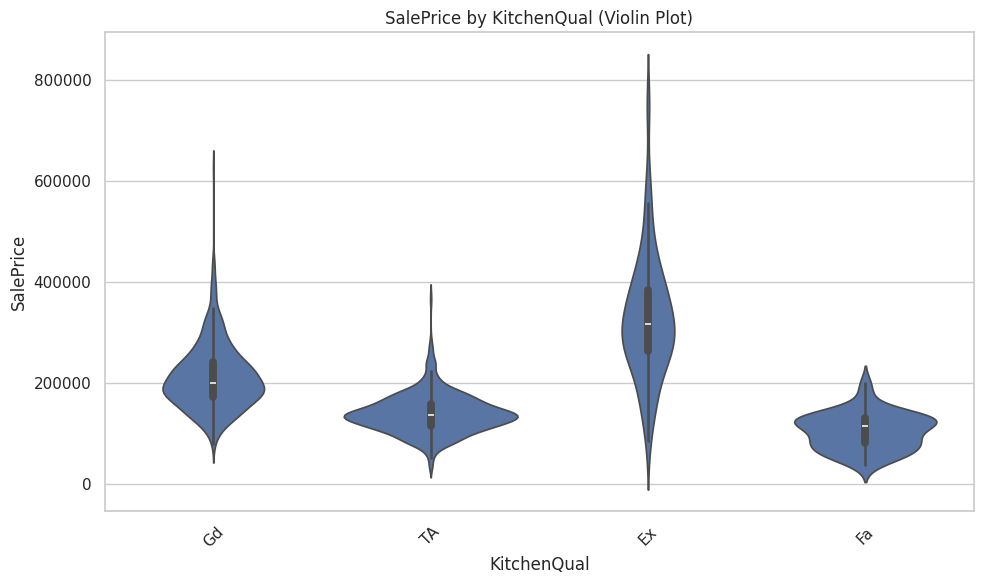

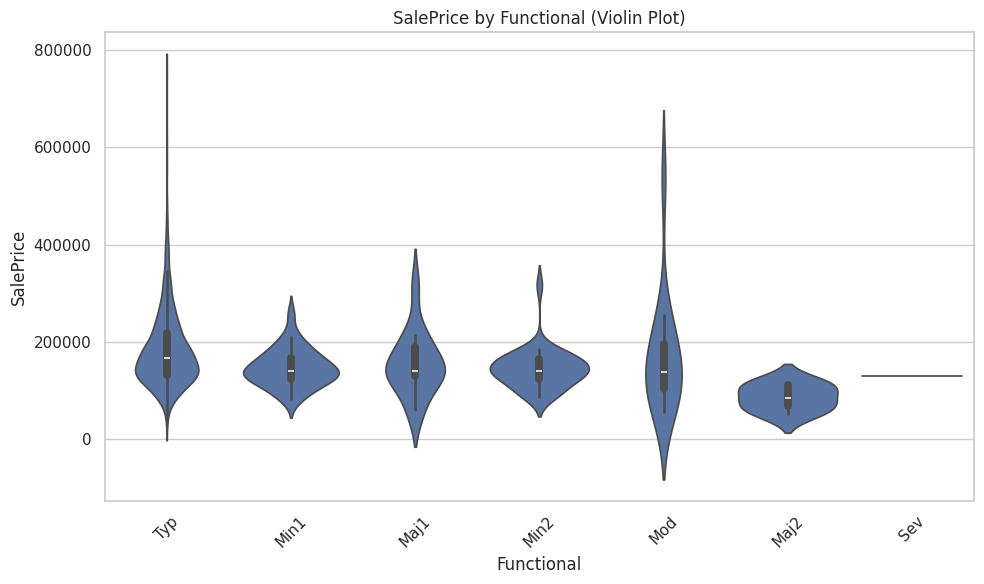

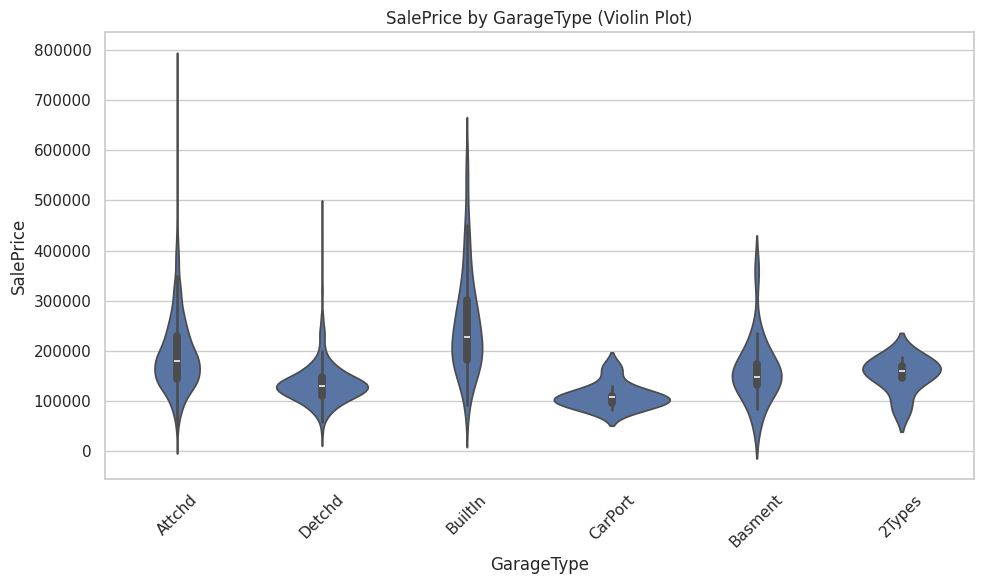

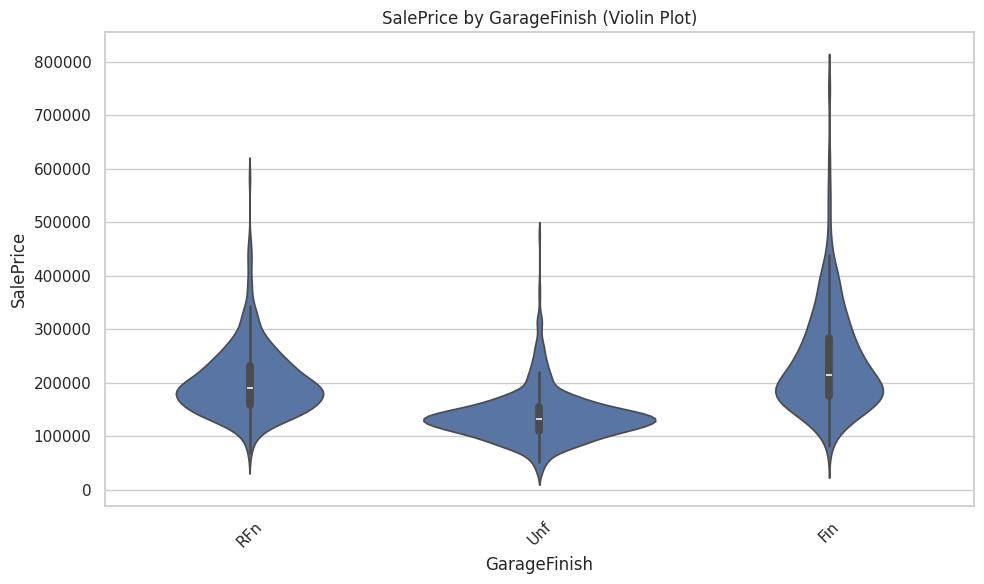

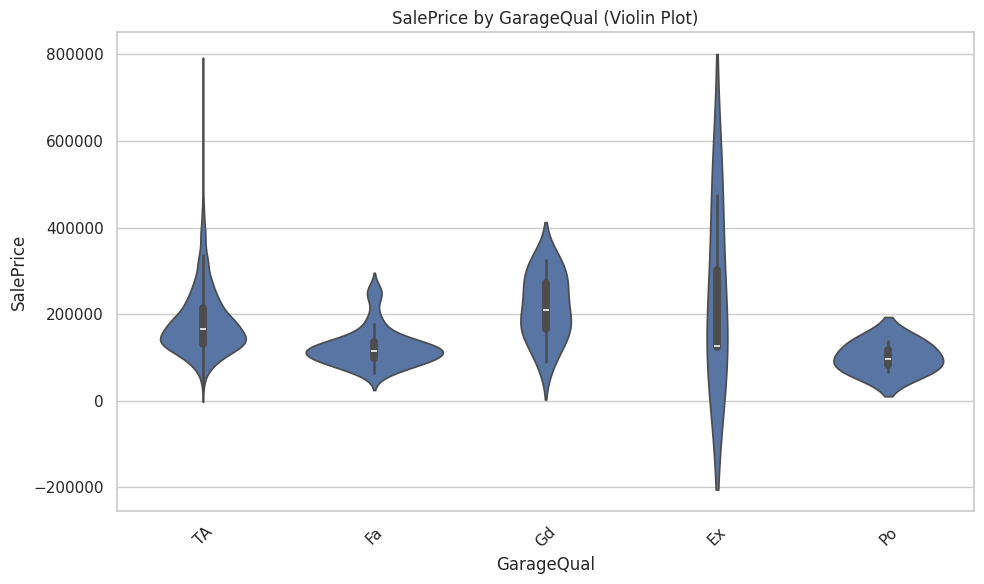

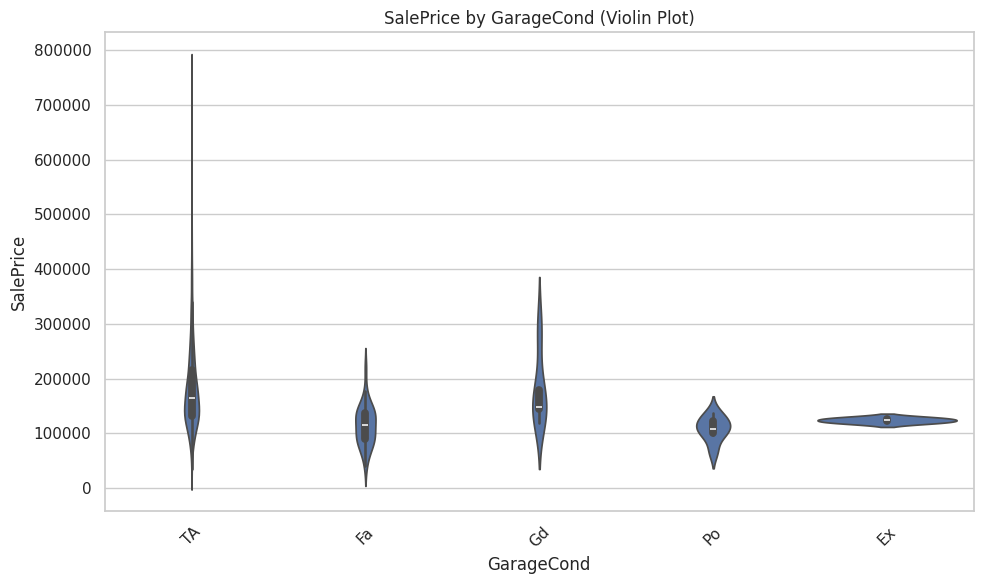

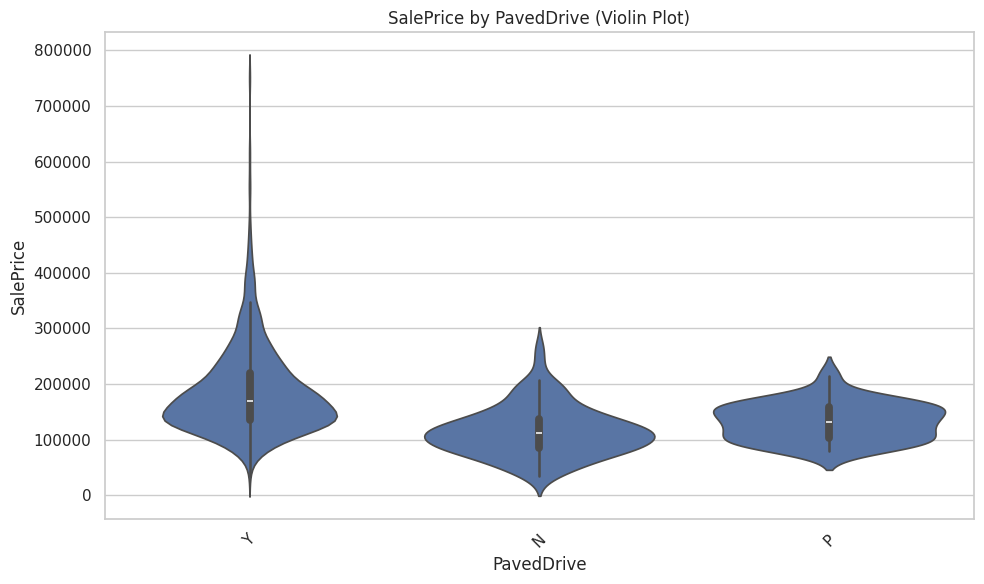

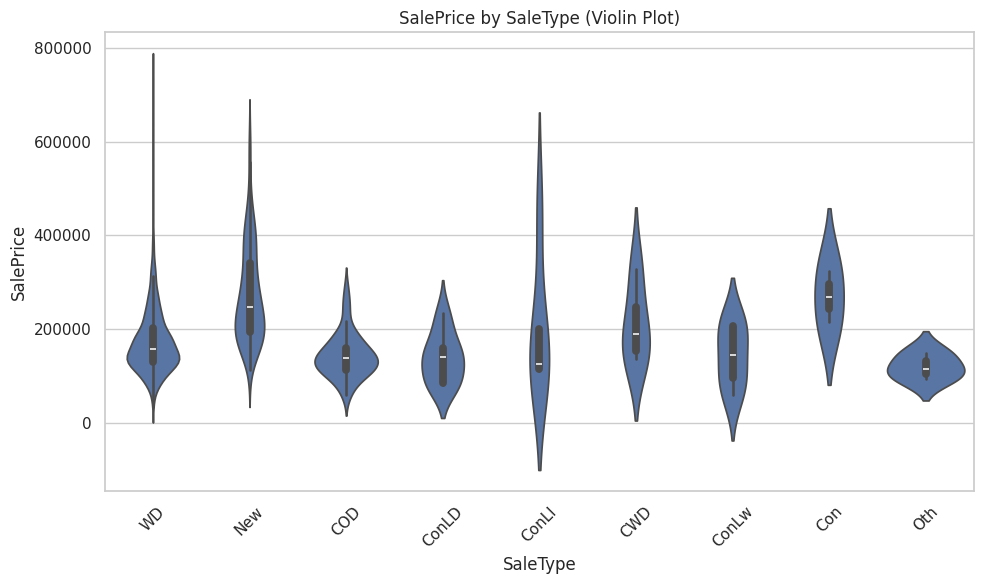

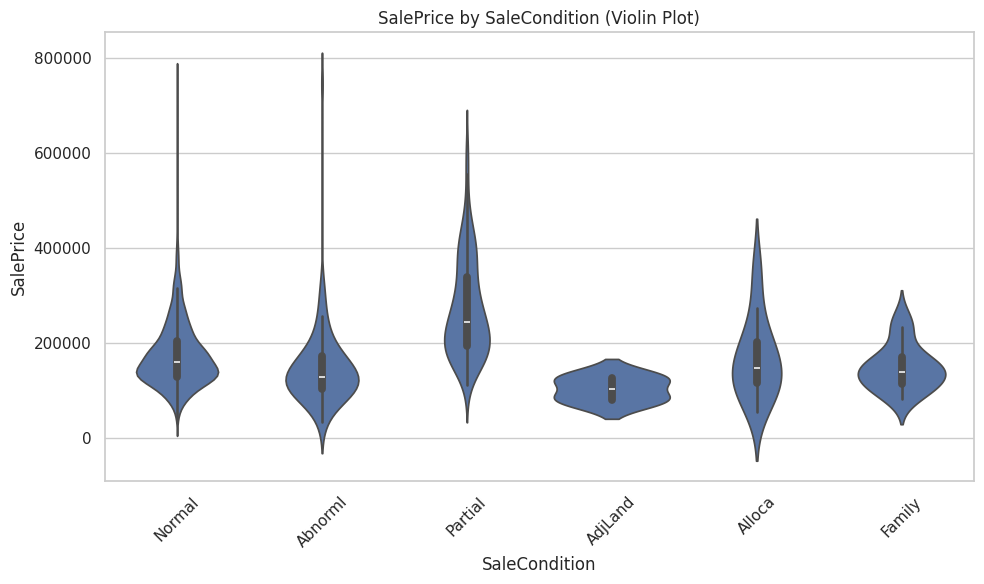

In [42]:
def plot_categorical_violin(df):
    categorical_features = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Set the style for better visualization
    sns.set(style="whitegrid")
    
    # Loop through each categorical feature and create a violin plot
    for feature in categorical_features:
        plt.figure(figsize=(10, 6))
        sns.violinplot(x=feature, y='SalePrice', data=df)
        plt.title(f'SalePrice by {feature} (Violin Plot)')
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
        plt.xticks(rotation=45)  # Rotate x-axis labels if needed
        plt.tight_layout()
plot_categorical_violin(train_df)

### Visualizing Numerical Features

Next, we'll visualize the relationship between numerical features and the target variable using scatter plots with regression lines. This helps identify linear relationships and potential outliers.

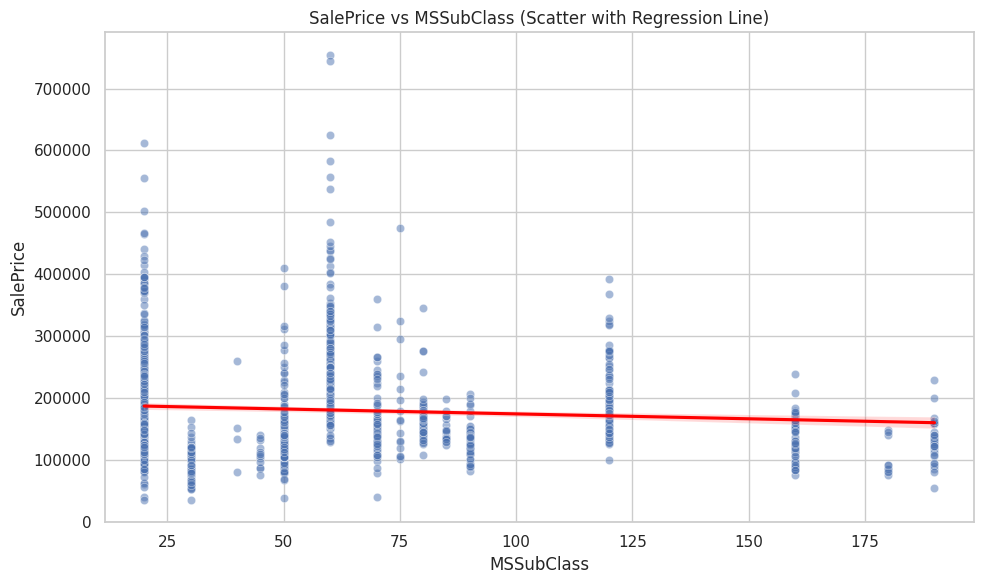

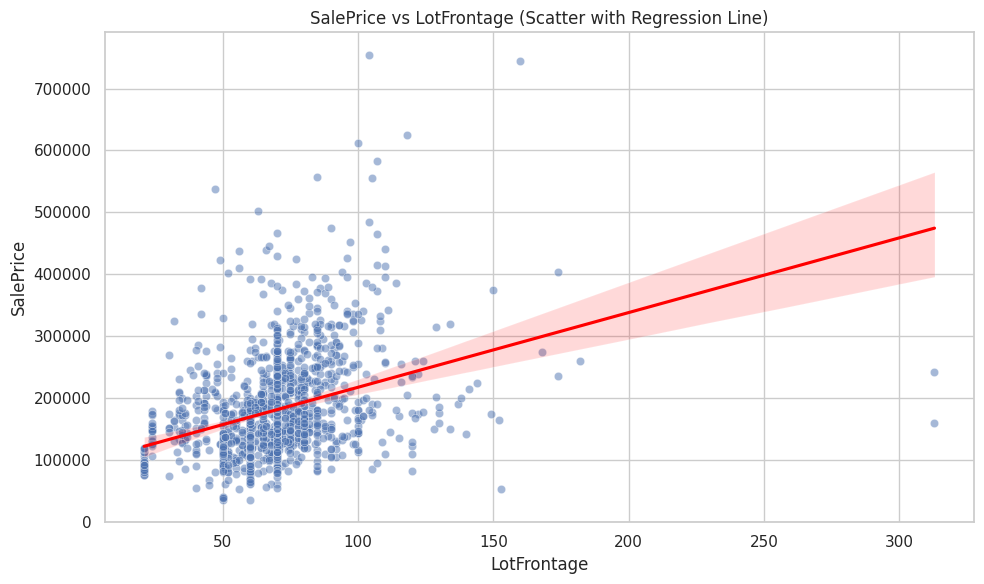

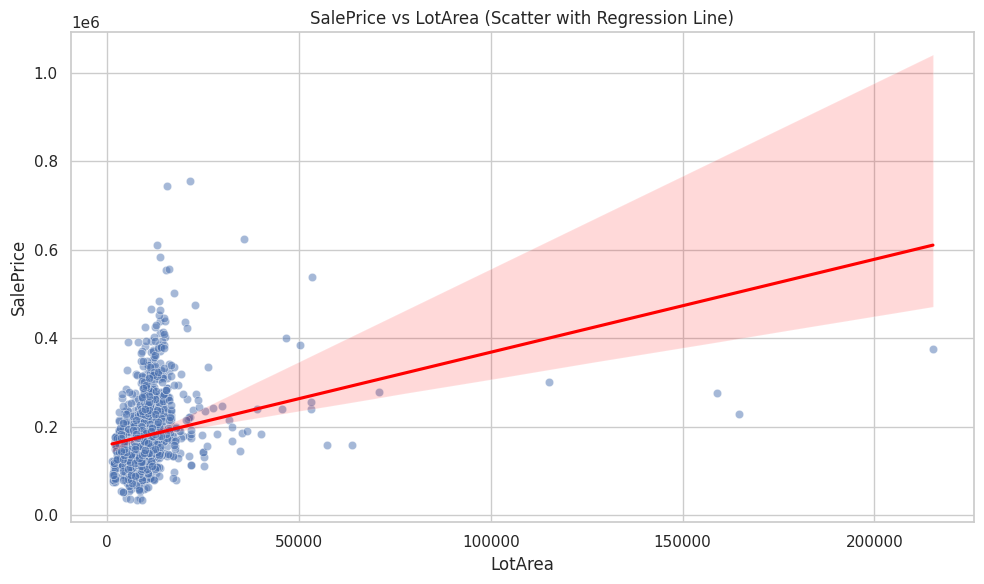

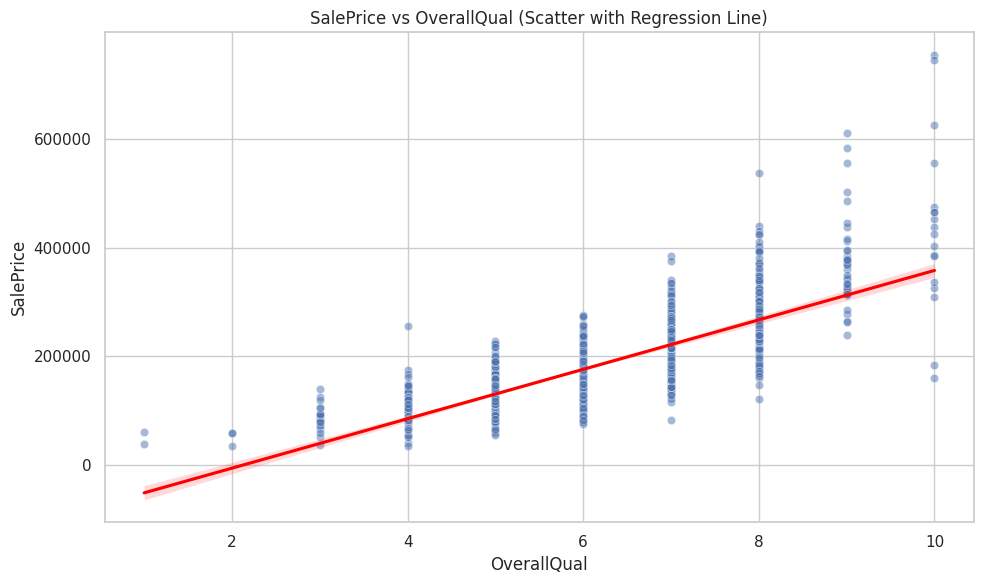

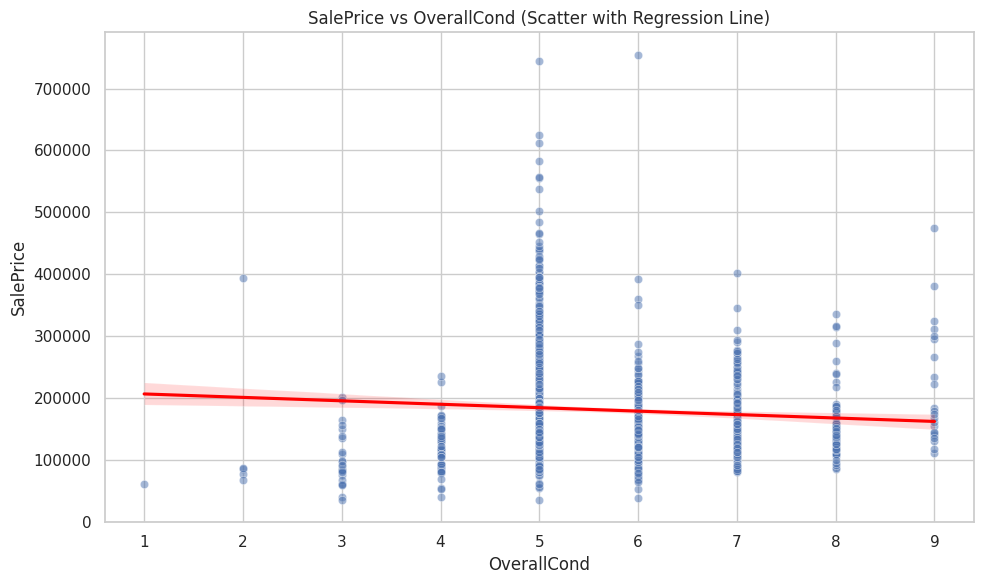

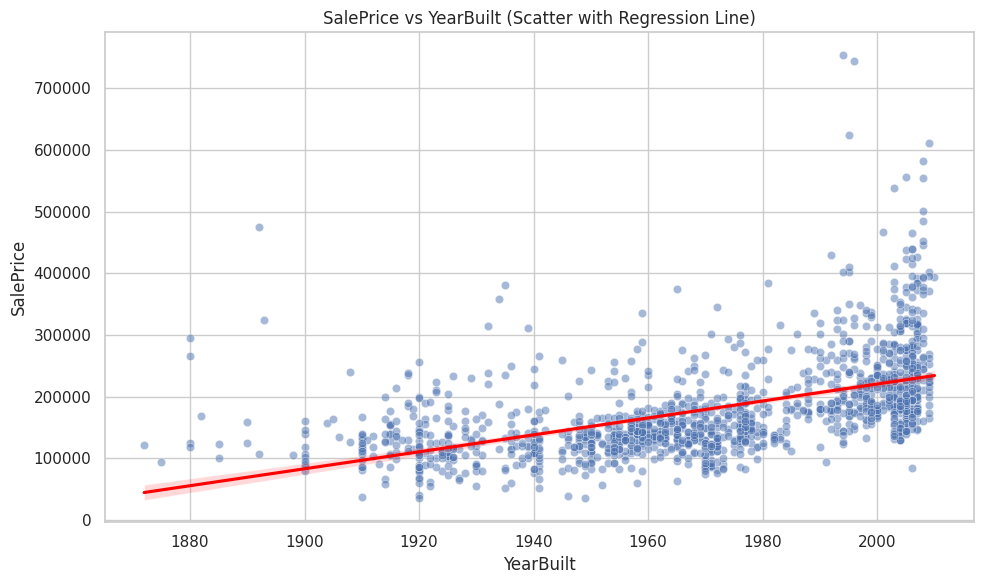

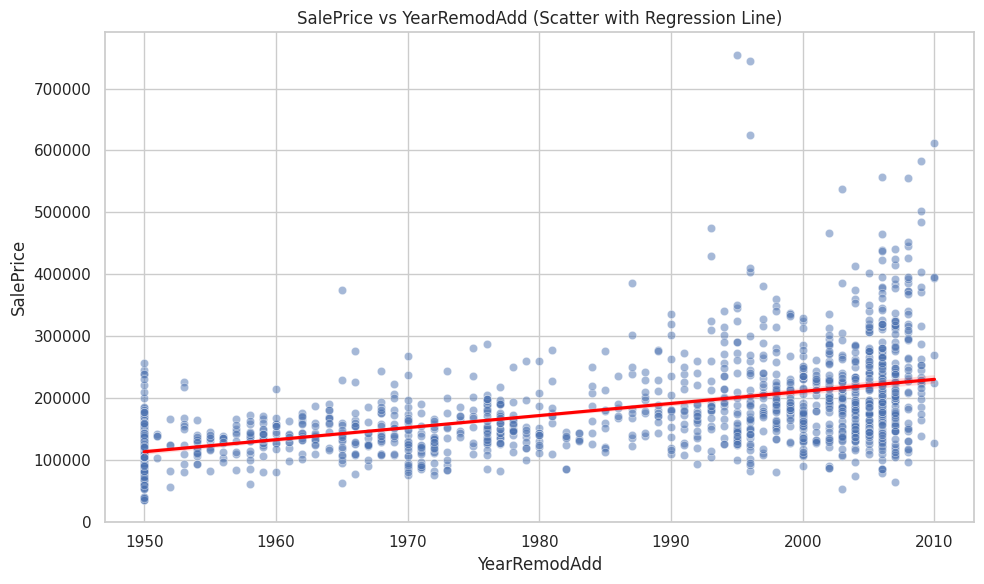

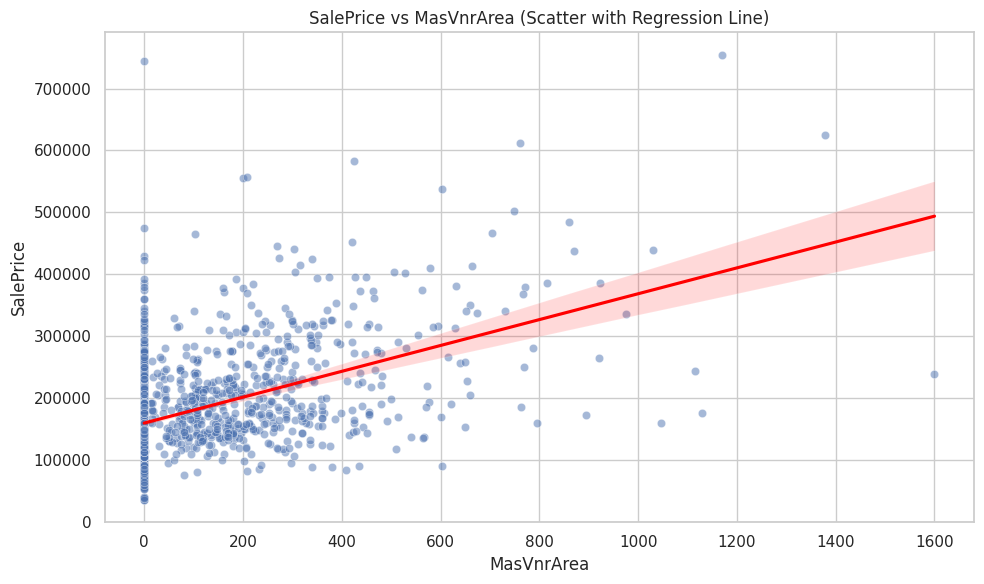

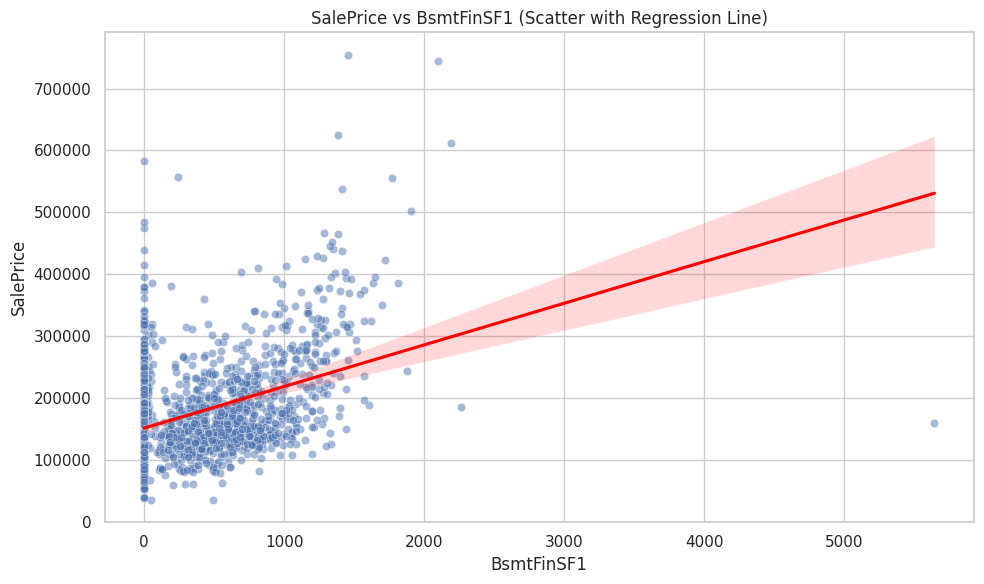

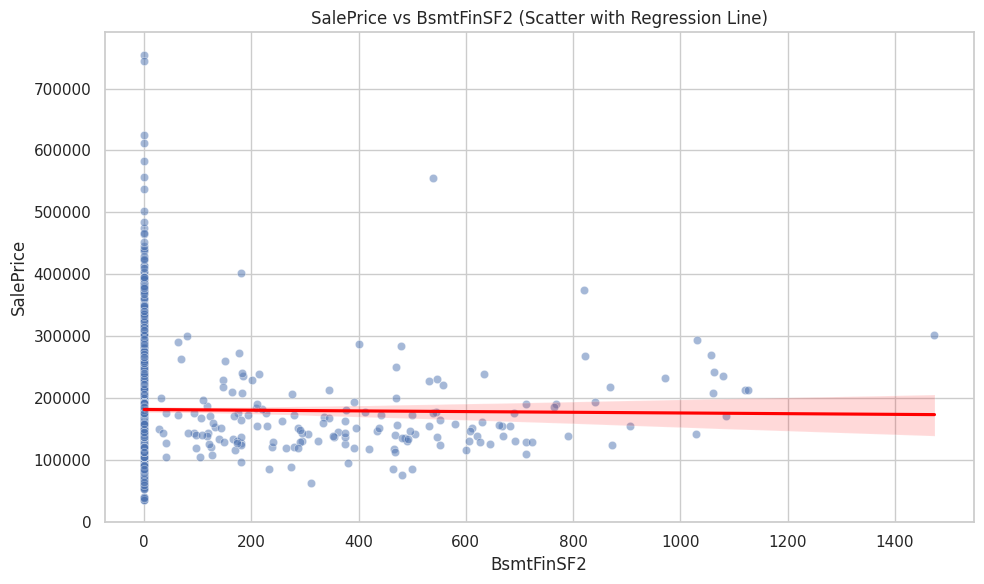

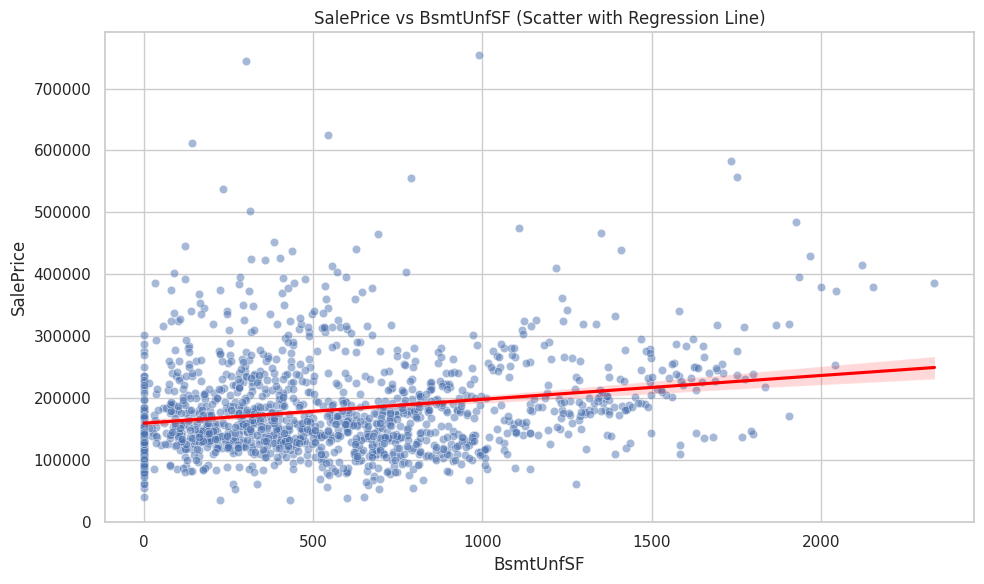

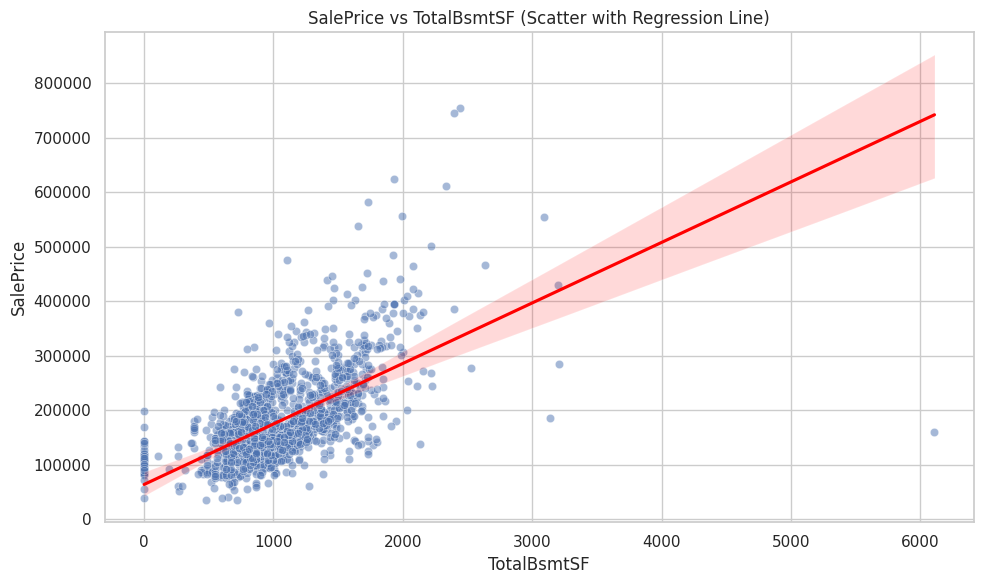

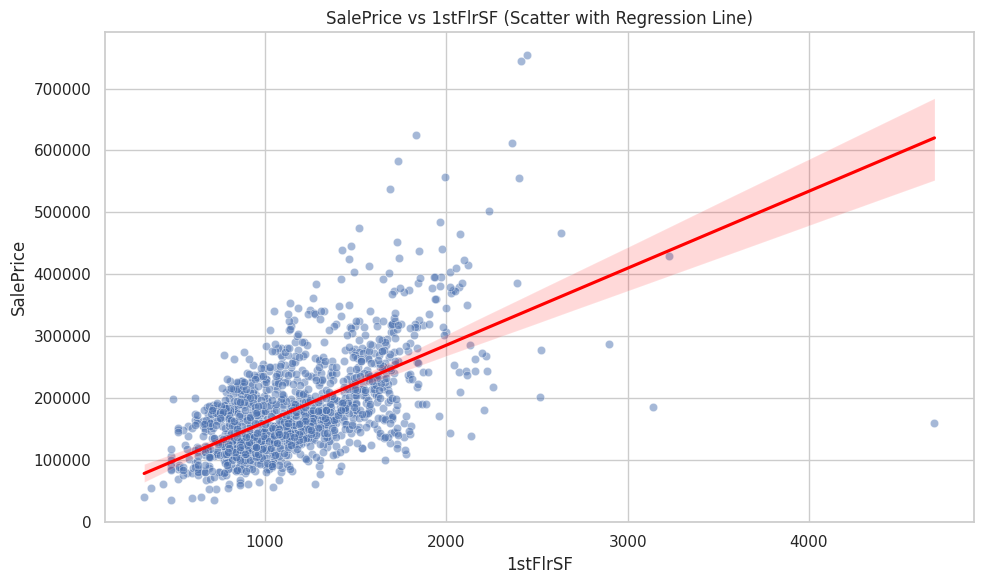

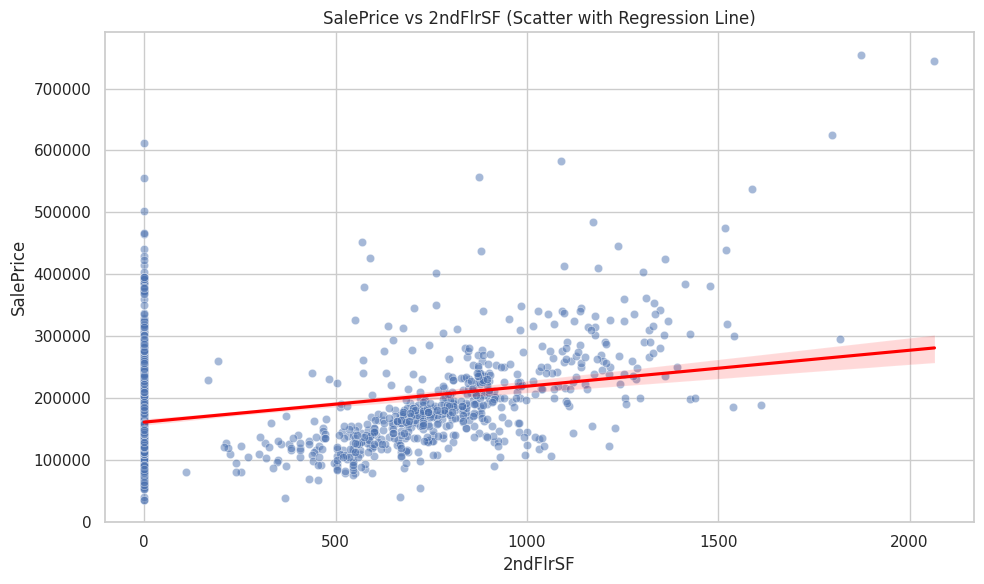

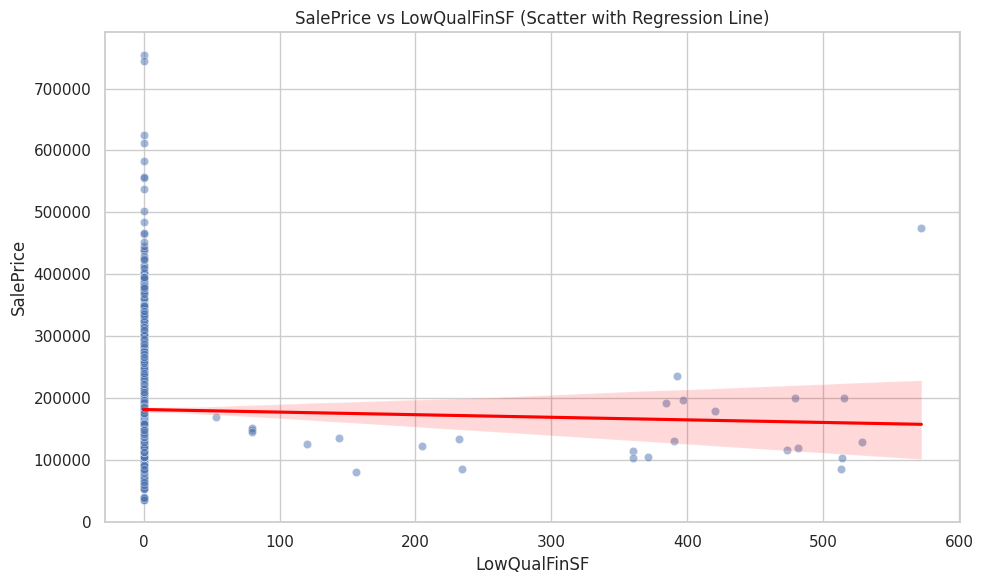

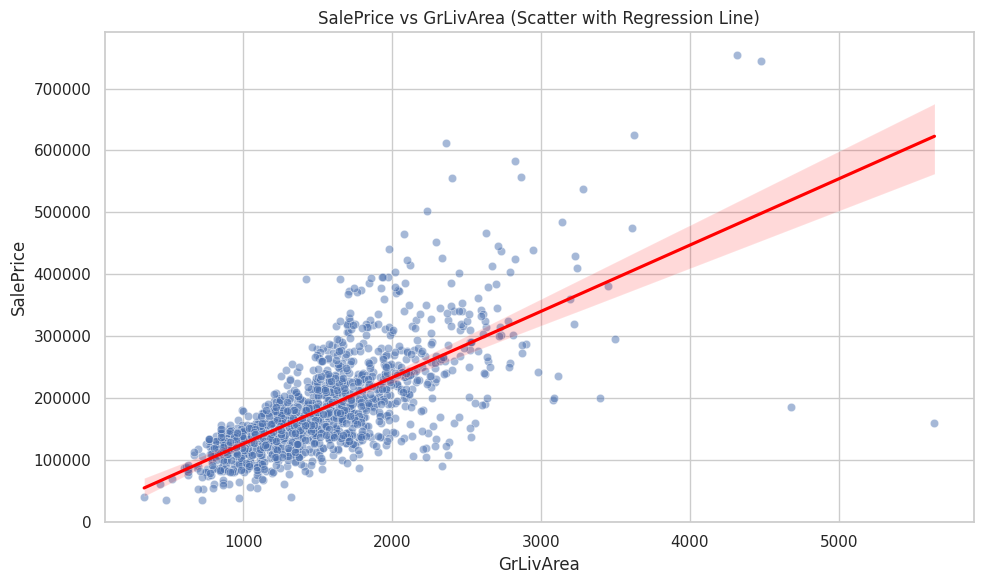

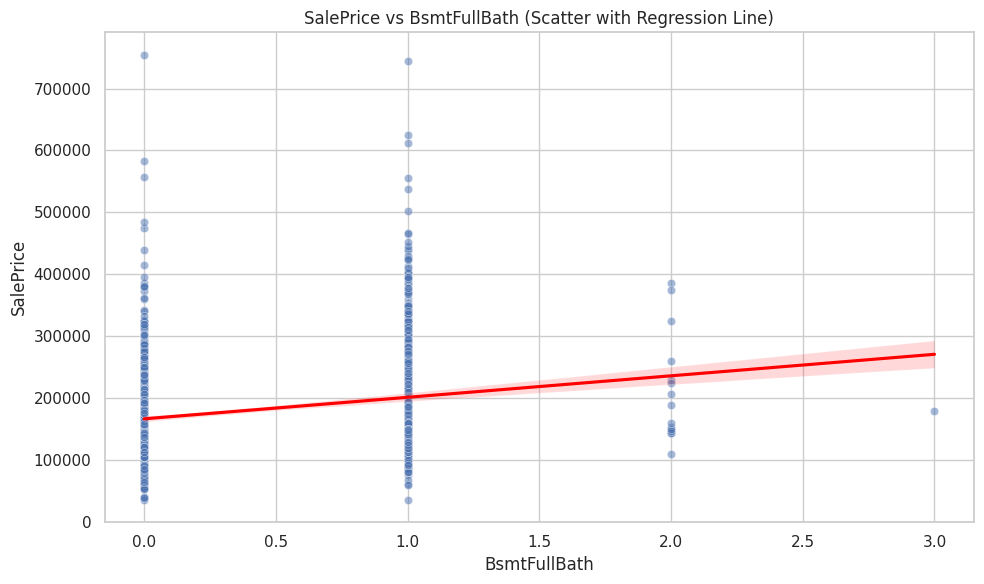

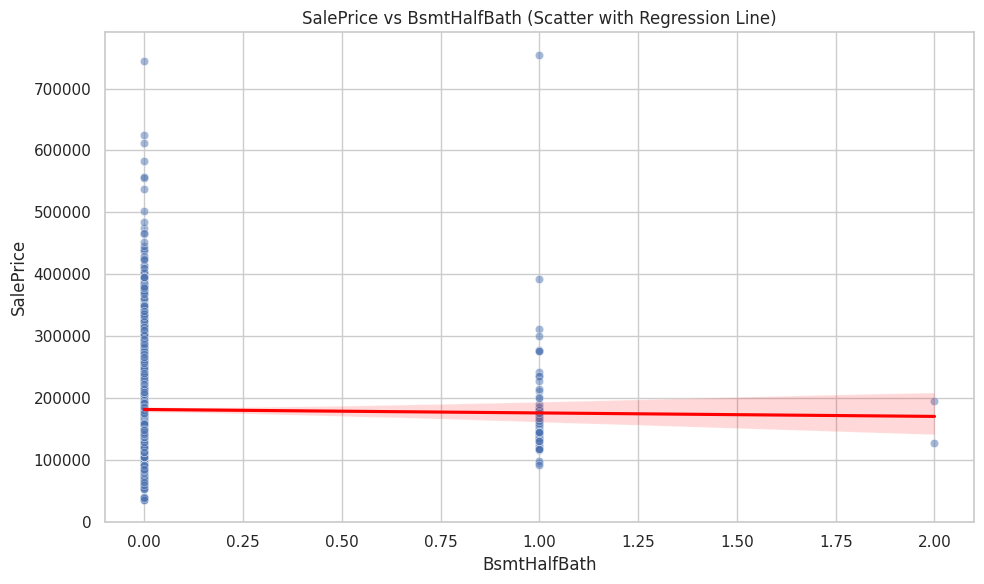

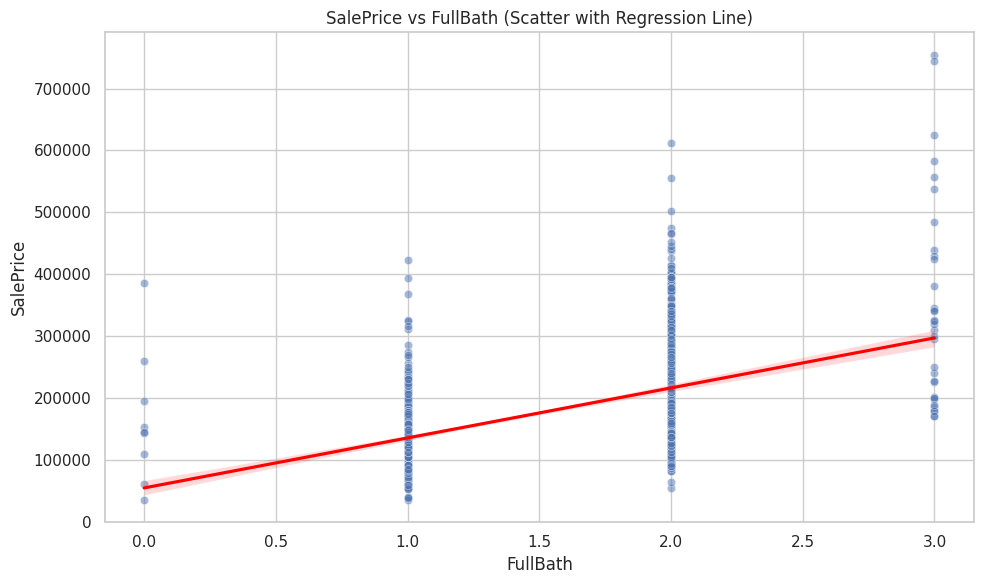

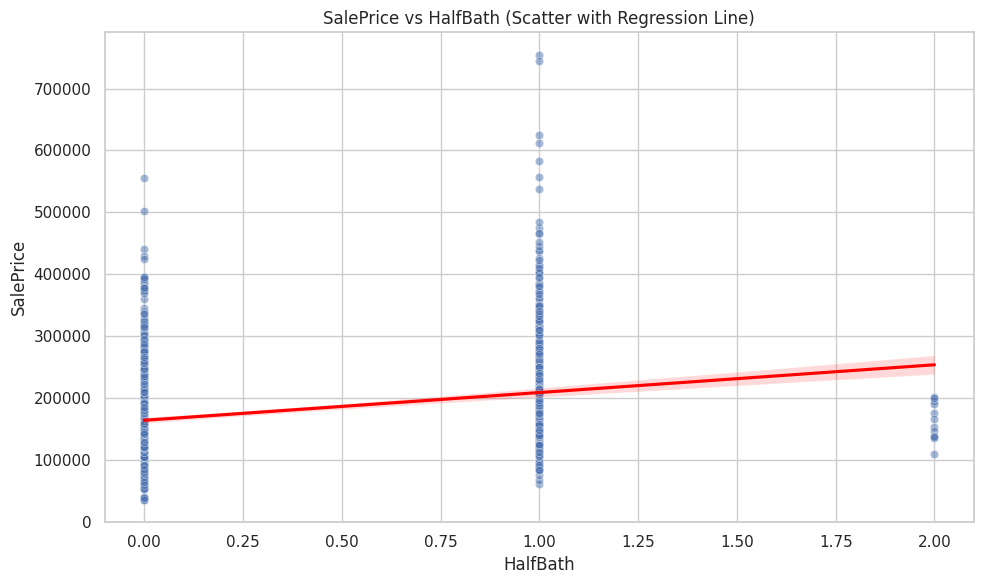

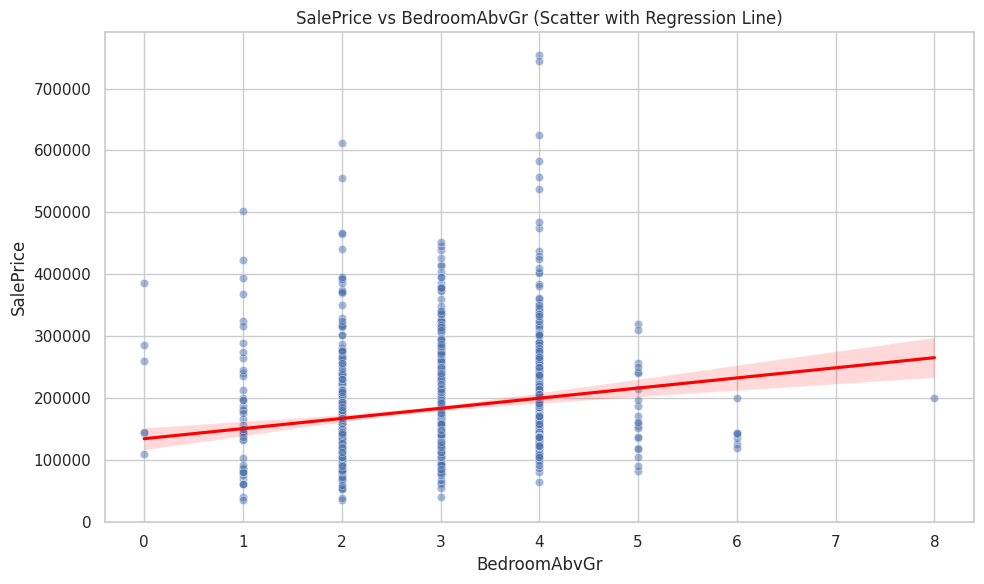

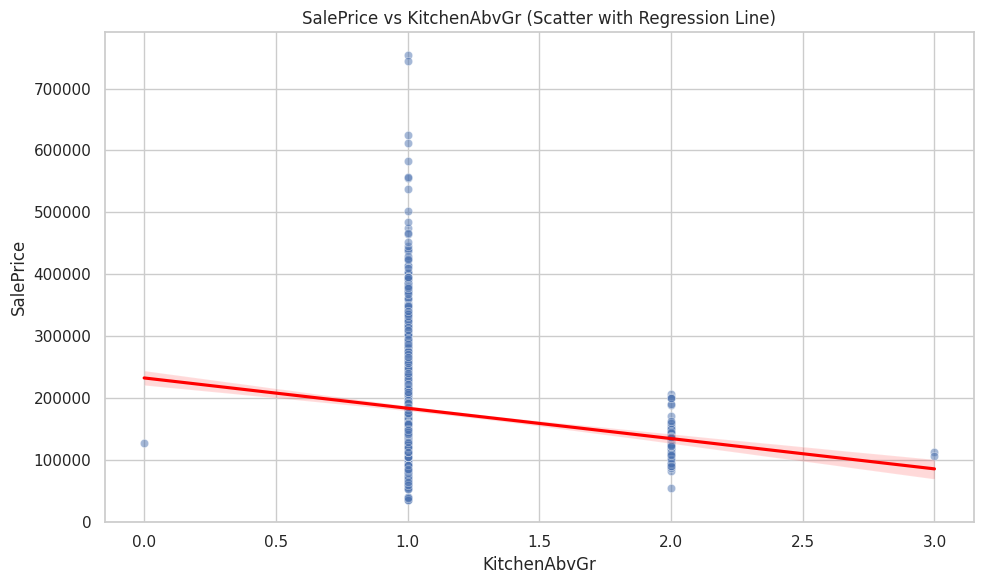

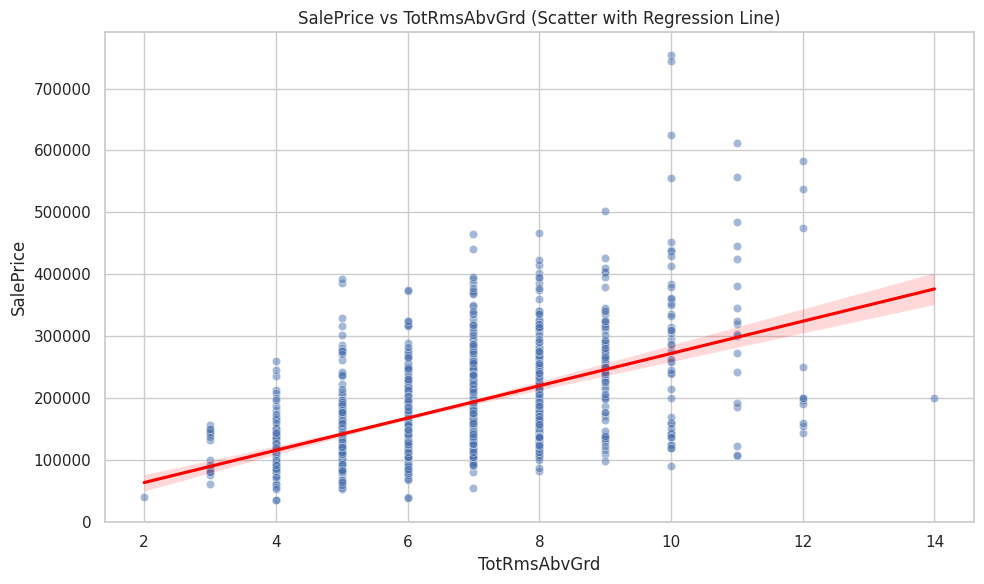

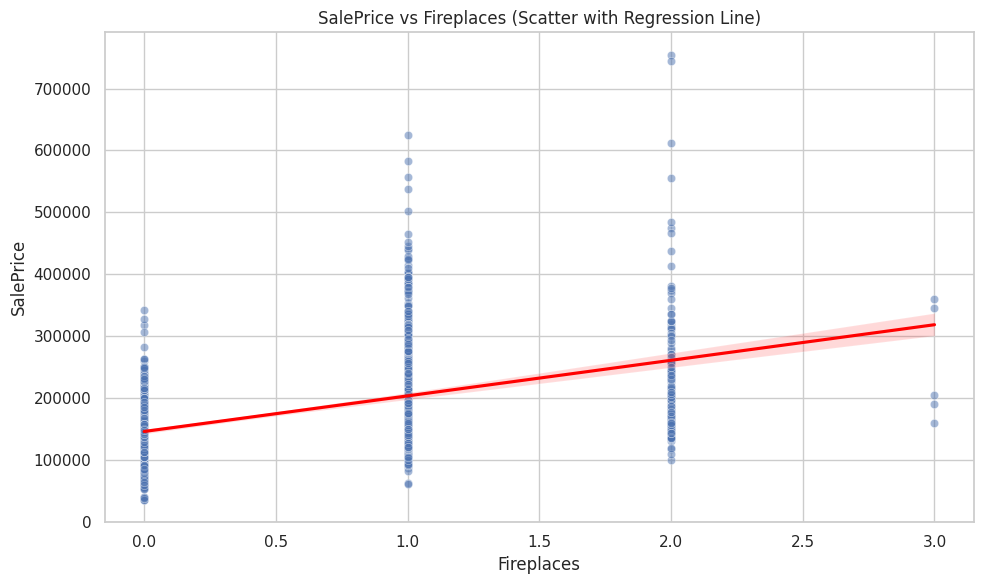

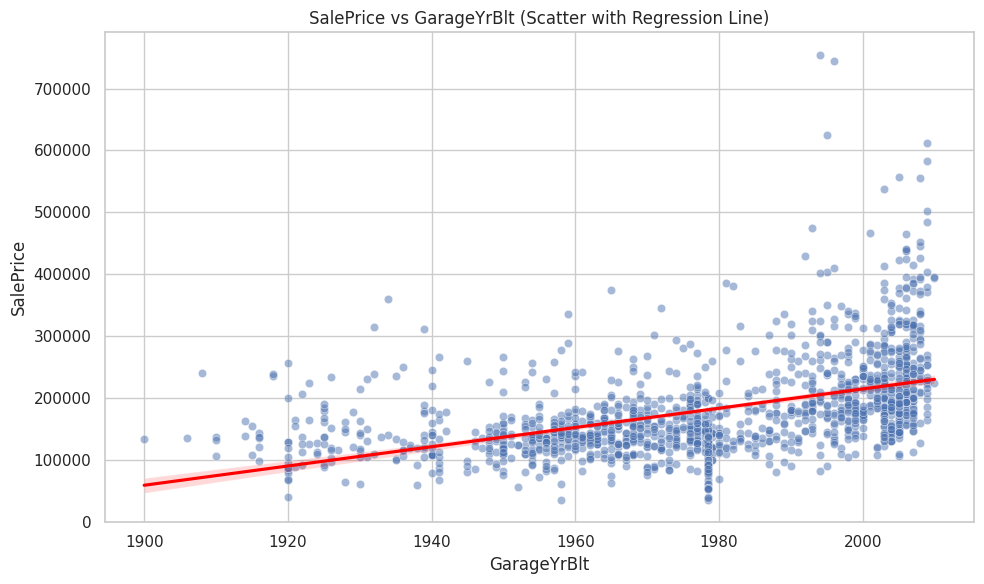

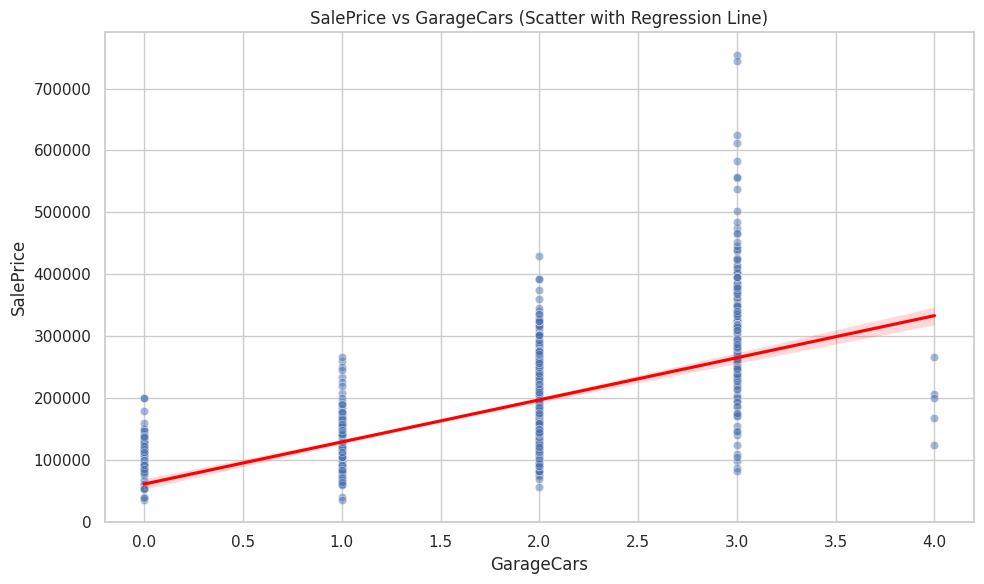

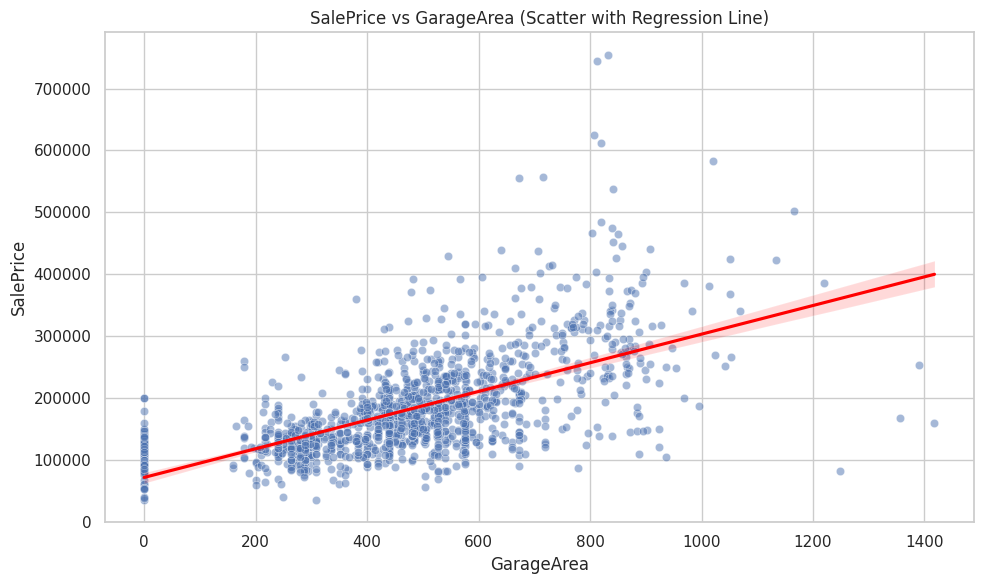

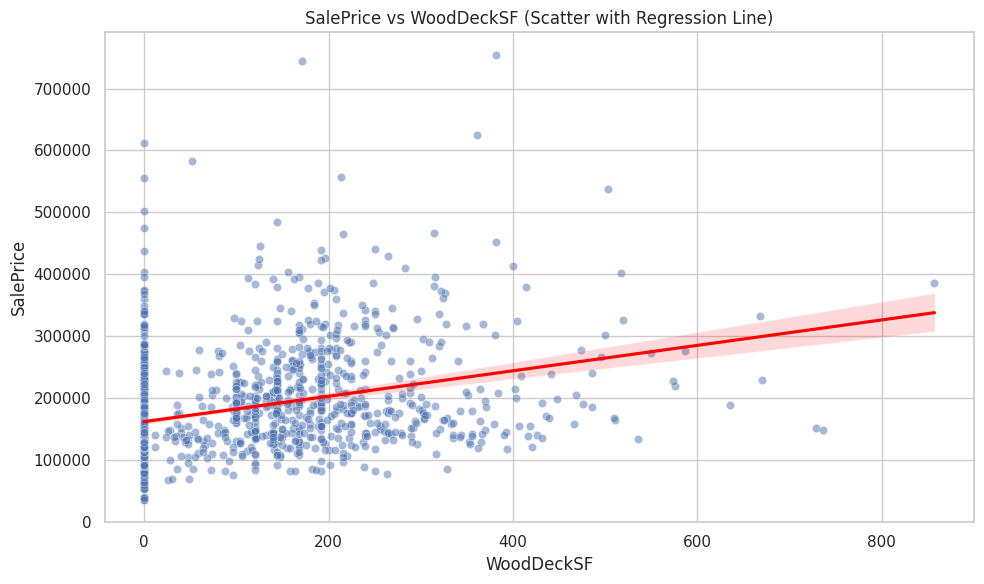

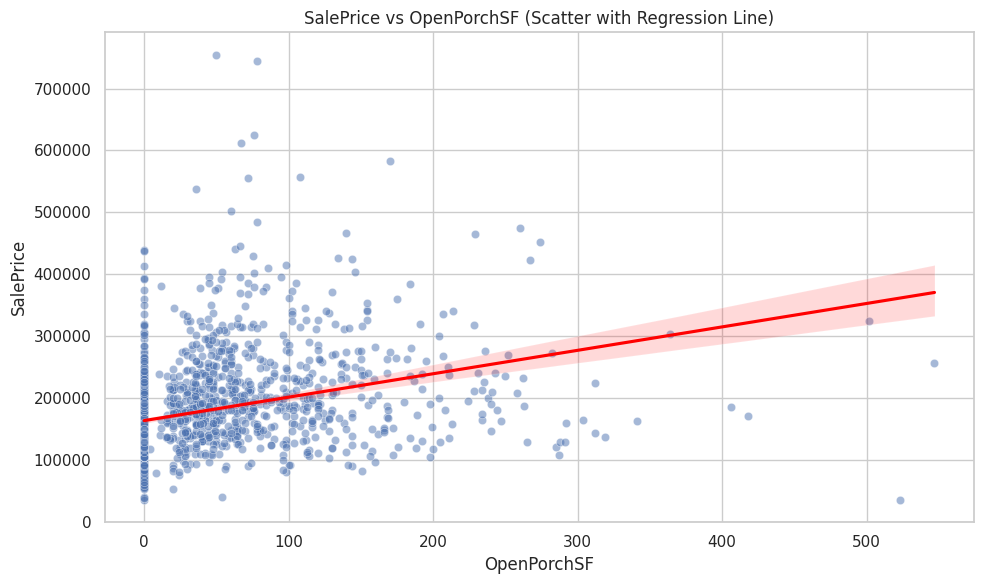

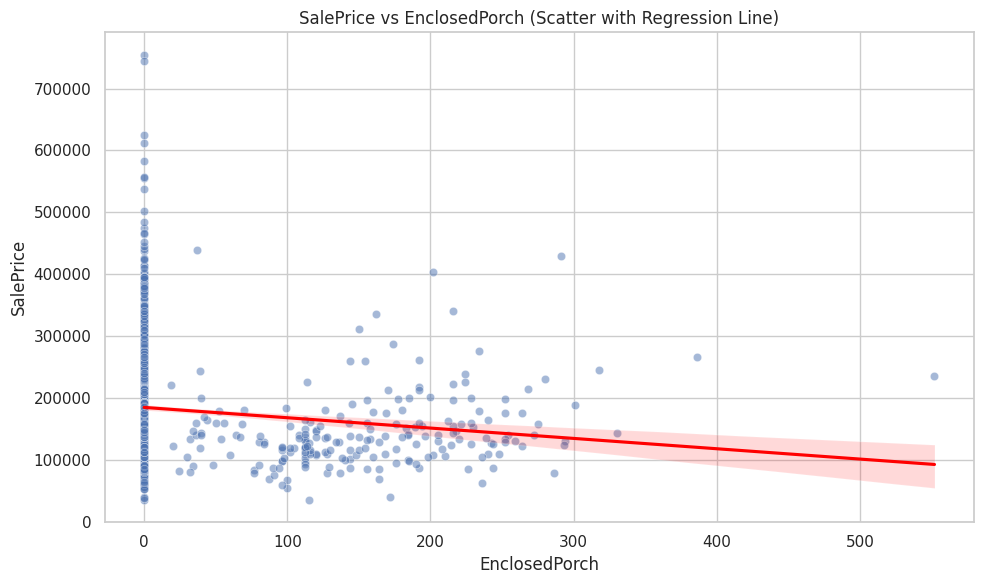

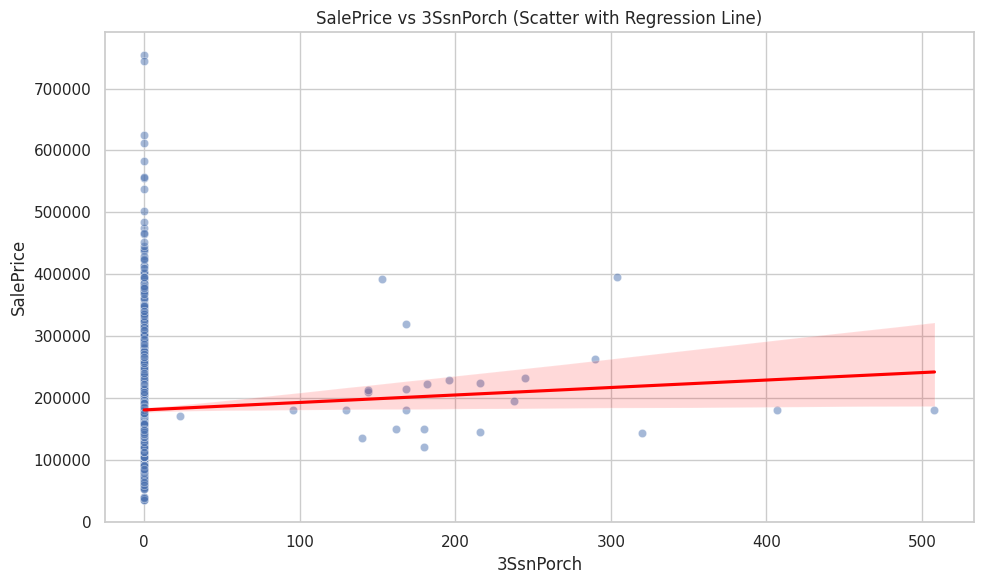

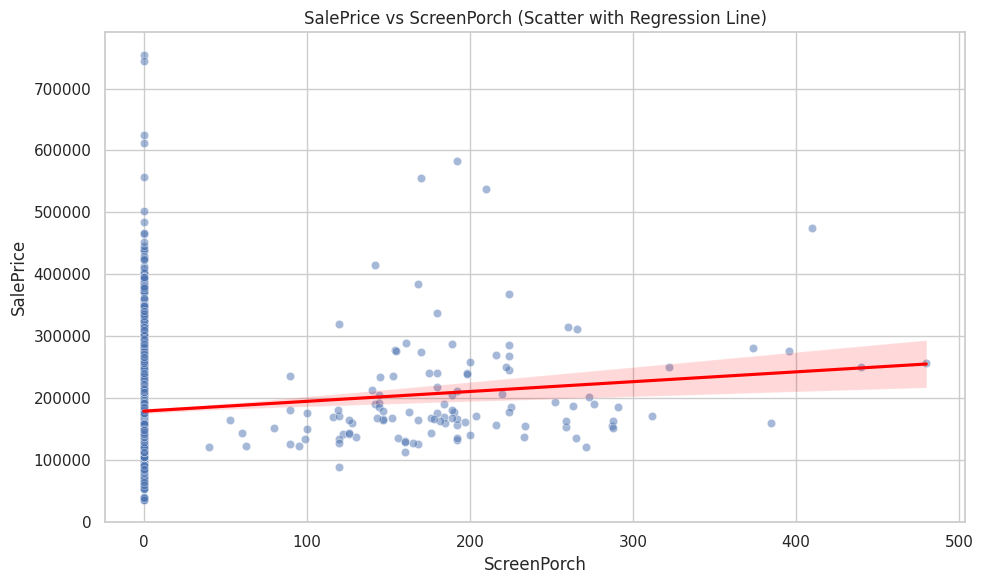

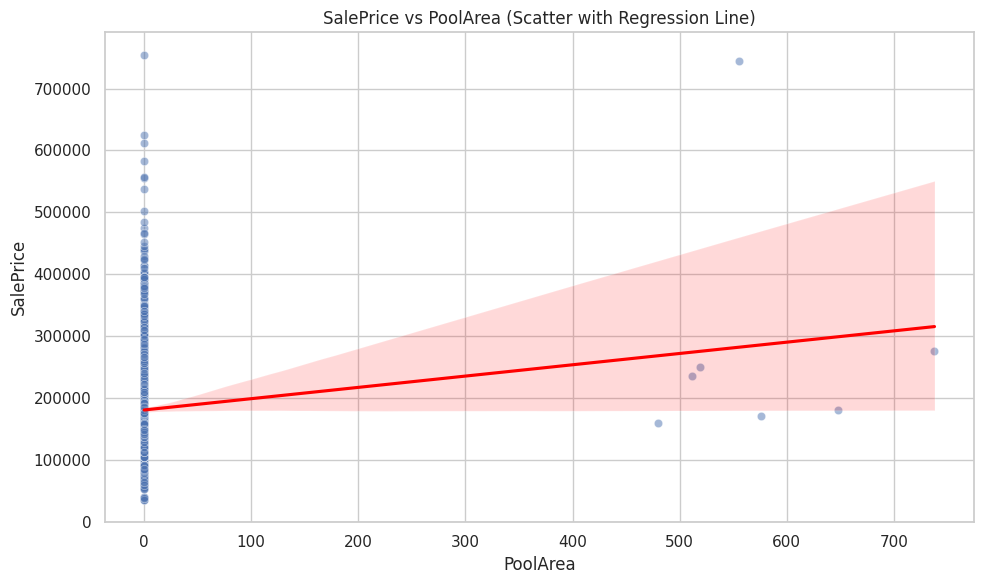

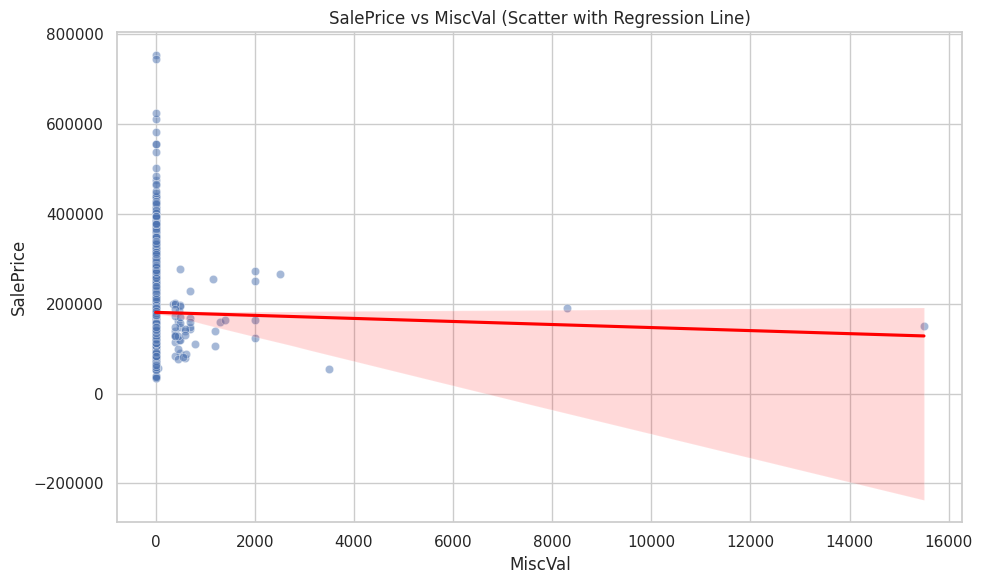

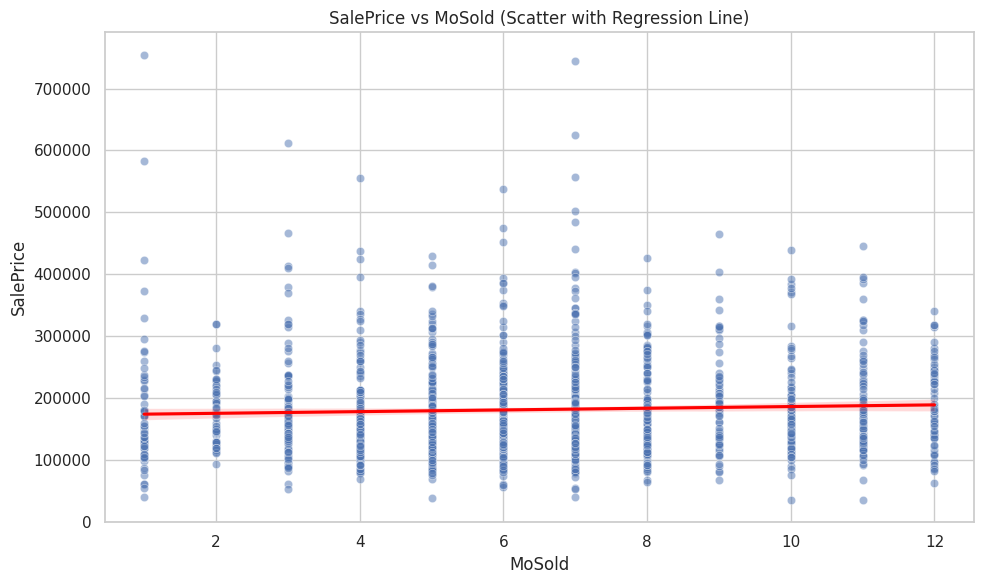

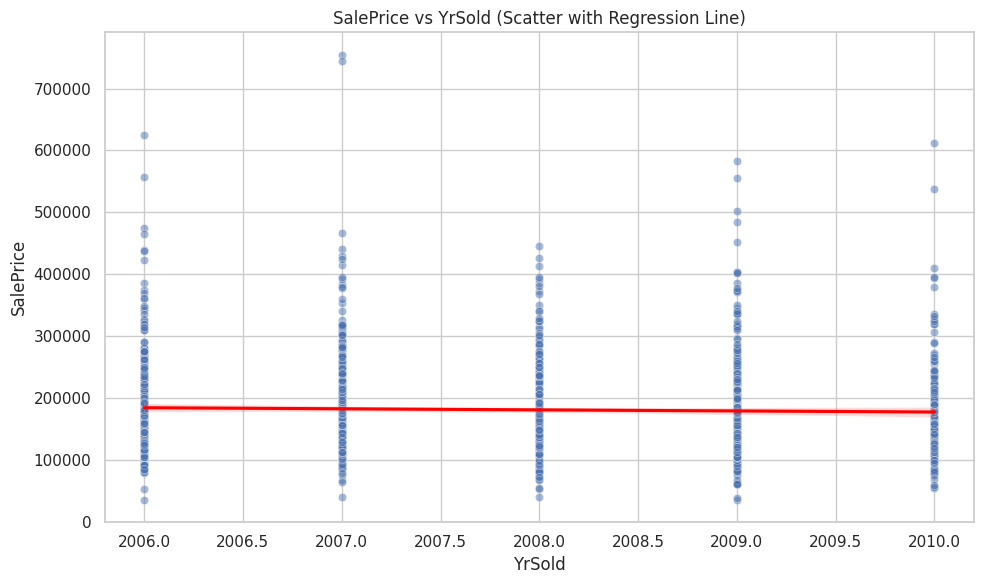

In [43]:
def plot_numerical_scatter(df):
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Remove 'SalePrice' and 'Id' from numerical features if it's there
    if 'SalePrice' in numerical_features:
        numerical_features.remove('SalePrice')
        numerical_features.remove('Id')
    
    # Set the style for better visualization
    sns.set(style="whitegrid")
    
    # Create scatter plots with regression lines for each numerical feature
    for feature in numerical_features:
        plt.figure(figsize=(10, 6))
        # Scatter plot with transparency to handle overlapping points
        sns.scatterplot(x=feature, y='SalePrice', data=df, alpha=0.5)
        # Add regression line (linear fit)
        sns.regplot(x=feature, y='SalePrice', data=df, scatter=False, color='red')
        plt.title(f'SalePrice vs {feature} (Scatter with Regression Line)')
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
        plt.tight_layout()
plot_numerical_scatter(train_df)

### Examining Dataset Structure

Let's check the columns in our dataset before proceeding with further feature selection.

In [44]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'Enclo

### Removing Low-Value Features

Based on our visualizations and understanding of the data, we'll remove features that show minimal correlation with the target variable or have limited predictive value. This helps reduce dimensionality and focus on the most important predictors.

In [45]:
columns_to_drop = [
    "MSSubClass",
    "OverallCond",
    "BsmtFinSF2",
    "LowQualFinSF",
    "BsmtHalfBath",
    "HalfBath",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "MoSold",
    "YrSold",
    "Utilities",
    "LotConfig"
]
create_and_save_plots(columns_to_drop, train_df)
train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)
log_plots_from_directory('dropped_column_plots')
log_feature_step('remove_non_correlated', 'Removed columns which had minimal influence on the saleprice, considering analyisis on plots')

KeyError: 'MSSubClass'

### Removing ID Column

The ID column doesn't provide any predictive information, so we'll remove it from both datasets.

In [46]:
#drop Id column
train_df = train_df.drop(columns=['Id'])
test_df = test_df.drop(columns=['Id'])

### Analyzing Categorical Features Distribution

Let's examine the distribution of values in our categorical features to identify potential issues like rare categories or imbalanced distributions.

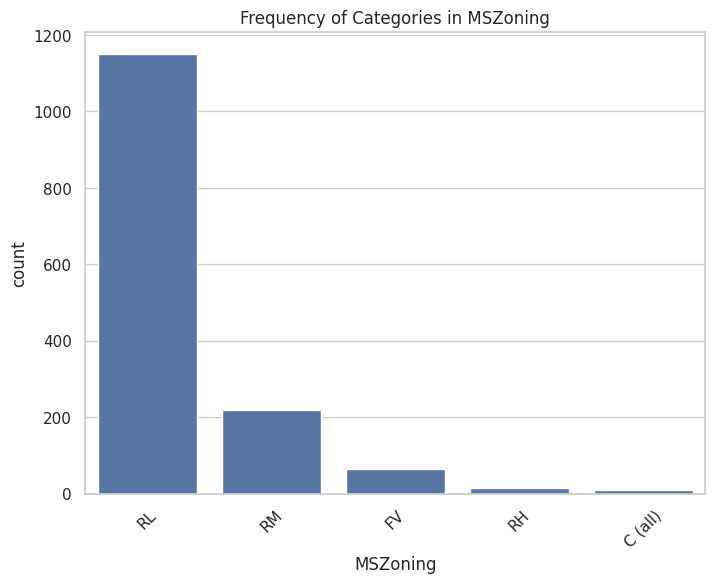

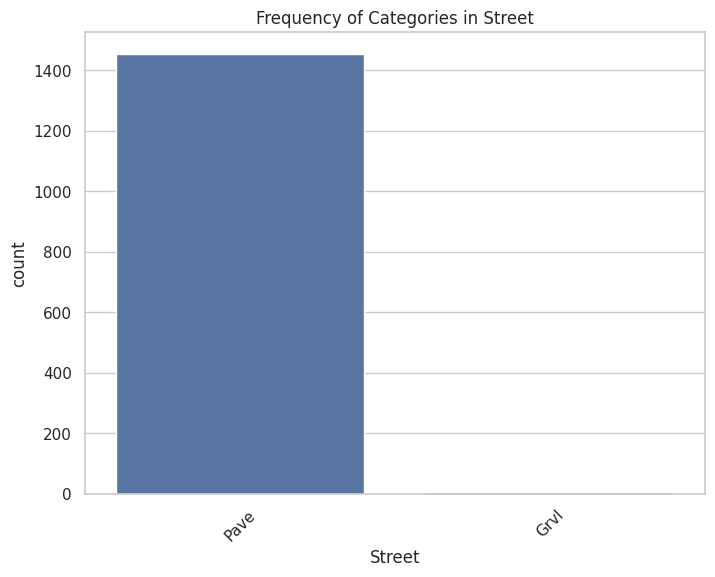

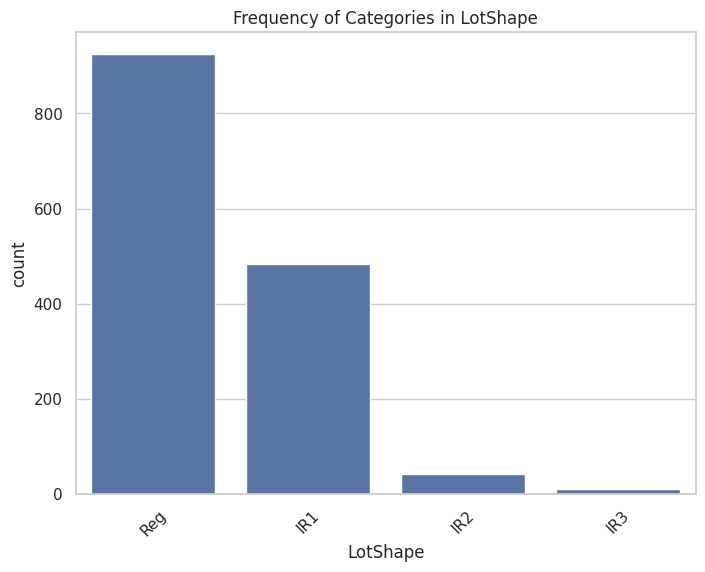

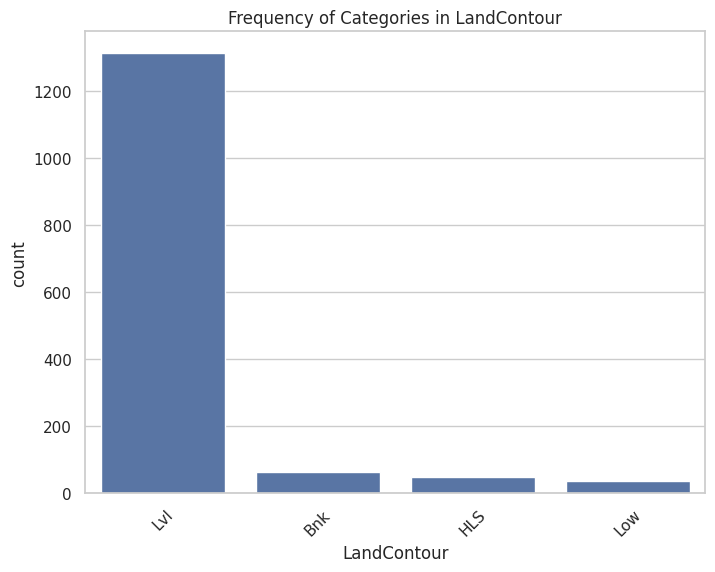

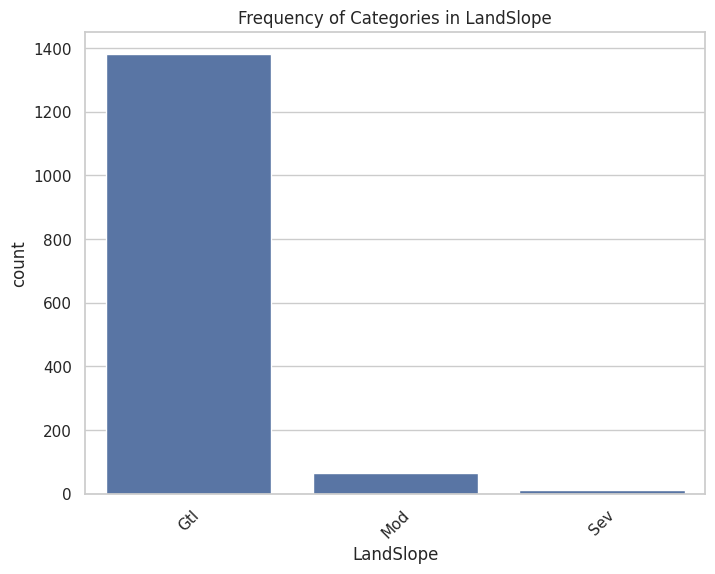

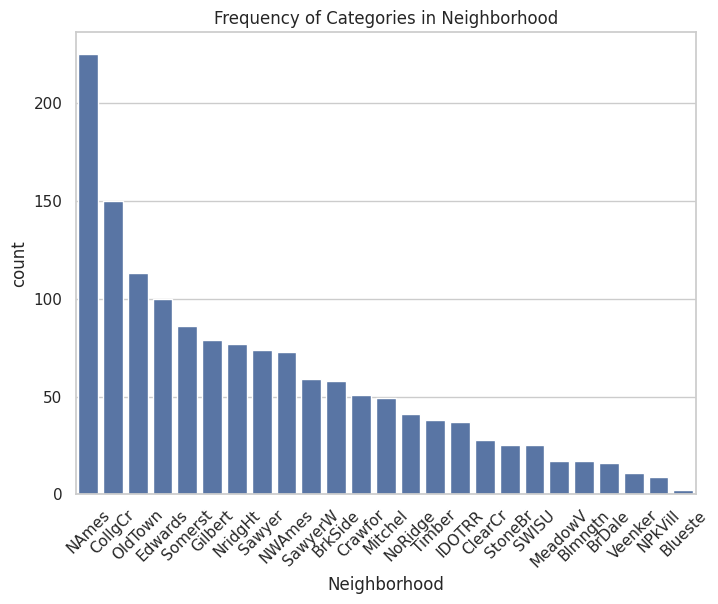

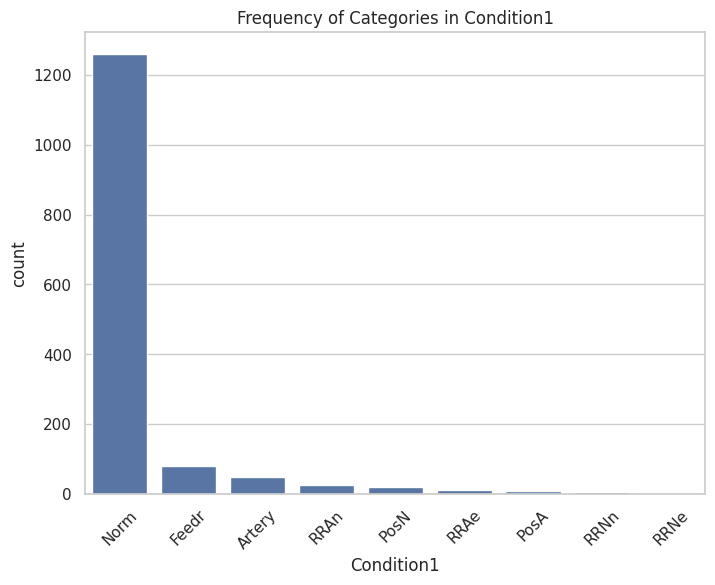

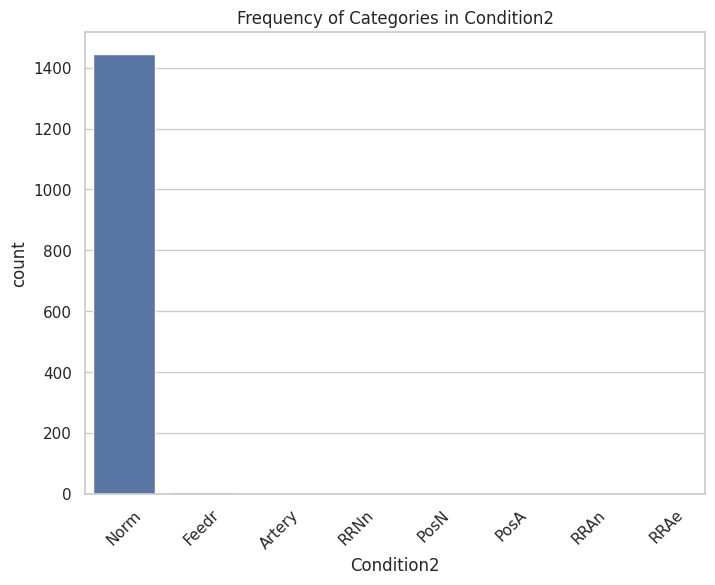

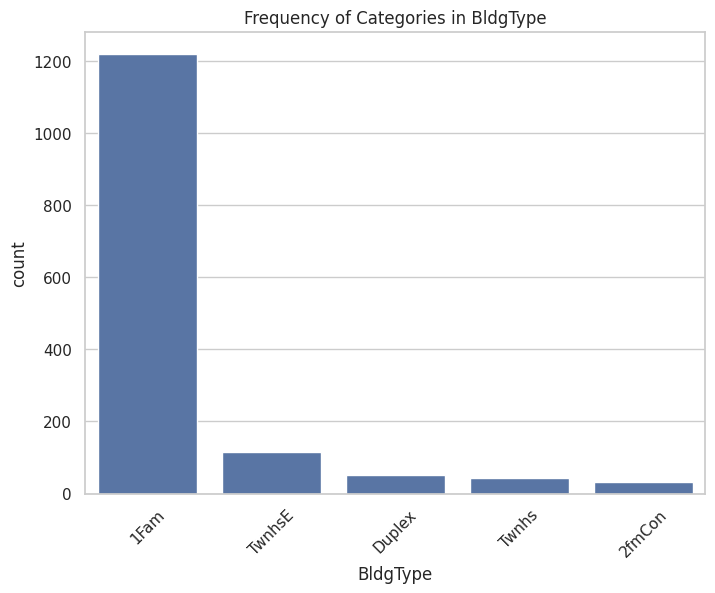

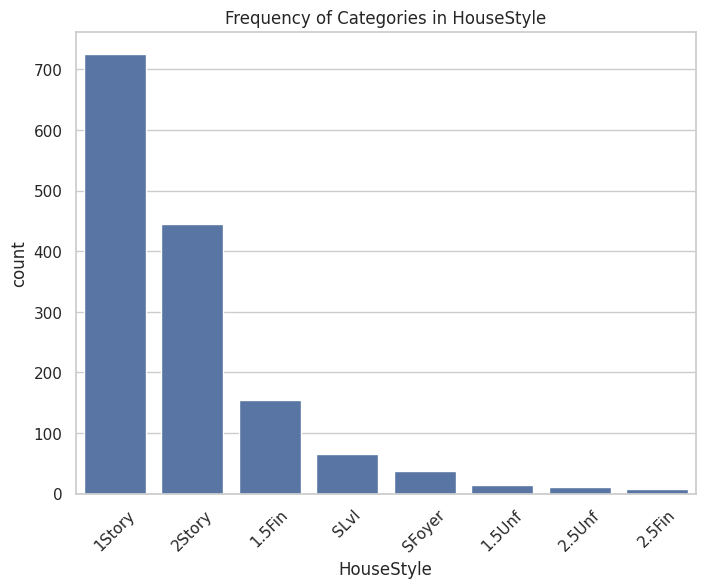

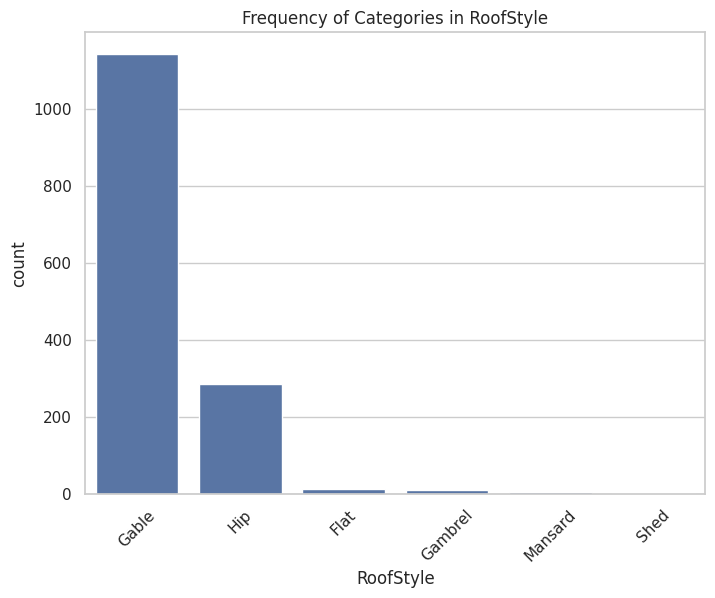

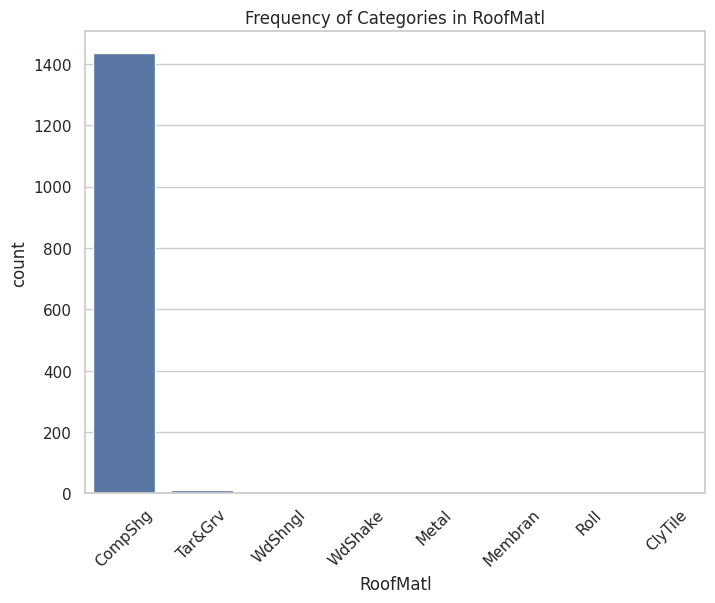

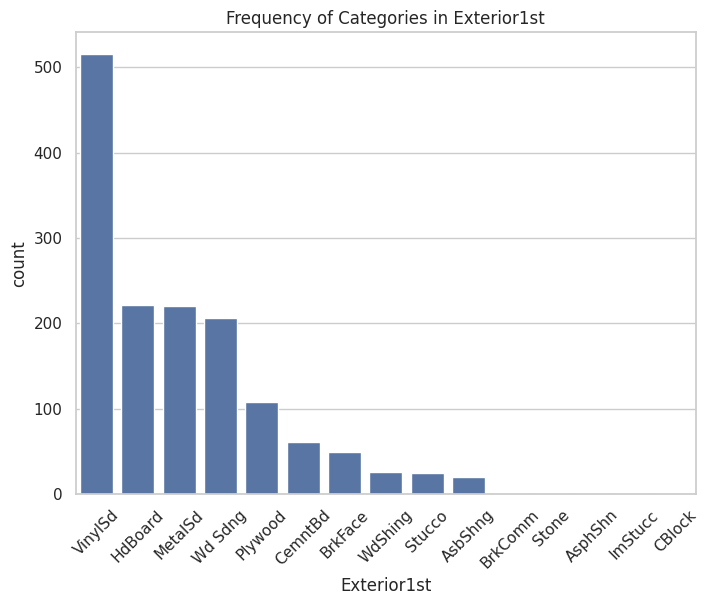

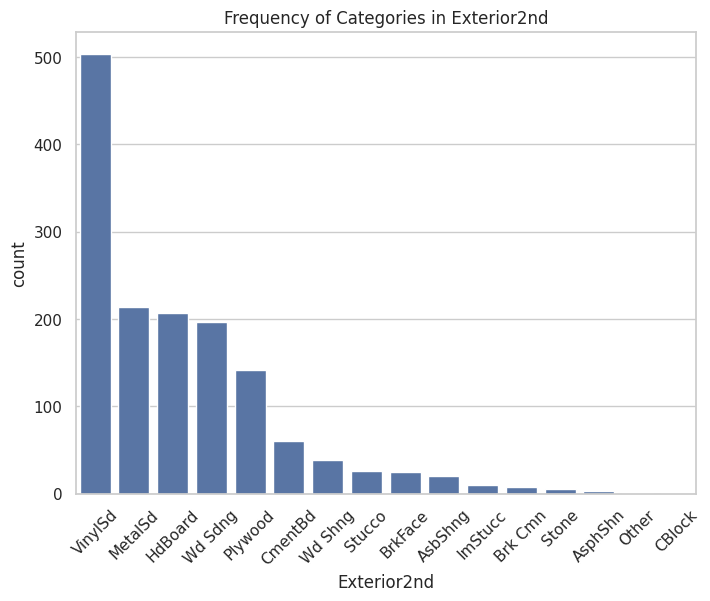

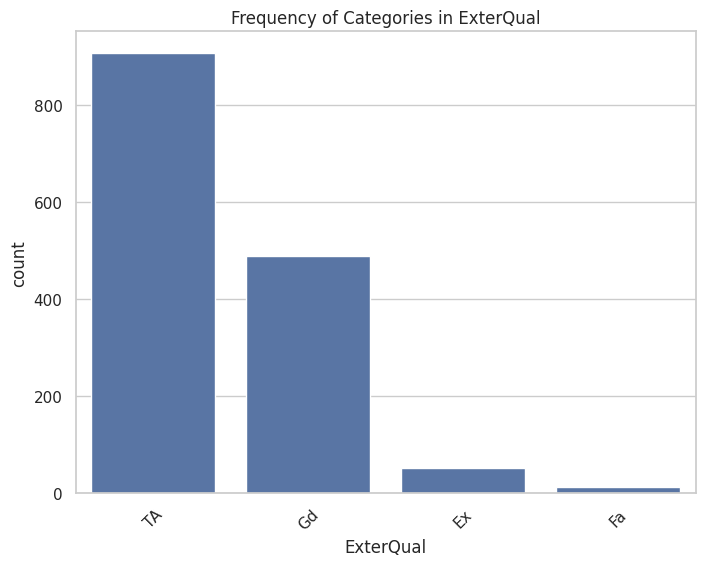

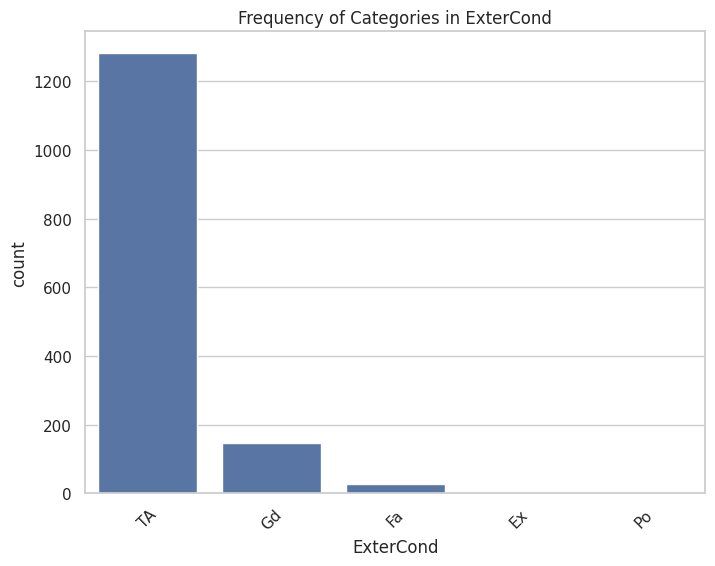

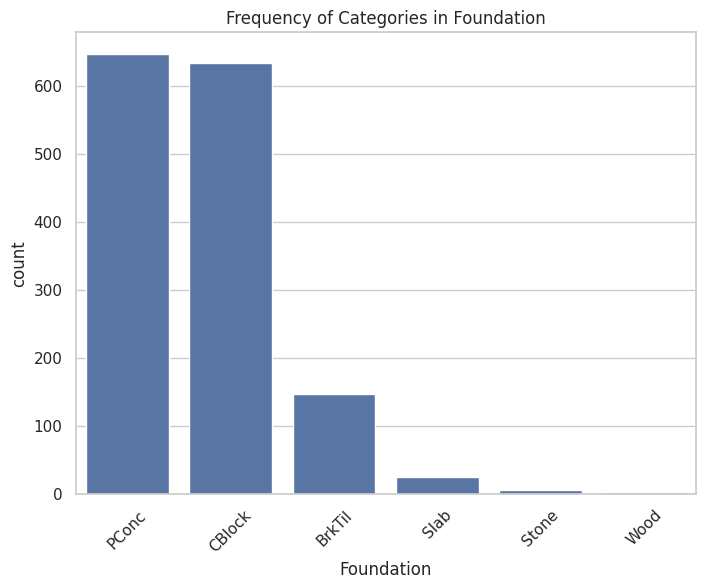

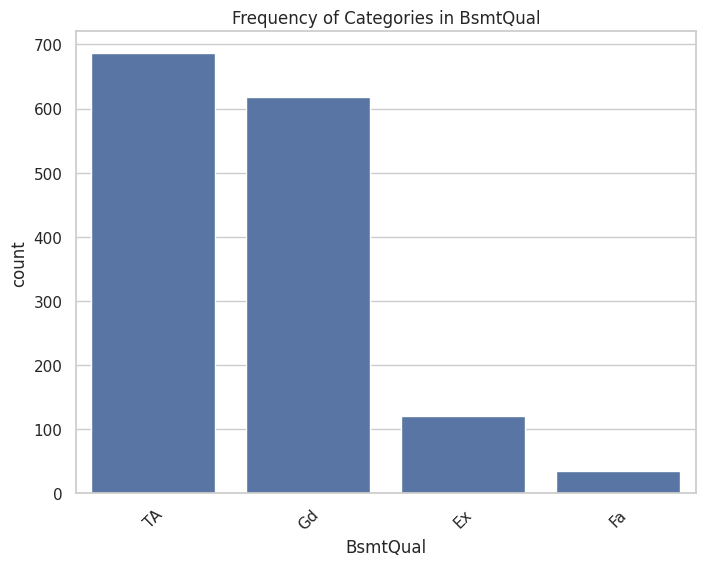

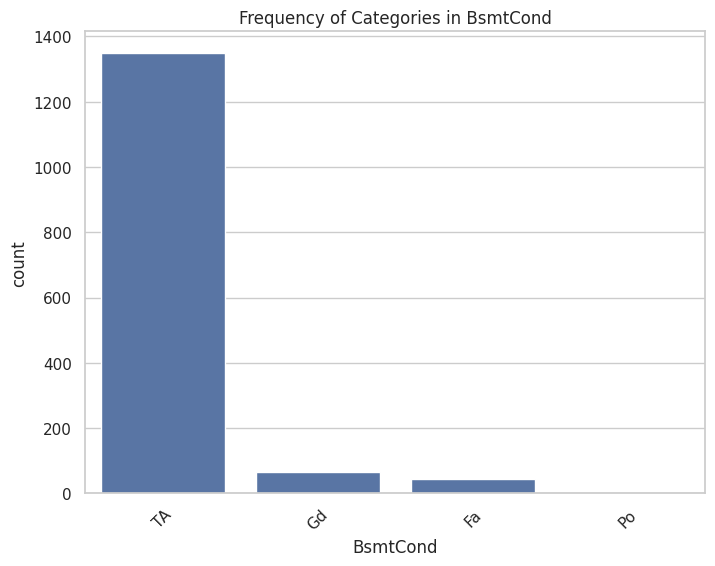

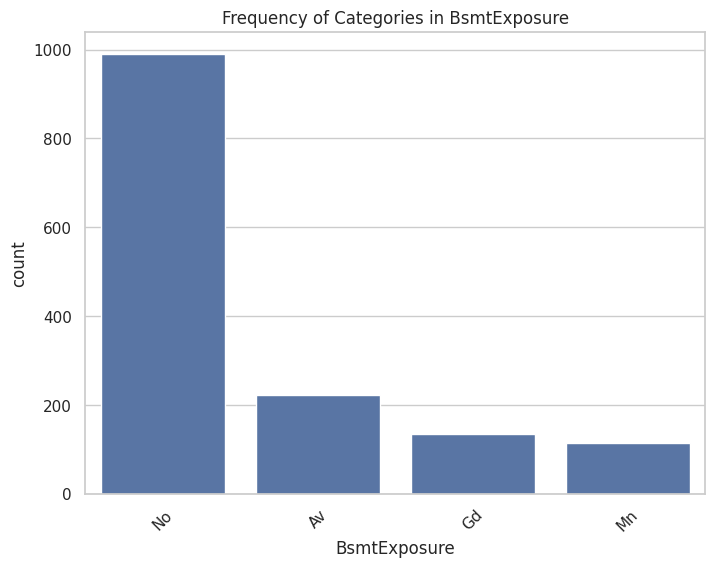

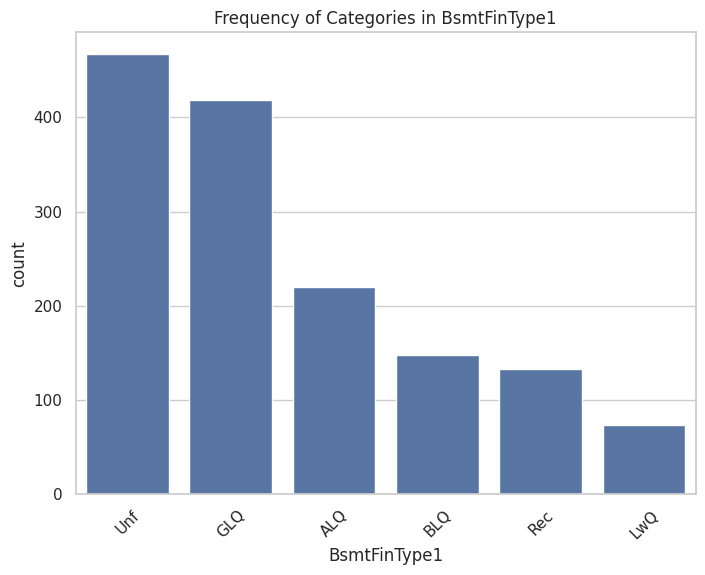

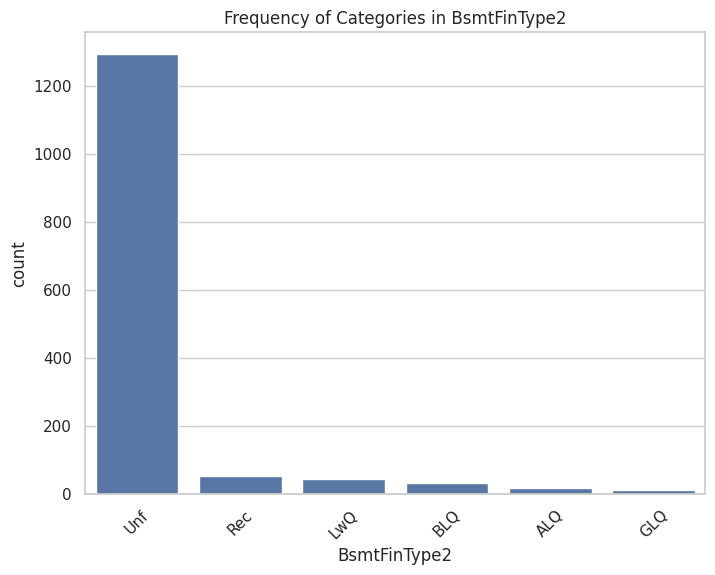

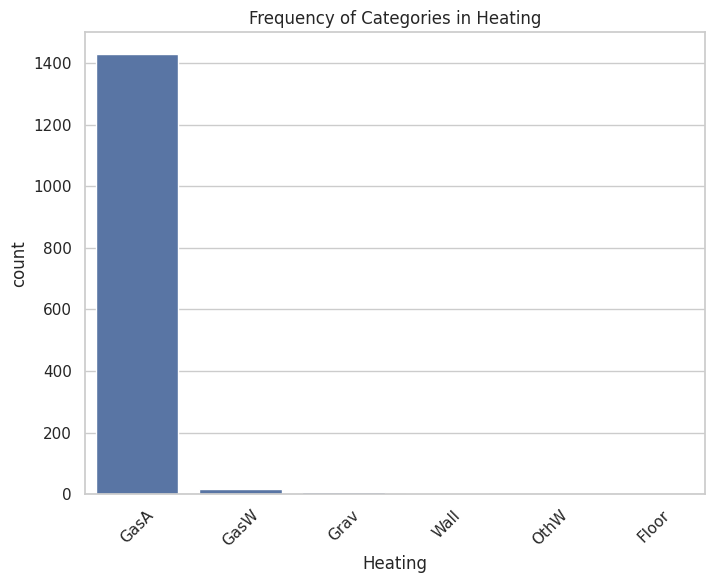

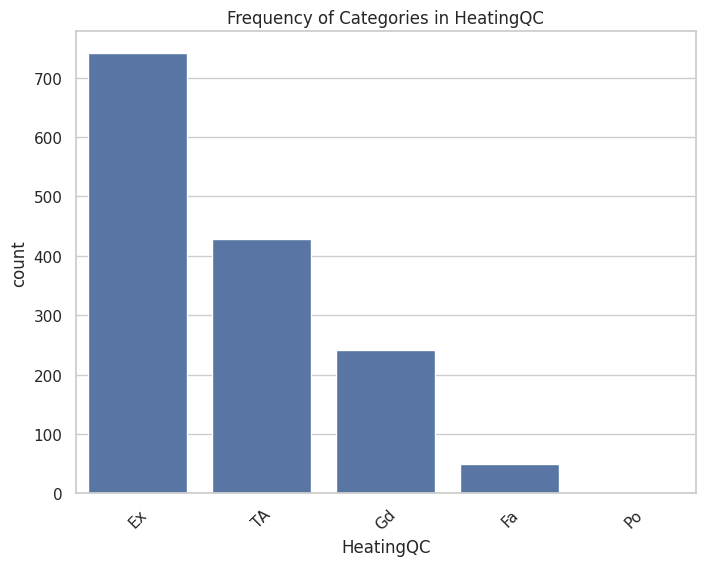

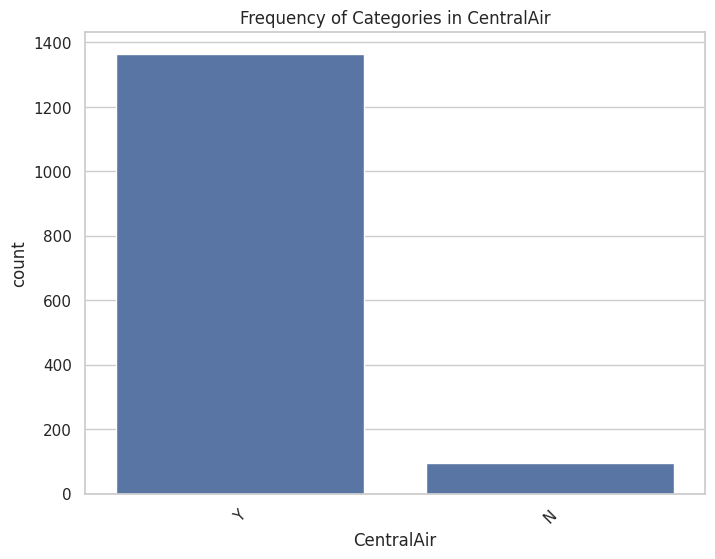

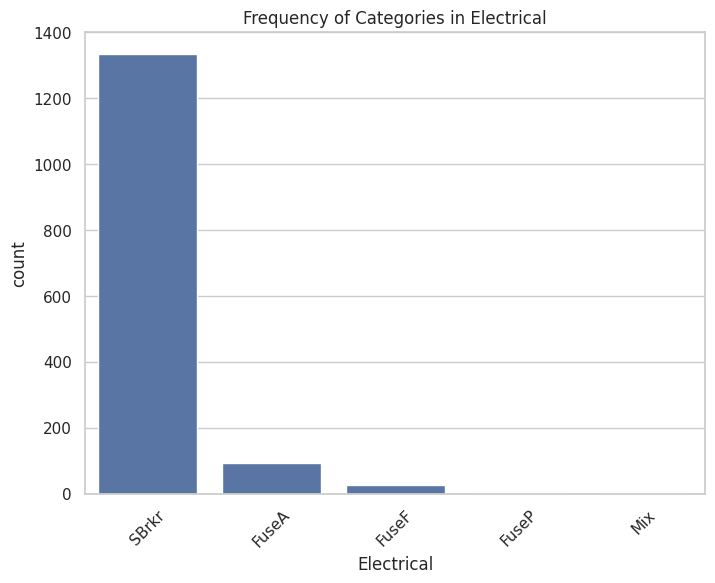

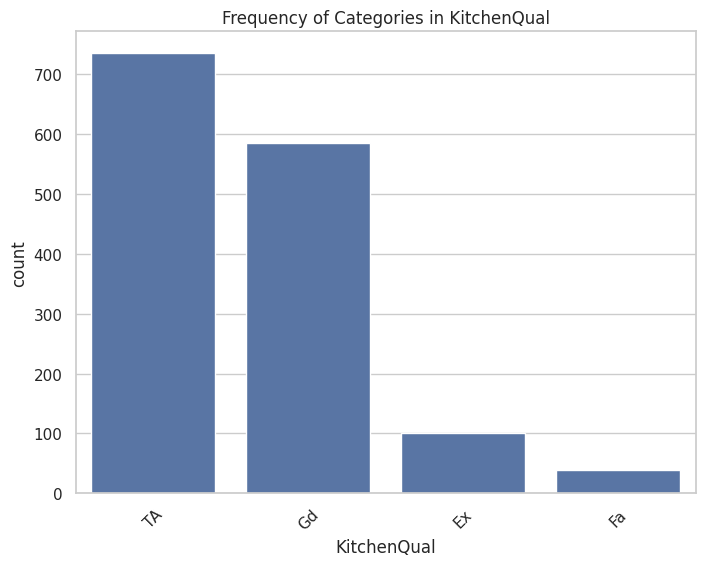

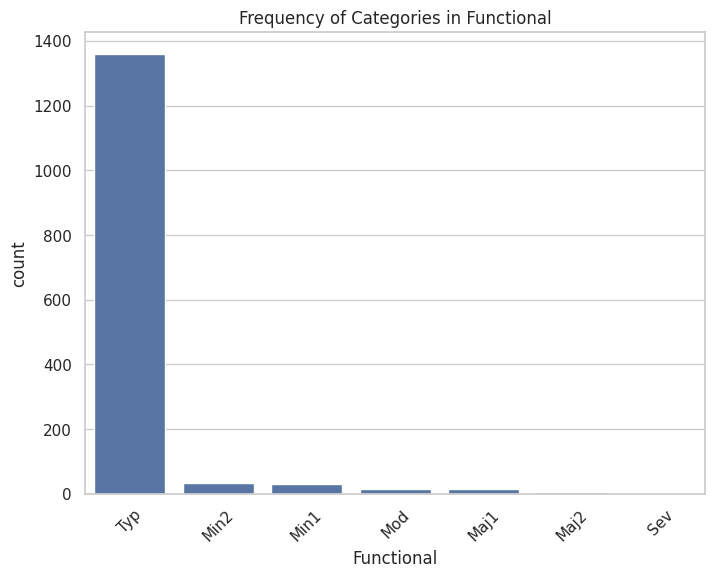

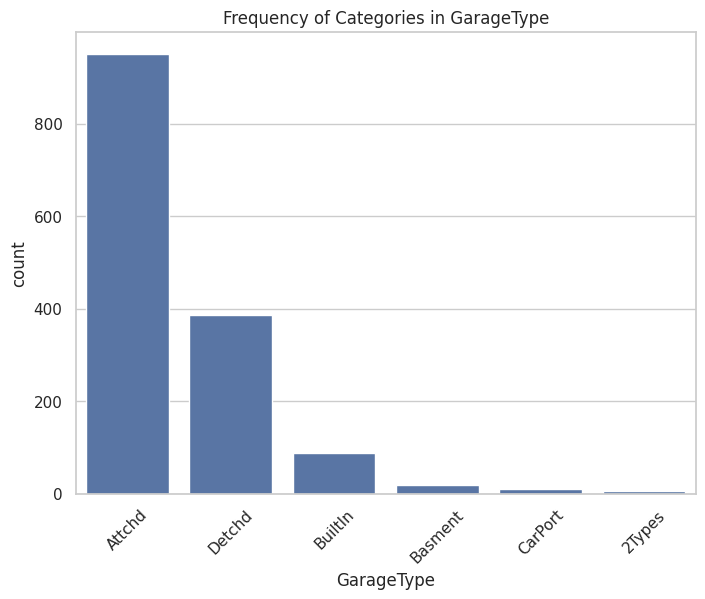

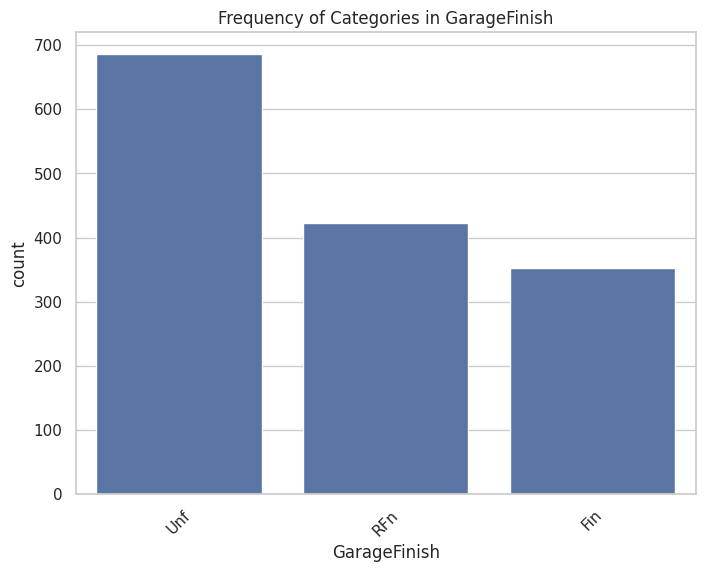

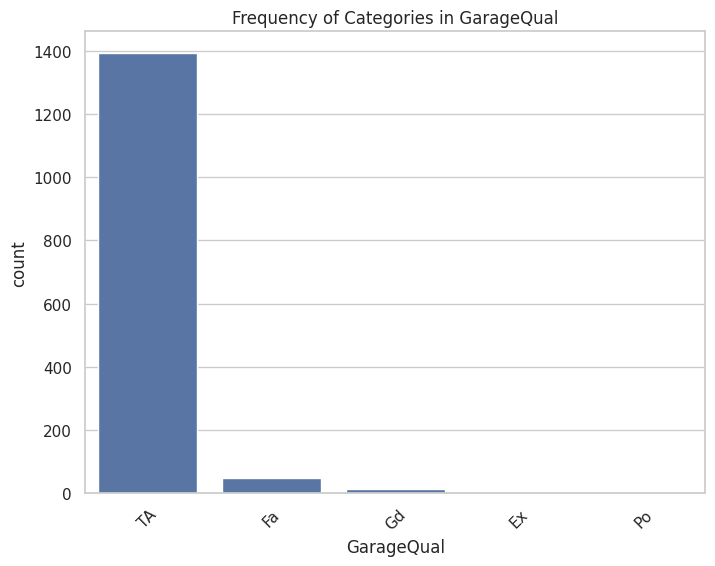

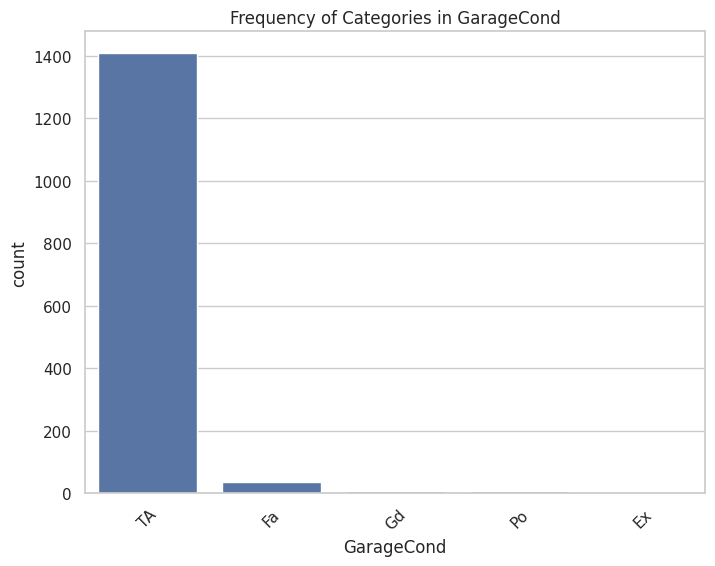

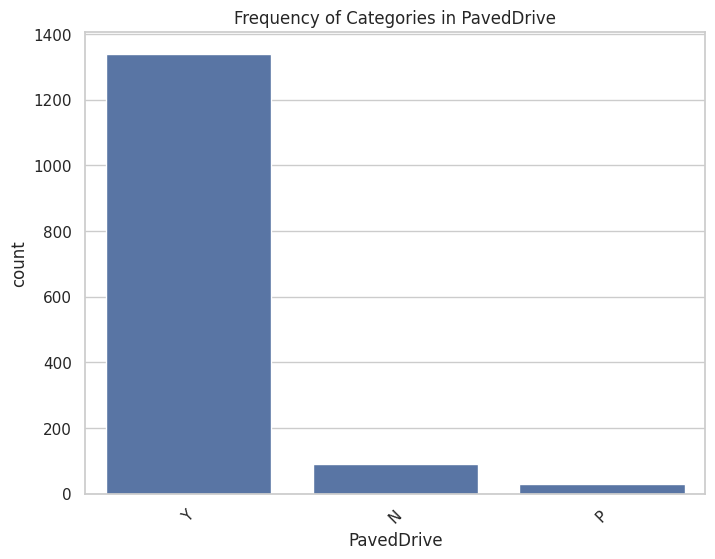

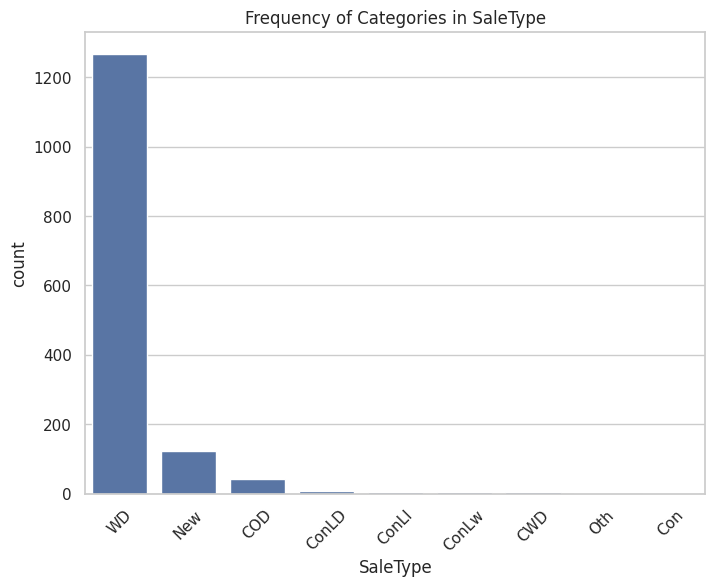

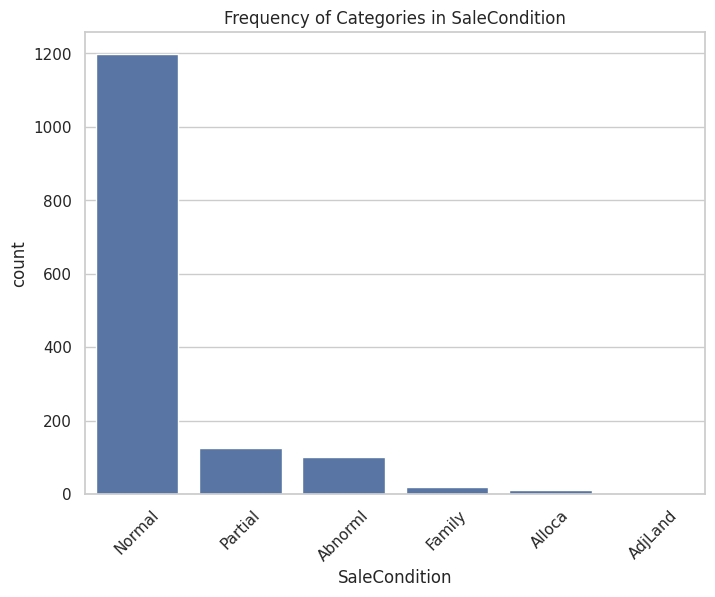

In [48]:
def plot_frequencies_cat(df):
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    # Loop through categorical columns and create individual plots
    for col in categorical_columns:
        plt.figure(figsize=(8, 6))  # Size of the individual plot
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)  # Count plot for each categorical column
        plt.title(f'Frequency of Categories in {col}')
        plt.xticks(rotation=45)  # Rotate x labels if needed
        plt.show()  # Display the plot
plot_frequencies_cat(train_df)

### Analyzing Numerical Features Distribution

Let's also examine the distribution of our numerical features to identify potential issues like skewness or outliers.

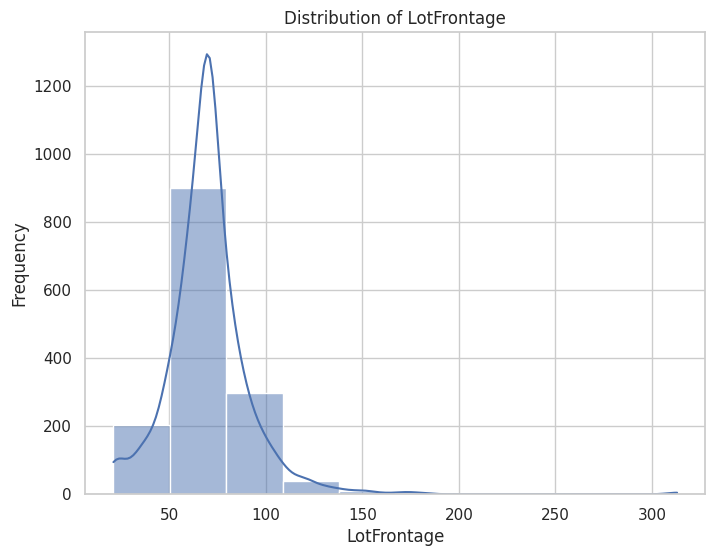

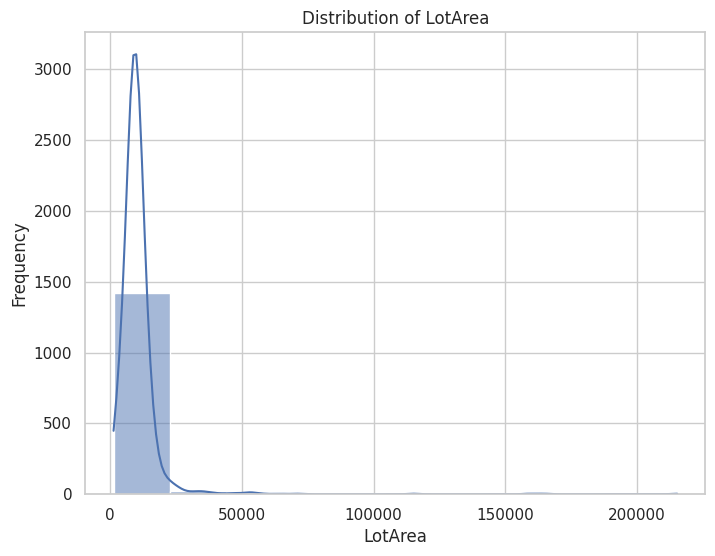

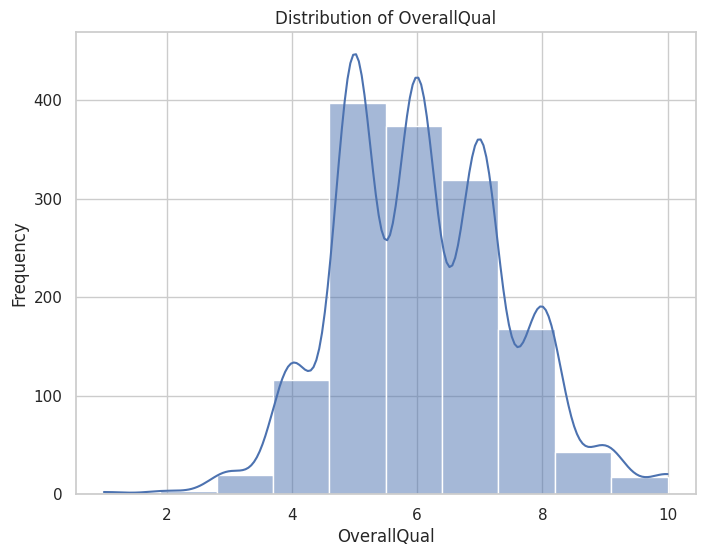

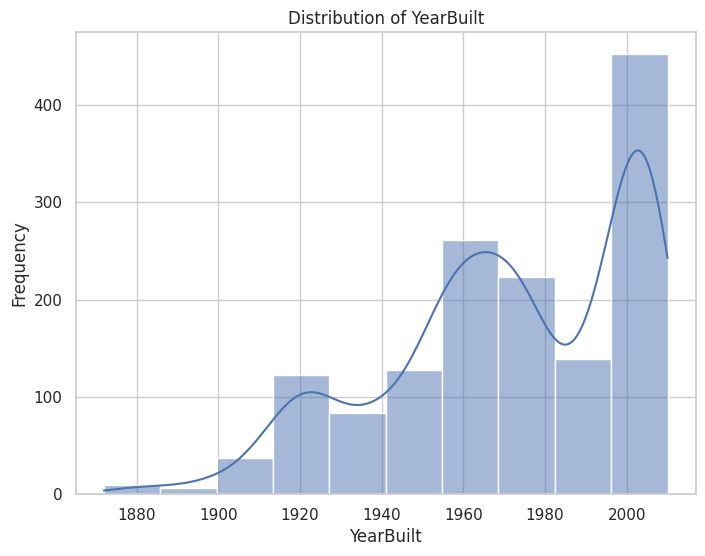

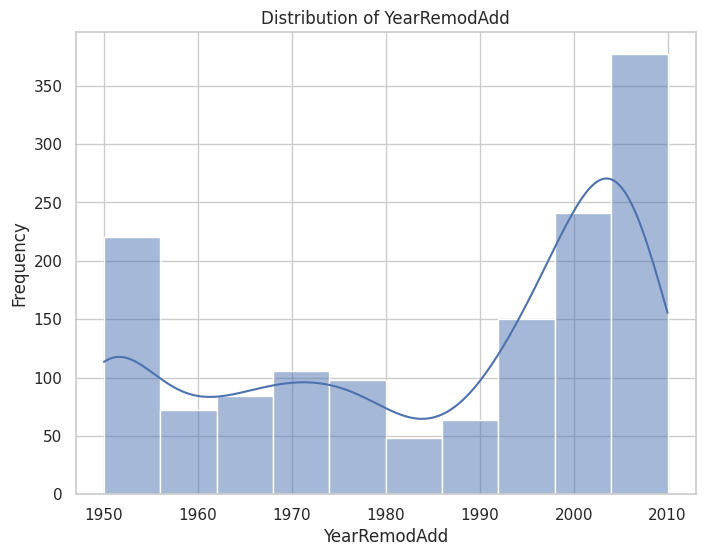

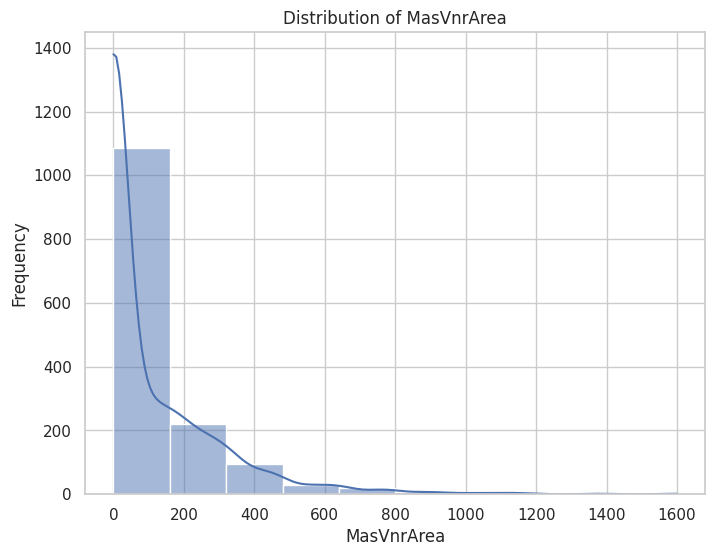

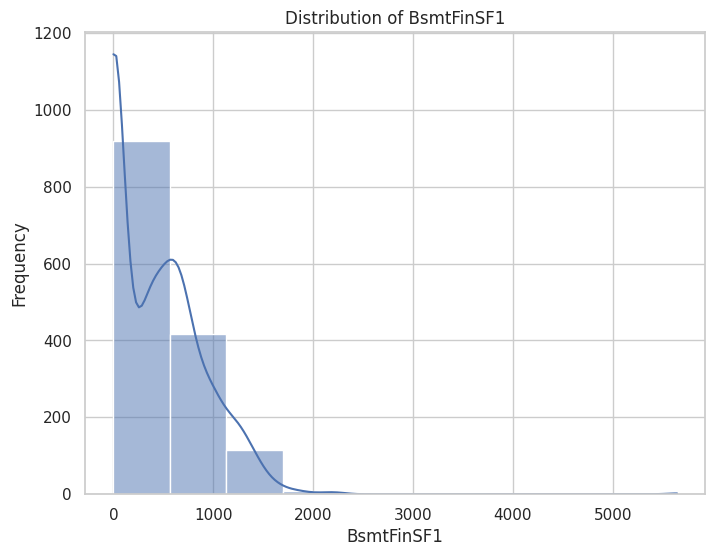

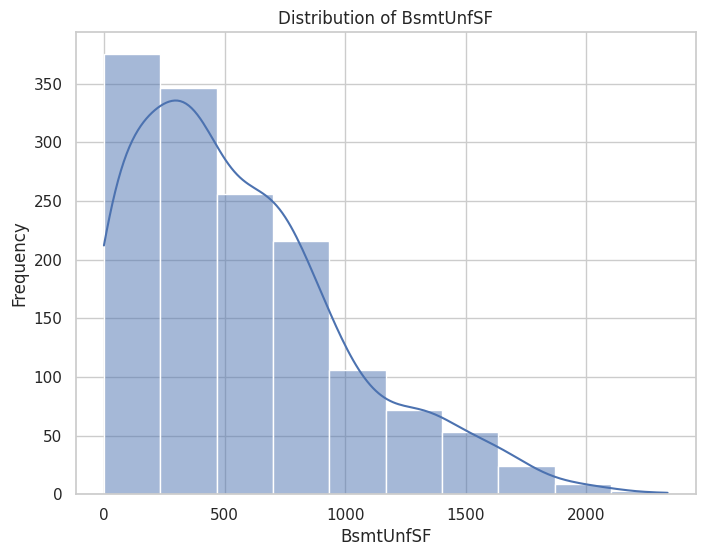

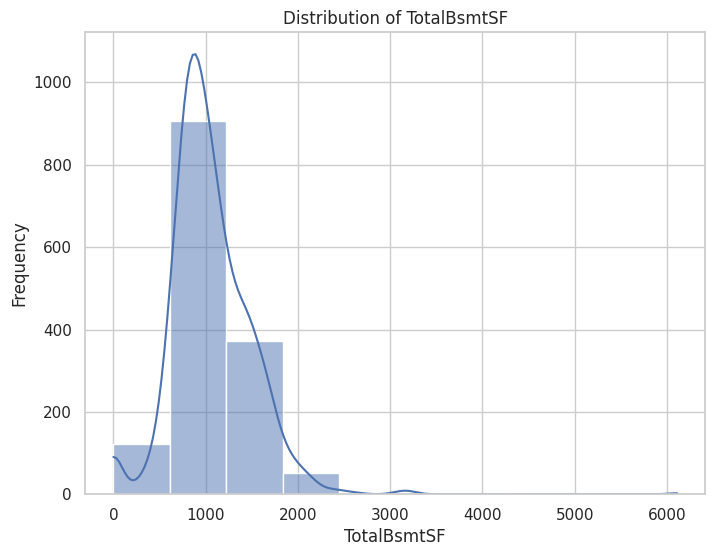

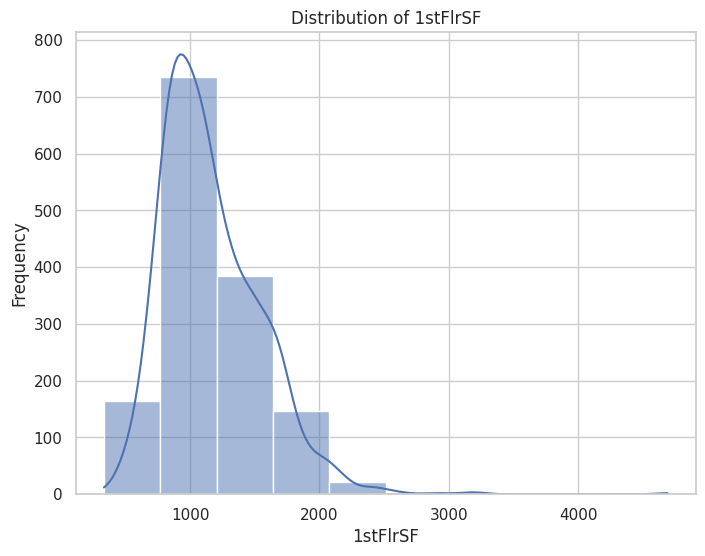

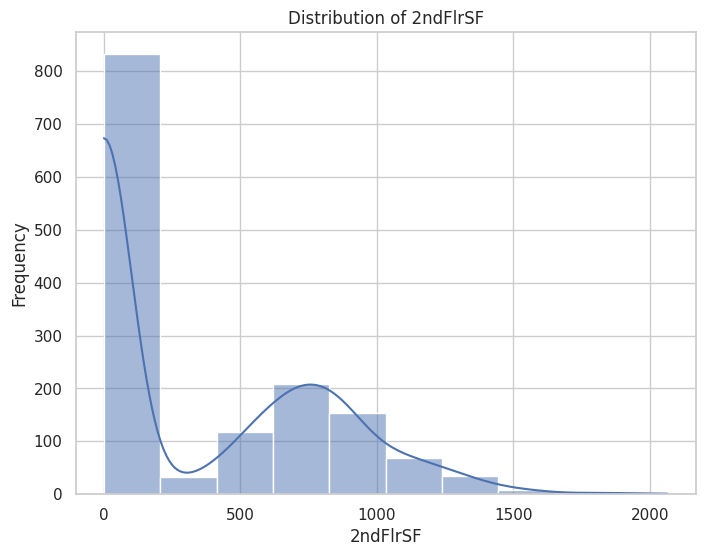

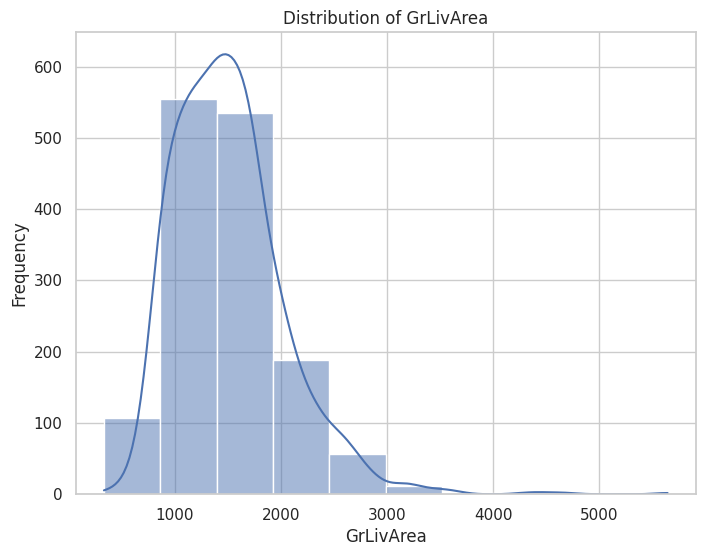

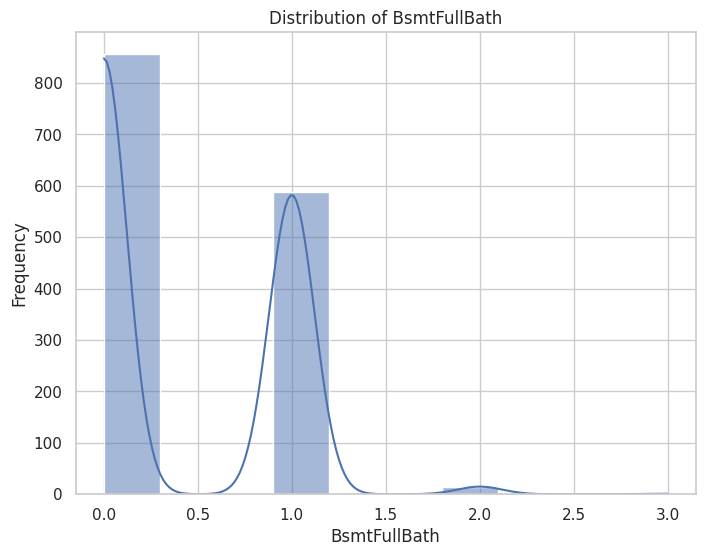

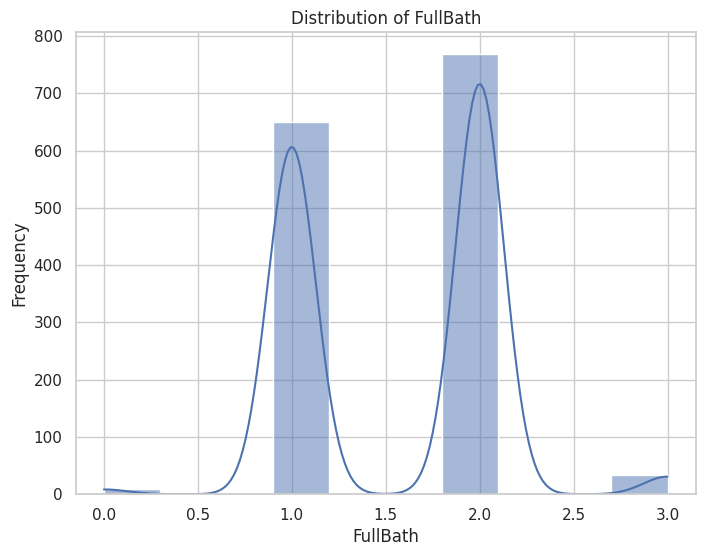

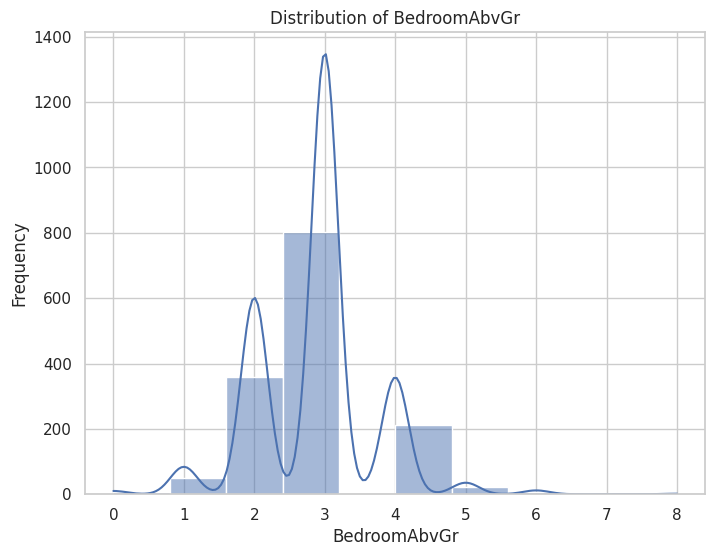

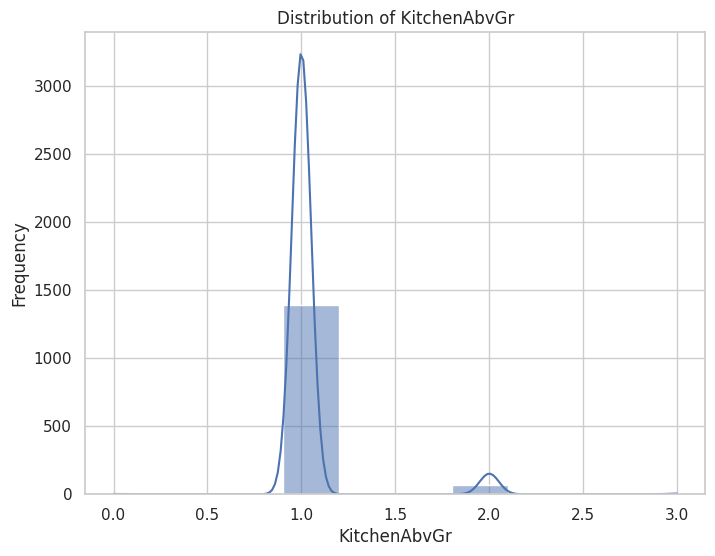

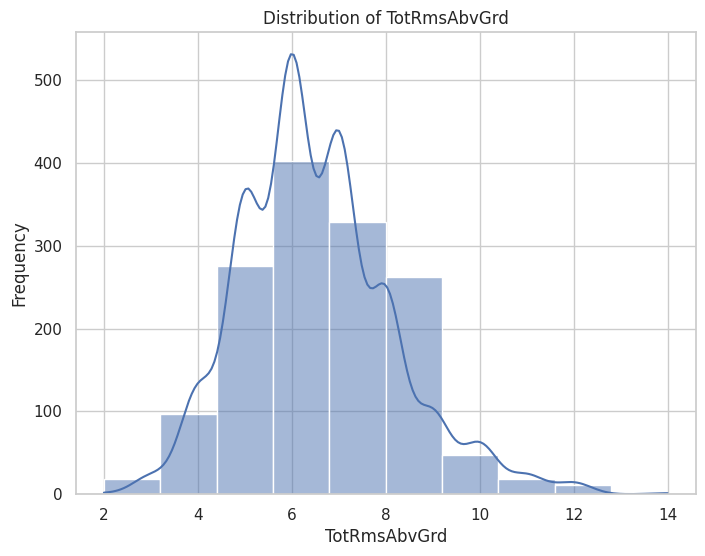

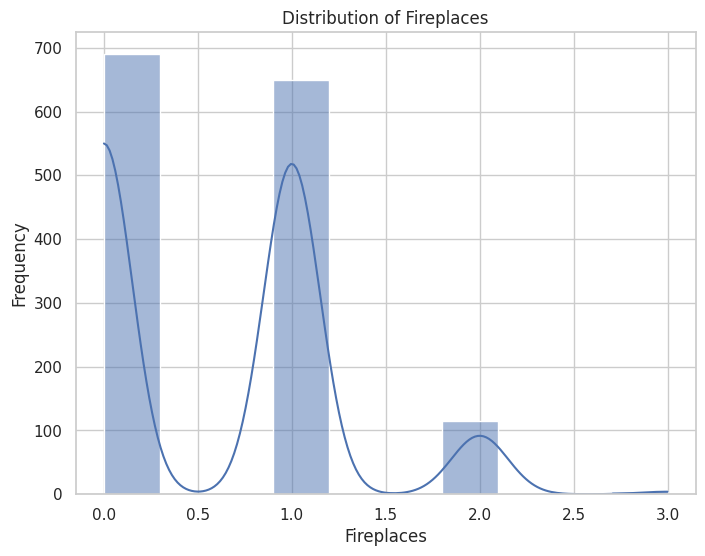

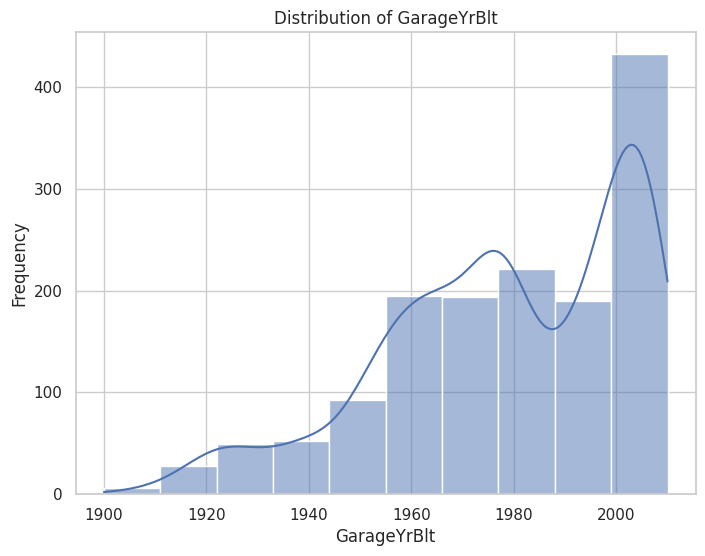

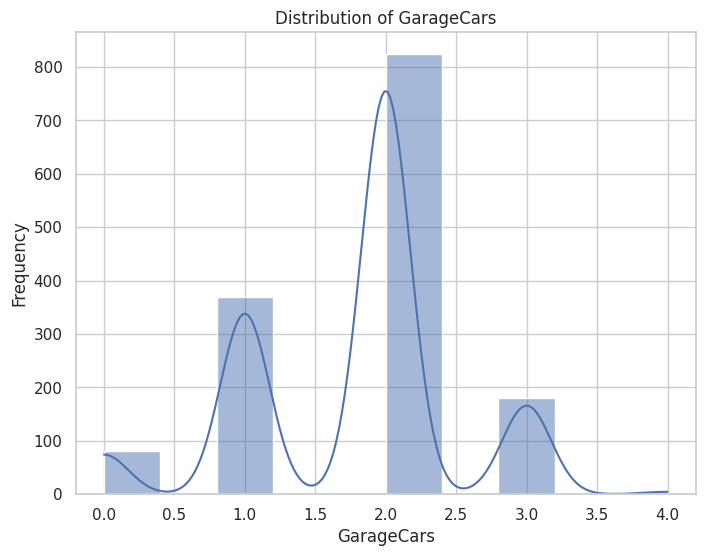

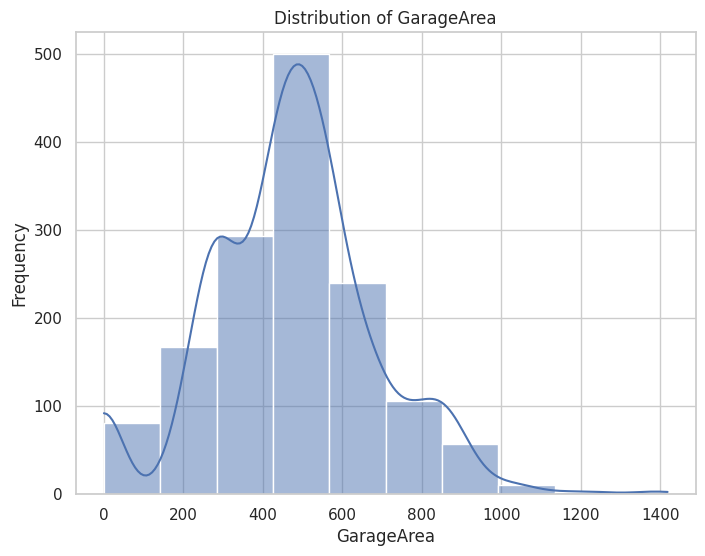

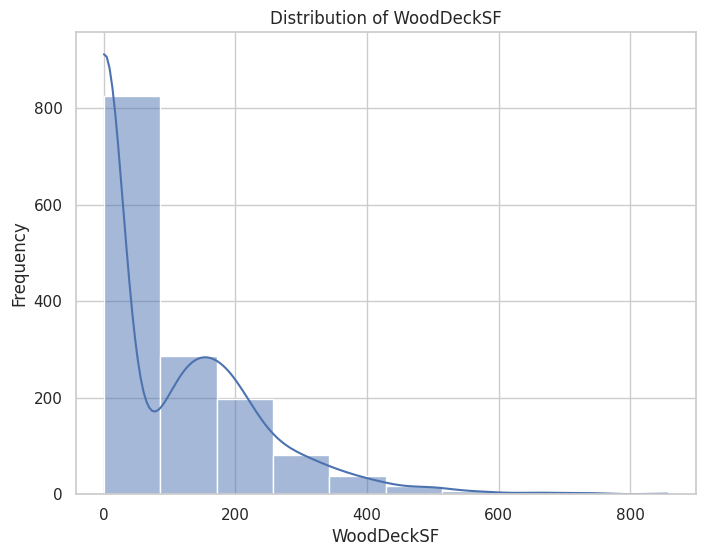

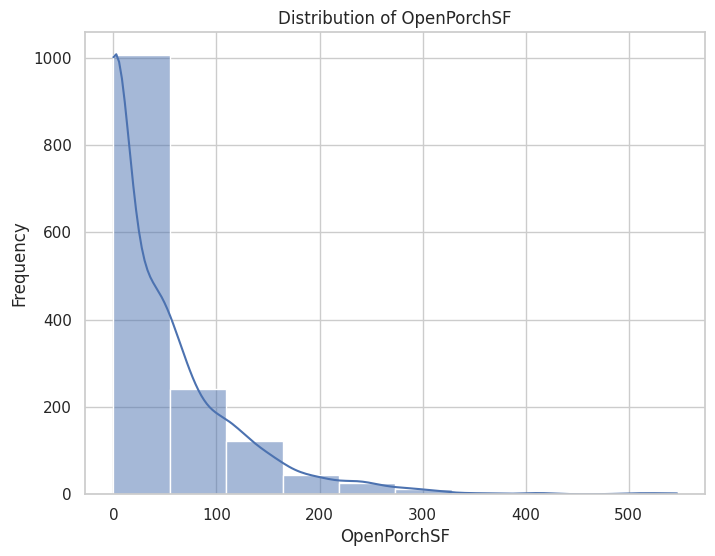

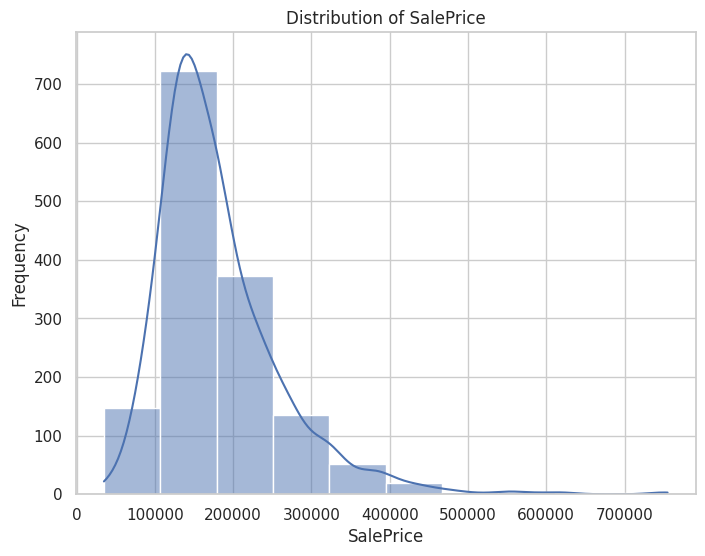

In [49]:
def plot_frequencies_num(df):
    numerical_columns = df.select_dtypes(include=['number']).columns
    
    # Loop through numerical columns and create individual plots
    for col in numerical_columns:
        plt.figure(figsize=(8, 6))  # Size of the individual plot
        
        # Histogram for distribution
        sns.histplot(df[col], kde=True, bins=10)  # kde=True adds a Kernel Density Estimate (smooth curve)
        
        # Alternatively, you could use a boxplot to visualize the distribution
        # sns.boxplot(data=df, x=col)
        
        # Set plot title and labels
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        
        # Display the plot
        plt.show()
plot_frequencies_num(train_df)

### Removing Additional Low-Information Features

Based on further examination of our visualizations, we can identify more features that have limited predictive power.

In [50]:
'''
Upon furhter examination i have decided to drop these columns: ['Street', 'RoofMatl']
'''
train_df = train_df.drop(columns=['Street', 'RoofMatl', 'Condition2'])
test_df = test_df.drop(columns=['Street', 'RoofMatl', 'Condition2'])

### Examining Categorical Value Distributions

Let's analyze the distribution of values within each categorical feature to identify rare categories that might need special handling.

In [52]:
categorical_columns = train_df.select_dtypes(include=['object', 'category']).columns

# Loop through each categorical column and print its value counts
for col in categorical_columns:
    print(f"\nValue counts for column: {col}")
    print(train_df[col].value_counts())


Value counts for column: MSZoning
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

Value counts for column: LotShape
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64

Value counts for column: LandContour
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

Value counts for column: LandSlope
LandSlope
Gtl    1382
Mod      65
Sev      13
Name: count, dtype: int64

Value counts for column: Neighborhood
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64

Value counts for column: Condition1
Condition1
Nor

### Handling Rare Categories

Categories with very few instances can lead to instability in statistical models and may cause overfitting. We'll group rare categories (those with fewer than 1% of observations) into an 'Other' category.

In [53]:
def group_rare_cat(df):
    # Set threshold for grouping rare categories (15 occurrences) 1% of all the entries
    threshold = df.shape[0] * 0.01
    
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # Loop through each categorical column
    for col in categorical_columns:
        # Count occurrences of each category
        category_counts = df[col].value_counts()
    
        # Identify rare categories that will be combined into 'Other' (less than threshold occurrences)
        rare_categories = category_counts[category_counts < threshold].index
    
        # Replace rare categories with 'Other'
        df[col] = df[col].apply(lambda x: 'Other' if x in rare_categories else x)
    
        # Display the modified value counts for the current column
        print(f"\nModified value counts for column: {col}")
        print(df[col].value_counts())
group_rare_cat(train_df)
group_rare_cat(test_df)
log_feature_step('combine_values', 'Combined all the values which had the lower frequency than 1% threshold')


Modified value counts for column: MSZoning
MSZoning
RL       1151
RM        218
FV         65
RH         16
Other      10
Name: count, dtype: int64

Modified value counts for column: LotShape
LotShape
Reg      925
IR1      484
IR2       41
Other     10
Name: count, dtype: int64

Modified value counts for column: LandContour
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

Modified value counts for column: LandSlope
LandSlope
Gtl      1382
Mod        65
Other      13
Name: count, dtype: int64

Modified value counts for column: Neighborhood
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Other       22
MeadowV     17
Blmngtn     17
BrDale      16
Name: count, dtype: int64

Modified value counts for colum

### Checking Dataset Dimensions

Let's check the current shape of our training dataset after our cleaning and transformation steps.

In [54]:
train_df.shape

(1460, 56)

### Encoding Categorical Features

Machine learning algorithms typically require numerical input, so we need to convert our categorical features to numeric form. We'll use Label Encoding, which assigns a unique integer to each category.

In [55]:
def transform_cat_to_numeric(df):
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()
    
    # Loop through each categorical column and apply Label Encoding
    for col in categorical_columns:
        # Apply Label Encoding to the column
        df[col] = label_encoder.fit_transform(df[col])
transform_cat_to_numeric(train_df)
transform_cat_to_numeric(test_df)

### Checking Transformed Dataset

Let's examine our dataset after encoding to ensure all features are now numeric.

In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 56 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1460 non-null   int64  
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   LotShape       1460 non-null   int64  
 4   LandContour    1460 non-null   int64  
 5   LandSlope      1460 non-null   int64  
 6   Neighborhood   1460 non-null   int64  
 7   Condition1     1460 non-null   int64  
 8   BldgType       1460 non-null   int64  
 9   HouseStyle     1460 non-null   int64  
 10  OverallQual    1460 non-null   int64  
 11  YearBuilt      1460 non-null   int64  
 12  YearRemodAdd   1460 non-null   int64  
 13  RoofStyle      1460 non-null   int64  
 14  Exterior1st    1460 non-null   int64  
 15  Exterior2nd    1460 non-null   int64  
 16  MasVnrArea     1460 non-null   float64
 17  ExterQual      1460 non-null   int64  
 18  ExterCon

## Feature Selection

Even after our initial feature cleaning, we may still have more features than necessary for optimal model performance. Feature selection helps identify the most predictive features and reduce dimensionality, which can improve model performance and reduce overfitting.

In [57]:
def select_features(estimator):
    X_train = train_df.drop('SalePrice', axis=1)  
    y_train = train_df['SalePrice']
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
   
    
    # Create RFECV model with negative mean squared error scoring
    rfecv = RFECV(
        estimator=estimator,
        step=1,  # Remove one feature at a time
        cv=cv,
        scoring='neg_mean_squared_error',  
        min_features_to_select=1,  # Minimum number of features to consider
        n_jobs=-1,  # Use all available cores
        verbose=1   # Show progress
    )
    
    print("Fitting RFECV model...")
    rfecv.fit(X_train, y_train)
    
    print(f"\nOptimal number of features: {rfecv.n_features_}")
    selected_features = X_train.columns[rfecv.support_]
    print(f"Selected features ({len(selected_features)}):")
    print(selected_features.tolist())
    
    feature_ranking = pd.DataFrame({
        'Feature': X_train.columns,
        'Selected': rfecv.support_,
        'Ranking': rfecv.ranking_
    }).sort_values('Ranking')
    
    print("\nFeature ranking (top 20):")
    print(feature_ranking.head(20))
    
    # Plot number of features vs cross-validation score
    plt.figure(figsize=(12, 6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross-validation score (neg MSE)")
    plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
    plt.title("Feature Selection using RFECV")
    plt.axvline(x=rfecv.n_features_, color='r', linestyle='--', 
                label=f'Optimal number of features: {rfecv.n_features_}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('rfecv_feature_selection.png')
    plt.show()
    
    plt.figure(figsize=(14, 8))
    # Sort features by their ranking
    selected_features_ranking = feature_ranking[feature_ranking['Selected'] == True].sort_values('Ranking')
    plt.bar(range(len(selected_features)), [1] * len(selected_features), align='center')
    plt.xticks(range(len(selected_features)), selected_features_ranking['Feature'], rotation=90)
    plt.title('Selected Features by RFECV')
    plt.tight_layout()
    plt.savefig('selected_features.png')
    plt.show()
    
    X_train_selected = X_train[selected_features]
    X_test_selected = test_df[selected_features]  
    
    # Save the results for future use
    estimator_name = type(estimator).__name__
    train_csv_path = f'{estimator_name}_X_train_selected_features.csv'
    test_csv_path = f'{estimator_name}_X_test_selected_features.csv'
    
    X_train_selected.to_csv(train_csv_path, index=False)
    X_test_selected.to_csv(test_csv_path, index=False)
    
    # Log feature selection with MLflow
    method_name = f"RFECV_{estimator_name}"
    description = f"Recursive Feature Elimination with Cross-Validation using {estimator_name}"
    features_before = X_train.shape[1]
    features_after = len(selected_features)
    best_score = np.max(rfecv.cv_results_["mean_test_score"])
    
    # Feature importance if available
    if hasattr(estimator, 'feature_importances_'):
        feature_importance_df = pd.DataFrame({
            'Feature': selected_features,
            'Importance': estimator.feature_importances_[rfecv.support_]
        }).sort_values('Importance', ascending=False)
        
        # Save feature importance to CSV
        importance_csv = f'{method_name}_importance.csv'
        feature_importance_df.to_csv(importance_csv, index=False)
        
        # Create artifact dictionary
        artifacts = {
            'feature_selection_plot': 'rfecv_feature_selection.png',
            'selected_features_plot': 'selected_features.png',
            'feature_importance': importance_csv,
            'train_selected_features': train_csv_path,
            'test_selected_features': test_csv_path
        }
    else:
        artifacts = {
            'feature_selection_plot': 'rfecv_feature_selection.png',
            'selected_features_plot': 'selected_features.png',
            'train_selected_features': train_csv_path,
            'test_selected_features': test_csv_path
        }
    
    # Log to MLflow
    log_feature_selection(
        method=method_name,
        description=description,
        features_before=features_before,
        features_after=features_after,
        selected_features=selected_features.tolist(),
        selection_score=best_score,
        artifacts=artifacts
    )
    
    print("\nDataframes with selected features saved to CSV files.")
    print(f"X_train_selected shape: {X_train_selected.shape}")
    print(f"X_test_selected shape: {X_test_selected.shape}")
    print(f"Feature selection logged to MLflow with method: {method_name}")
    
    return selected_features, X_train_selected, X_test_selected


### Recursive Feature Elimination with Cross-Validation (RFECV)

We'll use RFECV to select the most important features. This approach recursively removes features and evaluates model performance to identify the optimal feature subset. We'll use a RandomForestRegressor as our base estimator for feature importance calculation.

Fitting RFECV model...
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.

Optimal number of features: 47
Selected features (47):
['MSZoning', 'LotFrontage', 'LotArea', 'LotShape', 'LandContour', 'LandSlope', 'Neighborhood', 'Condition1', 'HouseStyle', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchS

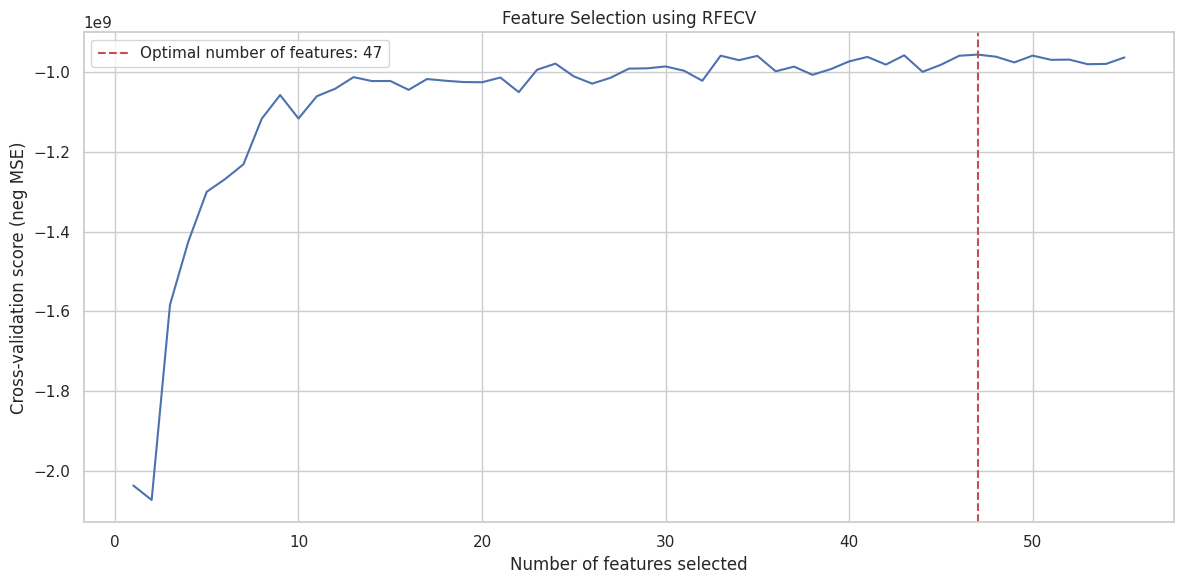

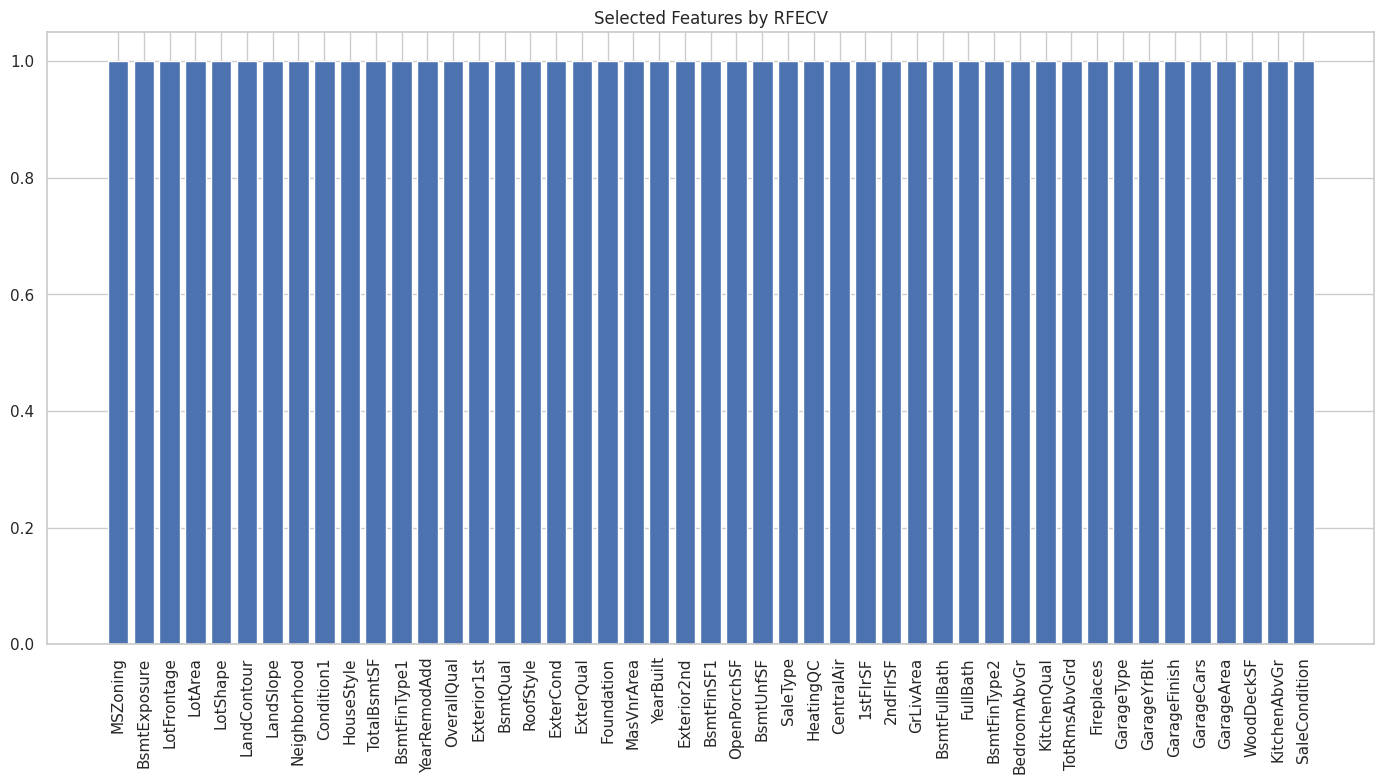

Logged feature selection method: RFECV_RandomForestRegressor
🏃 View run selection_RFECV_RandomForestRegressor at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1/runs/df18b3fb55874bea802572c03af75562
🧪 View experiment at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1

Dataframes with selected features saved to CSV files.
X_train_selected shape: (1460, 47)
X_test_selected shape: (1459, 47)
Feature selection logged to MLflow with method: RFECV_RandomForestRegressor


(Index(['MSZoning', 'LotFrontage', 'LotArea', 'LotShape', 'LandContour',
        'LandSlope', 'Neighborhood', 'Condition1', 'HouseStyle', 'OverallQual',
        'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
        'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
        'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF',
        '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
        'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
        'WoodDeckSF', 'OpenPorchSF', 'SaleType', 'SaleCondition'],
       dtype='object'),
       MSZoning  LotFrontage  LotArea  LotShape  LandContour  LandSlope  \
 0            3         65.0     8450         3            3          0   
 1            3         80.0     9600         3            3          0   
 2   

In [58]:
estimator = RandomForestRegressor()
select_features(estimator)

## Model Training and Evaluation

Now that we have selected our features, we'll train and evaluate various regression models to find the best performer for our house price prediction task. We'll use MLflow to track our experiments and compare model performance.

🏃 View run house_prices_prediction_pipeline at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1/runs/45905c626f964354aaf7f1949f11b5e5
🧪 View experiment at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1
Training set: (1168, 53)
Validation set: (292, 53)
Training models...
Training Linear Regression...
  RMSE: 35771.74, R²: 0.8332
Training Random Forest...
  RMSE: 28709.90, R²: 0.8925
Training Gradient Boosting...
  RMSE: 28869.58, R²: 0.8913
Training XGBoost...
  RMSE: 26198.48, R²: 0.9105

Model Performance Comparison:
               Model    Train RMSE  Validation RMSE  Train R²  Validation R²  \
3            XGBoost   5581.592604     26198.476902  0.994777       0.910517   
1      Random Forest  10966.296014     28709.902838  0.979838       0.892539   
2  Gradient Boosting  14508.221086     28869.577692  0.964710       0.891341   
0  Linear Regression  31132.259737     35771.741229  0.837504       0.833173   

   Validation MAE  
3    16986.367188 

2025/04/11 00:07:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Linear Regression_training at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1/runs/1aa0137f7fdf4bccad9f23282bbe840f
🧪 View experiment at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1


2025/04/11 00:07:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest_training at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1/runs/282b378b905d4b39ab090d9cebcdd3fe
🧪 View experiment at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1


2025/04/11 00:07:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Gradient Boosting_training at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1/runs/bba50c767e9f46e4a4f29a9d96cd043d
🧪 View experiment at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1


2025/04/11 00:08:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_training at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1/runs/c10cd25a2eb142bda4746d0ae62cb0b4
🧪 View experiment at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1


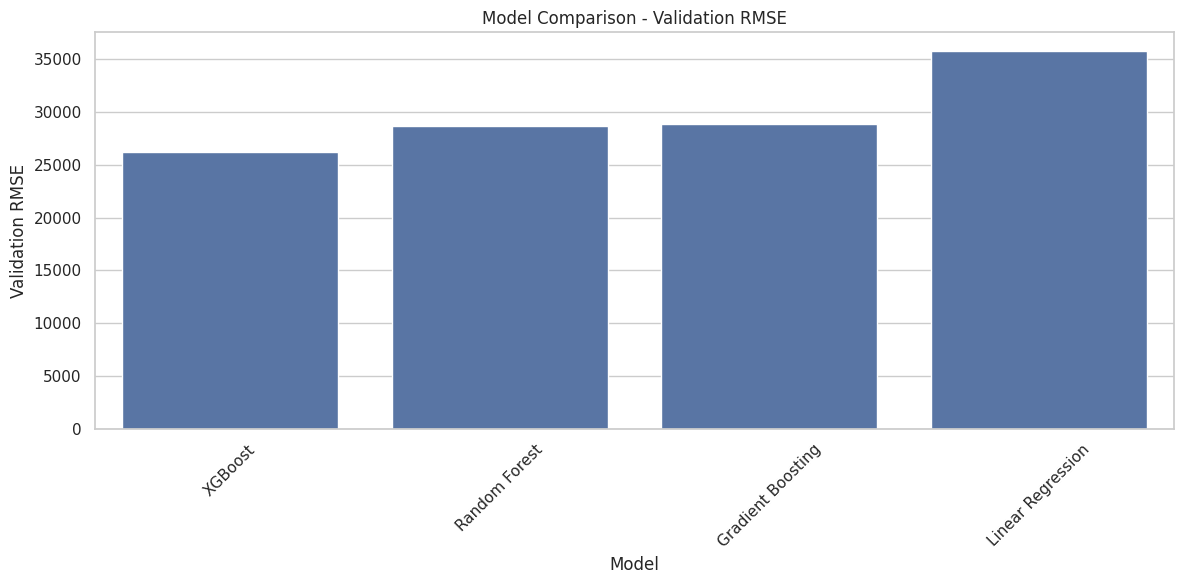

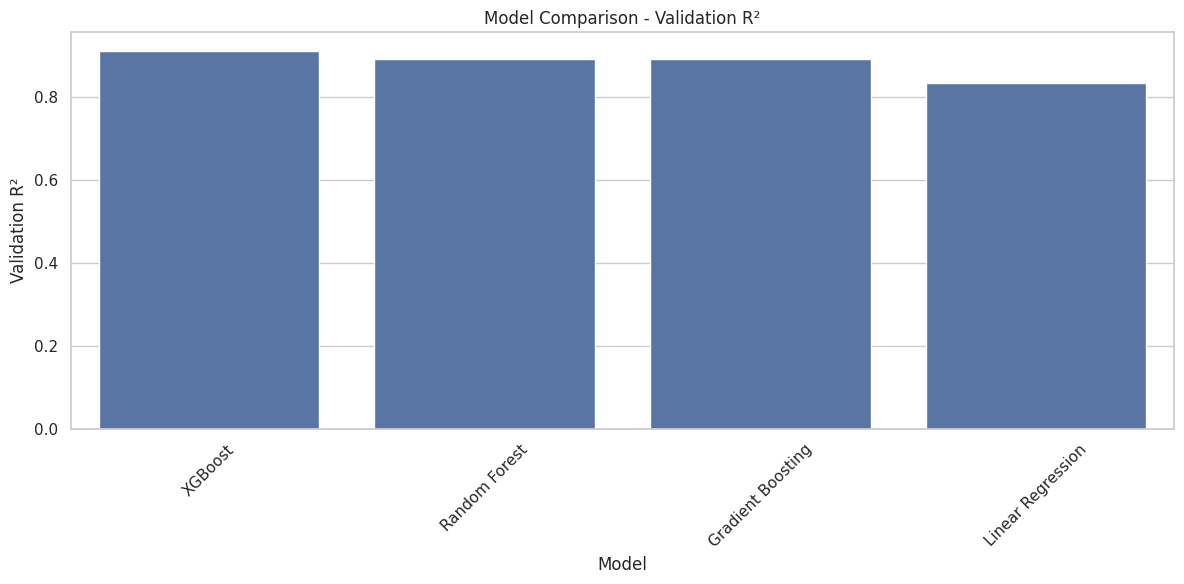


Best Model: XGBoost

Performing hyperparameter tuning for the best model...
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best CV score: 26478.35 (RMSE)


2025/04/11 00:09:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_hyperparameter_tuning at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1/runs/7f813e378ff94f038d3a5f9f72b8fb10
🧪 View experiment at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1

Training final model on all training data...


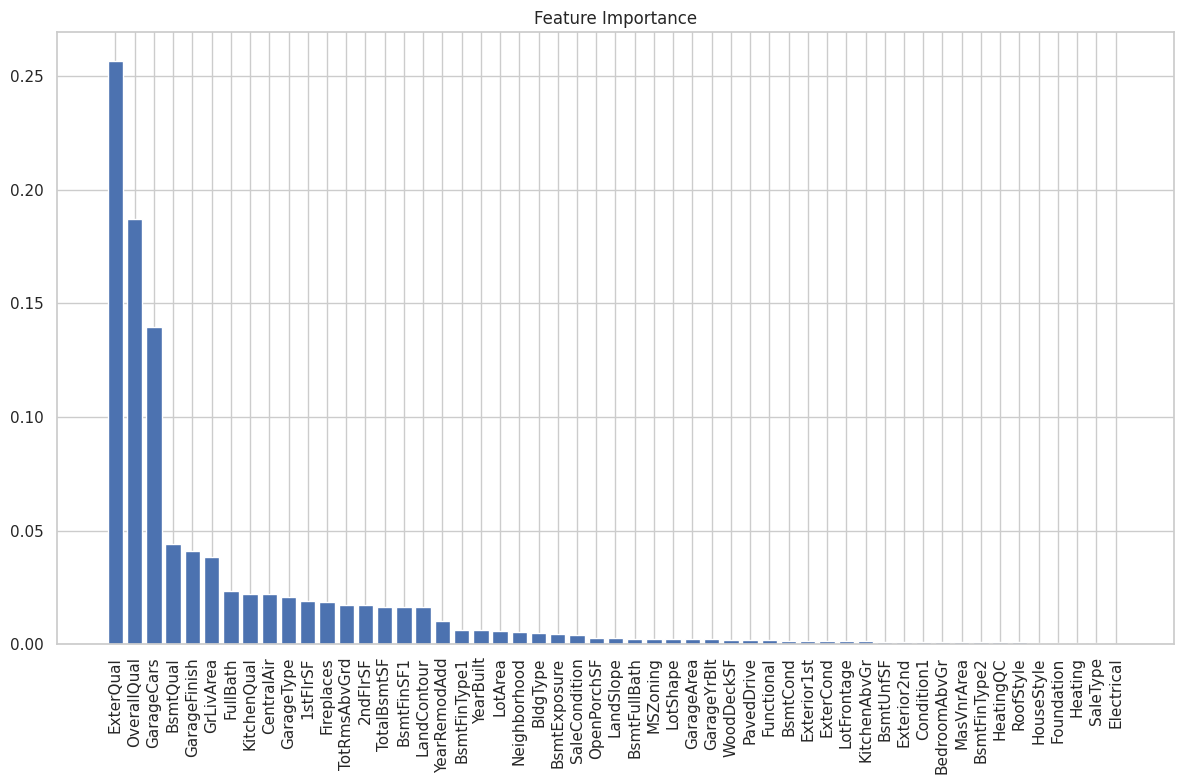


Top 10 most important features:
         Feature  Importance
17     ExterQual    0.256535
10   OverallQual    0.187265
46    GarageCars    0.139633
20      BsmtQual    0.044037
45  GarageFinish    0.041095
34     GrLivArea    0.038184
36      FullBath    0.023215
39   KitchenQual    0.021940
30    CentralAir    0.021898
43    GarageType    0.020566


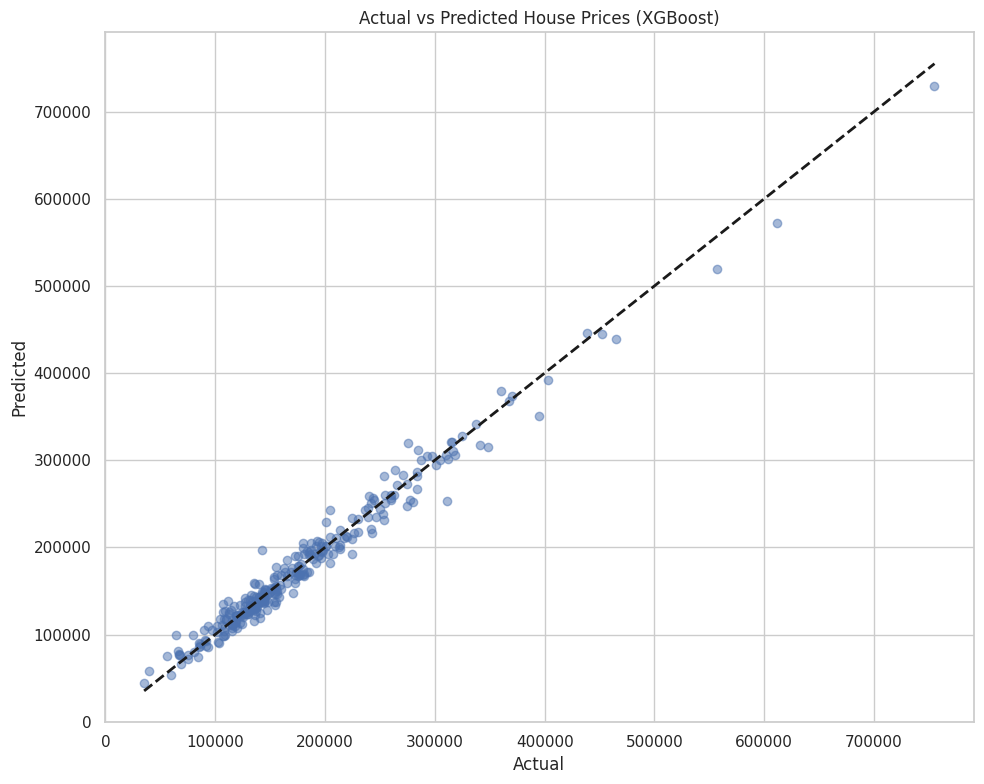

🏃 View run final_model_evaluation at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1/runs/9cfa67cd239b49d0a05ccae5f01bb0b8
🧪 View experiment at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1

Final Model Metrics on Validation Data:
RMSE: $13383.48
MAE: $9805.88
R²: 0.9766


2025/04/11 00:10:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'house_prices_xgboost'.
2025/04/11 00:10:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: house_prices_xgboost, version 1
Created version '1' of model 'house_prices_xgboost'.



Model registered in MLflow with URI: runs:/1f0c208bd7ab4a7ba145aac4b01e3b2f/xgboost_final_model
🏃 View run register_XGBoost at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1/runs/1f0c208bd7ab4a7ba145aac4b01e3b2f
🧪 View experiment at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1

Model training complete!
🏃 View run house_price_prediction at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1/runs/8a3c0689e768462d9b4106e0f39aed96
🧪 View experiment at: https://dagshub.com/lagorg22/house_prices.mlflow/#/experiments/1


In [61]:
# First, ensure any existing MLflow runs are closed
try:
    mlflow.end_run()
except Exception as e:
    print(f"Note: {str(e)}")

# Function to evaluate a model
def evaluate_model(model, X_train, X_val, y_train, y_val):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    return {
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'model': model
    }

# Function to log model training with MLflow
def log_model_training(model_name, model, X_train, y_train, X_val, y_val, params):
    # First evaluate the model using our existing function
    result = evaluate_model(model, X_train, X_val, y_train, y_val)
    
    # Log the results with MLflow
    try:
        with mlflow.start_run(nested=True, run_name=f"{model_name}_training"):
            # Log parameters
            for param_name, param_value in params.items():
                mlflow.log_param(param_name, param_value)
            
            # Log metrics
            mlflow.log_metric("train_rmse", result['train_rmse'])
            mlflow.log_metric("val_rmse", result['val_rmse'])
            mlflow.log_metric("train_r2", result['train_r2'])
            mlflow.log_metric("val_r2", result['val_r2'])
            mlflow.log_metric("val_mae", result['val_mae'])
            
            # Log model
            mlflow.sklearn.log_model(result['model'], f"{model_name}_model")
    except Exception as e:
        print(f"Warning: MLflow logging failed for {model_name}: {str(e)}")
    
    return result

# Ignore warnings
warnings.filterwarnings('ignore')

# Load data
X_train_selected = pd.read_csv('RF_X_train_selected_features.csv')
y_train = train_df['SalePrice'] 

# Split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_selected, y_train, test_size=0.2, random_state=42
)

print(f"Training set: {X_train_final.shape}")
print(f"Validation set: {X_val.shape}")

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train and evaluate all models without MLflow first to ensure we have results
print("Training models...")
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    try:
        # First evaluate the model normally without MLflow to avoid any issues
        results[name] = evaluate_model(
            model, 
            X_train_final, 
            X_val, 
            y_train_final, 
            y_val
        )
        print(f"  RMSE: {results[name]['val_rmse']:.2f}, R²: {results[name]['val_r2']:.4f}")
    except Exception as e:
        print(f"  Error training {name}: {str(e)}")

# Make sure we have results before creating the DataFrame
if not results:
    print("No models were successfully trained. Check the error messages above.")
    exit()

# Create a results DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train RMSE': [results[m]['train_rmse'] for m in results.keys()],
    'Validation RMSE': [results[m]['val_rmse'] for m in results.keys()],
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Validation R²': [results[m]['val_r2'] for m in results.keys()],
    'Validation MAE': [results[m]['val_mae'] for m in results.keys()]
}).sort_values('Validation RMSE')

print("\nModel Performance Comparison:")
print(results_df)

# Now start MLflow tracking with a fresh run
try:
    mlflow.end_run()  # Make sure any existing run is closed
except:
    pass

# Start MLflow run for logging
try:
    with mlflow.start_run(run_name="house_price_prediction"):
        # Log model comparison results
        results_df.to_csv('model_comparison_results.csv', index=False)
        mlflow.log_artifact('model_comparison_results.csv')
        
        # Log each model separately
        for name, result in results.items():
            try:
                with mlflow.start_run(nested=True, run_name=f"{name}_training"):
                    params = {} if name == 'Linear Regression' else {'n_estimators': 100, 'random_state': 42}
                    if name == 'XGBoost':
                        params['learning_rate'] = 0.1
                    
                    # Log parameters
                    for param_name, param_value in params.items():
                        mlflow.log_param(param_name, param_value)
                    
                    # Log metrics
                    mlflow.log_metric("train_rmse", result['train_rmse'])
                    mlflow.log_metric("val_rmse", result['val_rmse'])
                    mlflow.log_metric("train_r2", result['train_r2'])
                    mlflow.log_metric("val_r2", result['val_r2'])
                    mlflow.log_metric("val_mae", result['val_mae'])
                    
                    # Log model
                    mlflow.sklearn.log_model(result['model'], f"{name}_model")
            except Exception as e:
                print(f"Warning: MLflow logging failed for {name}: {str(e)}")
                continue

        # Visualize results
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Model', y='Validation RMSE', data=results_df)
        plt.title('Model Comparison - Validation RMSE')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('model_comparison_rmse.png')
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.barplot(x='Model', y='Validation R²', data=results_df)
        plt.title('Model Comparison - Validation R²')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('model_comparison_r2.png')
        plt.show()

        # Log comparison plots
        try:
            mlflow.log_artifact('model_comparison_rmse.png')
            mlflow.log_artifact('model_comparison_r2.png')
        except Exception as e:
            print(f"Warning: Failed to log visualization artifacts: {str(e)}")

        # Get the best model
        best_model_name = results_df.iloc[0]['Model']
        best_model = results[best_model_name]['model']
        print(f"\nBest Model: {best_model_name}")

        # Hyperparameter tuning for the best model
        print("\nPerforming hyperparameter tuning for the best model...")

        # Define parameter grid based on the best model
        if best_model_name == 'Linear Regression':
            # Linear Regression doesn't have hyperparameters to tune
            param_grid = {}
            
        elif best_model_name == 'Random Forest':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10]
            }

        elif best_model_name == 'Gradient Boosting':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            }
            
        elif best_model_name == 'XGBoost':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'colsample_bytree': [0.7, 0.8, 0.9]
            }

        # Perform grid search if there are parameters to tune
        best_params = {}
        if param_grid:
            grid_search = GridSearchCV(
                best_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
            )
            grid_search.fit(X_train_selected, y_train)
            best_params = grid_search.best_params_
            best_score = np.sqrt(-grid_search.best_score_)
            print(f"Best parameters: {best_params}")
            print(f"Best CV score: {best_score:.2f} (RMSE)")
            
            # Update the best model with tuned parameters
            best_model = grid_search.best_estimator_
            
            # Log hyperparameter tuning results
            try:
                with mlflow.start_run(nested=True, run_name=f"{best_model_name}_hyperparameter_tuning"):
                    # Log parameter grid
                    for param_name, param_values in param_grid.items():
                        mlflow.log_param(f"grid_{param_name}", str(param_values))
                    
                    # Log best parameters
                    for param_name, param_value in best_params.items():
                        mlflow.log_param(f"best_{param_name}", param_value)
                    
                    # Log best score
                    mlflow.log_metric("best_cv_rmse", best_score)
                    
                    # Log the tuned model
                    mlflow.sklearn.log_model(best_model, f"{best_model_name}_tuned_model")
                    
                    # Create and log a dataframe of CV results
                    cv_results_df = pd.DataFrame(grid_search.cv_results_)
                    cv_results_df.to_csv('cv_results.csv', index=False)
                    mlflow.log_artifact('cv_results.csv')
            except Exception as e:
                print(f"Warning: MLflow logging failed for hyperparameter tuning: {str(e)}")
        else:
            print("No hyperparameters to tune for Linear Regression.")

        # Train the final model
        print("\nTraining final model on all training data...")
        best_model.fit(X_train_selected, y_train)

        # Feature importance for the best model (if applicable)
        if hasattr(best_model, 'feature_importances_'):
            importances = best_model.feature_importances_
            indices = np.argsort(importances)[::-1]
            
            plt.figure(figsize=(12, 8))
            plt.title('Feature Importance')
            plt.bar(range(len(indices)), importances[indices], align='center')
            plt.xticks(range(len(indices)), [X_train_selected.columns[i] for i in indices], rotation=90)
            plt.tight_layout()
            plt.savefig('final_model_feature_importance.png')
            plt.show()
            
            # Print top 10 most important features
            print("\nTop 10 most important features:")
            feature_importance_df = pd.DataFrame({
                'Feature': X_train_selected.columns,
                'Importance': best_model.feature_importances_
            }).sort_values('Importance', ascending=False)
            feature_importance_df.to_csv('final_model_feature_importance.csv', index=False)
            print(feature_importance_df.head(10))
            
            # Log feature importance
            try:
                mlflow.log_artifact('final_model_feature_importance.png')
                mlflow.log_artifact('final_model_feature_importance.csv')
            except Exception as e:
                print(f"Warning: Failed to log feature importance artifacts: {str(e)}")

        # Create actual vs predicted plot
        plt.figure(figsize=(10, 8))
        plt.scatter(y_val, best_model.predict(X_val), alpha=0.5)
        plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'Actual vs Predicted House Prices ({best_model_name})')
        plt.tight_layout()
        plt.savefig('final_model_predictions.png')
        plt.show()

        # Calculate final metrics for the model on validation data
        final_y_val_pred = best_model.predict(X_val)
        final_rmse = np.sqrt(mean_squared_error(y_val, final_y_val_pred))
        final_mae = mean_absolute_error(y_val, final_y_val_pred)
        final_r2 = r2_score(y_val, final_y_val_pred)

        # Log final model metrics and artifacts
        try:
            with mlflow.start_run(nested=True, run_name="final_model_evaluation"):
                mlflow.log_param('model_type', best_model_name)
                mlflow.log_param('tuned_parameters', str(best_params))
                mlflow.log_metric('final_rmse', final_rmse)
                mlflow.log_metric('final_mae', final_mae)
                mlflow.log_metric('final_r2', final_r2)
                mlflow.log_artifact('final_model_predictions.png')
        except Exception as e:
            print(f"Warning: MLflow logging failed for final model evaluation: {str(e)}")

        print("\nFinal Model Metrics on Validation Data:")
        print(f"RMSE: ${final_rmse:.2f}")
        print(f"MAE: ${final_mae:.2f}")
        print(f"R²: {final_r2:.4f}")

        # Register the best model in MLflow model registry
        model_description = f"""
        House price prediction model using {best_model_name}.
        Features: {len(X_train_selected.columns)}
        Training samples: {len(X_train_selected)}
        Validation RMSE: ${final_rmse:.2f}
        Validation R²: {final_r2:.4f}
        """

        # Register the model
        try:
            with mlflow.start_run(nested=True, run_name=f"register_{best_model_name}"):
                # Log the final model
                model_path = f"{best_model_name.replace(' ', '_').lower()}_final_model"
                
                # Create a registered model name that's MLflow-friendly
                registered_model_name = f"house_prices_{best_model_name.replace(' ', '_').lower()}"
                
                mlflow.sklearn.log_model(
                    best_model,
                    model_path,
                    registered_model_name=registered_model_name
                )
                
                # Get the model URI
                model_uri = f"runs:/{mlflow.active_run().info.run_id}/{model_path}"
                
                # Add description to the registered model
                client = mlflow.tracking.MlflowClient()
                try:
                    client.update_registered_model(
                        name=registered_model_name,
                        description=model_description
                    )
                except Exception as e:
                    print(f"Could not update model description: {str(e)}")
                
                print(f"\nModel registered in MLflow with URI: {model_uri}")
        except Exception as e:
            print(f"Warning: Failed to register model in MLflow: {str(e)}")
            print("The model training was still successful, but MLflow registration failed.")

        print("\nModel training complete!")
        
except Exception as e:
    print(f"Error in MLflow tracking: {str(e)}")
    print("Continuing with model training without MLflow...")
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Validation RMSE', data=results_df)
    plt.title('Model Comparison - Validation RMSE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Validation R²', data=results_df)
    plt.title('Model Comparison - Validation R²')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Continue with the rest of the process as in the original code
    # Get the best model
    best_model_name = results_df.iloc[0]['Model']
    best_model = results[best_model_name]['model']
    print(f"\nBest Model: {best_model_name}")
    
    # Rest of your original code without MLflow...

# Make sure to close any open MLflow runs
try:
    mlflow.end_run()
except:
    pass

## Conclusion

In this notebook, we've worked through the entire machine learning pipeline for house price prediction:

1. **Data Exploration**: We examined the dataset structure, distributions, and missing values
2. **Data Cleaning**: We handled missing values and removed irrelevant features
3. **Feature Engineering**: We transformed categorical variables and grouped rare categories
4. **Feature Selection**: We used RFECV to identify the most important predictors
5. **Model Training**: We trained and compared multiple regression models
6. **Hyperparameter Tuning**: We optimized the best model's parameters
7. **Model Evaluation**: We assessed our final model's performance on validation data

Throughout this process, we used MLflow to track our experiments, allowing us to compare different approaches and maintain a record of our work.

The final model achieves good performance on our validation set and is ready to be applied to the test data for generating Kaggle competition submissions. This will be done in the accompanying `model_inference.ipynb` notebook.